In [3]:
import pandas as pd
import matplotlib.pyplot as plt

debug=False

In [4]:
dp = pd.read_csv('schedule.csv', delimiter=';')
consumption = pd.read_csv('consumption.csv', delimiter=';')
raw_mat = pd.read_csv('raw_material_stock.csv', delimiter=';')
stock = pd.read_csv('stock.csv', delimiter=';')
schedule = pd.read_csv('schedule.csv', delimiter=';')

In [5]:
schedule_black = schedule[schedule['blend_desc'].str.contains('Black')]


In [6]:
consumption["effective"] = (consumption['ideal'] * consumption['efficiency'] /100) / 60

In [7]:
total_waste = 0

class Warehouse:
    def __init__(self, blend_code, quantity):
        self.blend_code = blend_code
        self.current_quantity = quantity

    def get_quantity(self, blend_code, quantity):
        if(blend_code == self.blend_code):
            if(self.current_quantity > quantity):
                self.current_quantity = self.current_quantity - quantity
                return quantity
            if (self.current_quantity <= quantity):
                quantity = self.current_quantity
                self.current_quantity = 0
                if(debug):
                    print("Quantity removed: " + str(quantity) + " Current quantity: " + str(self.current_quantity))
                return quantity        
            
    def add_blend(self, blend_code):
        if(self.current_quantity == 0):
            self.current_quantity = 500
            self.blend_code = blend_code

    def waste(self):
        total_waste = total_waste + self.current_quantity
        self.current_quantity = 0

class Transfer:
    def __init__(self, name, blend_code, current_quantity):
        self.name = name
        self.blend_code = blend_code
        self.current_quantity = current_quantity
        self.attached = None

    def attach_source(self, line_id):
        if self.attached:
            if(debug):
                print("Error, max pipes limit reached")
            return None
        else:            
            self.attached = line_id
            return self
        
    def detach_source(self, line_id):
        if (self.attached == None):
            if(debug):
                print("Nothing to detach")
            return None
        else:
            self.attached = None
            return True
    
    def remove_quantity(self, quantity):
        # I should already have double checked that the code is the same
        if(self.current_quantity > quantity):
            self.current_quantity = self.current_quantity - quantity
            return quantity
        if (self.current_quantity <= quantity):
            quantity = self.current_quantity
            self.current_quantity = 0
            if(debug):
                print("Quantity removed: " + str(quantity) + " Current quantity: " + str(self.current_quantity))
            return quantity        
            
    def add_blend(self, blend_code, quantity=1000):
        if(self.current_quantity == 0):
            self.current_quantity = quantity
            self.blend_code = blend_code

    def waste(self):
        total_waste = total_waste + self.current_quantity
        self.current_quantity = 0

class Silos:
    def __init__(self, name, blend_code, current_quantity):
        self.attached_lines = []
        self.name = name
        self.max_capacity = 6000
        self.blend_code = blend_code
        self.current_quantity = current_quantity


    def attach_source(self, line_id):
        if len(self.attached_lines) >= 2:
            if(debug):
                print("Error, max pipes limit reached")
            return None
        else:            
            self.attached_lines.append(line_id)
            return self
    
    def detach_source(self, line_id):
        if len(self.attached_lines) == 0:
            if(debug):
                print("Nothing to detach")
            return None
        else:
            self.attached_lines.remove(line_id)
            return True

    def waste(self):
        total_waste += total_waste + self.current_quantity
        self.current_quantity = 0

    def remove_quantity(self, quantity):

        if (self.current_quantity > quantity):
            self.current_quantity = self.current_quantity - quantity
            if(debug):
                print("Quantity removed: " + str(quantity) + " Current quantity: " + str(self.current_quantity))
            return quantity
        if (self.current_quantity <= quantity):
            quantity = self.current_quantity
            self.current_quantity = 0
            if(debug):
                print("Quantity removed: " + str(quantity) + " Current quantity: " + str(self.current_quantity))
            return quantity    

    def add_blend(self, quantity, blend_code):

        print(blend_code, self.blend_code)
        print(blend_code == self.blend_code)

        if(blend_code == self.blend_code):
            if(self.current_quantity + quantity > self.max_capacity):
                total_waste = self.max_capacity - self.current_quantity
                self.current_quantity = self.max_capacity
                return False

            else:
                print("adding")
                self.current_quantity = self.current_quantity + quantity
                print(self.current_quantity)
                return True
        else:
            False

class RAWStorage():

    def __init__(self, dict_RAW_warehouse):
        self.dict_RAW_warehouse = dict_RAW_warehouse

    def get_blend_quantity(self, blend_code, quantity):

        if(quantity %1000):
            if(self.dict_RAW_warehouse[blend_code] > quantity):
                self.dict_RAW_warehouse[blend_code] = self.dict_RAW_warehouse[blend_code] - quantity

                return quantity
            
        else:
            print("Error")


class Blender():
    def __init__(self):
        self.quantity_hour = 1000

    def supply(self, silo, blend_code):
        silo.add_blend(self.quantity_hour, blend_code)


class BlendedStorage():

    def __init__(self, array_silos, array_transfer_stations, array_warehouse):
        self.silos = array_silos
        self.transfer_stations = array_transfer_stations
        self.warehouse = array_warehouse

    
    def get_silos(self, name):
        for silo in self.silos:
            if silo.name == name:
                return silo    

    def get_source(self, blend_code, line_id):
        
        # I want to attach to the silost that has the least amount of attached lines

        min_num = 2
        current_canditate_silo = None
        for silo in self.silos:            
            if blend_code in silo.blend_code:
                # print(len(silo.attached_lines))
                if len(silo.attached_lines) <= min_num:
                    current_canditate_silo = silo 
                    min_num = len(silo.attached_lines)

                    # print("found candidate" + str(current_canditate_silo.name))   

        # give priority to parallelization
        if current_canditate_silo is not None:                                        
            return current_canditate_silo.attach_source(line_id)    
            
        for transfer_station in self.transfer_stations:
            if(blend_code in transfer_station.blend_code):
                return transfer_station.attach_source(line_id)
        
        # elif blend_code in self.transfer_stations:                            
        #     return self.transfer_stations[blend_code].attach_source(line_id)
        # elif blend_code in self.warehouse:
        #     return self.warehouse[blend_code].attach_source(line_id)
        # else:
        return None
    
    def is_blend_code_available_in_house(self, blend_code):
        for silo in self.silos:
            if blend_code in silo.blend_code:
                return True
        for transfer_station in self.transfer_stations:
            if blend_code in transfer_station.blend_code:
                return True        
        return False
    
    def is_blend_code_available_in_warehouse(self, blend_code):
        for stock in self.warehouse:
            if blend_code in stock.blend_code:
                return stock
        return False

class SubSchedule():

    def __init__(self, blend_code, quantity, blended_storage, line_id, name):
        self.name = name
        self.line_id = line_id
        self.blend_code = blend_code
        self.quantity = quantity
        self.filled = 0        
        self.completed = False
        self.quantity_per_minute = None
        self.source = None
        self.blended_storage = blended_storage
        self.idle_time = 0

    def attach_source(self, source):        
        self.source = source.attach_source(self)
        self.quantity_per_minute = self.source.get_quantity_per_minute()

    def detach_source(self):
        self.source = None
        self.quantity_per_minute = None
    
    def step(self, effective_consumption_per_minute):

        # if you don't have a source try to attach one
        if self.source is None:           
            print("No source attached, trying to attach one")
            
            self.source = self.blended_storage.get_source(self.blend_code, self.line_id)
            if(self.source is not None):
                print("Attached source: " + str(self.source.name))
            
        
        if self.source is not None:
            
            self.filled = self.filled + self.source.remove_quantity(effective_consumption_per_minute)
            if(debug):
                print("Filled: " + str(self.filled))
                print("Quantity: " + str(self.quantity))
            if self.filled >= self.quantity:
            
                self.completed = True
            else:
                self.completed = False

            # check if now the source is empty, if it is, greedy detach            
            if (self.source.current_quantity == 0):
                self.source.detach_source(self.line_id)
        
        else:
            self.idle_time = self.idle_time + 1
            if(debug):
                print("No source available")                
        
        return self.completed

    def __str__(self):
        return format("Blend: " + self.blend_code + " Quantity: " + str(self.quantity) + " completed: " + str(self.completed) + " source: " + str(self.source))
            

class ScheduleLine():

    def __init__(self, list_subschedules, effective_consumption_per_minute, line_id):
        self.sub_schedules = list_subschedules
        self.effective_consumption_per_minute = effective_consumption_per_minute
        self.line_id = line_id
        
    def step(self):
        if(len(self.sub_schedules) > 0):            
            current_sub_schedule = self.sub_schedules[0]                
            result = current_sub_schedule.step(self.effective_consumption_per_minute)        
            if result:
                self.sub_schedules.remove(current_sub_schedule)
                if(debug):
                    print("Subschedule completed")
            else:
                if(debug):
                    print("Subschedule not completed")
        else:
            return True
    
    def __str__(self) -> str:
        return format("Subschedules: " + str(len(self.sub_schedules)))
    

In [150]:
def print_stats(blended_storage, schedule):
    
    figure, axis = plt.subplots(1, 3, figsize=(20, 7)) 

    for silo in blended_storage.silos:
        axis[0].bar(silo.name, silo.current_quantity)
    for transfer_st in blended_storage.transfer_stations:
        axis[0].bar(transfer_st.name, transfer_st.current_quantity)
    axis[0].set_ylim(0, 6000)

    for scheduleline in schedule:
        if(len(scheduleline.sub_schedules)>0):
            curr_sched = scheduleline.sub_schedules[0]
            axis[1].bar(curr_sched.line_id, curr_sched.filled)

    for line in schedule:
        previous = 0
        tot = 0
        for i, sub_schedule in enumerate(line.sub_schedules):             
            axis[2].bar(str(sub_schedule.name),  sub_schedule.quantity, alpha=0.2, color='red')
            axis[2].bar(str(sub_schedule.name), sub_schedule.filled)                                            
            

    plt.show()


def save_stats(timestamp, blended_storage, schedule):
    
    figure, axis = plt.subplots(1, 3, figsize=(20, 7)) 

    for silo in blended_storage.silos:
        axis[0].bar(silo.name, silo.current_quantity)
    for transfer_st in blended_storage.transfer_stations:
        axis[0].bar(transfer_st.name, transfer_st.current_quantity)
    axis[0].set_ylim(0, 6000)
    axis[0].set_title("")

    for scheduleline in schedule:
        if(len(scheduleline.sub_schedules)>0):
            curr_sched = scheduleline.sub_schedules[0]
            axis[1].bar(curr_sched.line_id, curr_sched.filled)

    for line in schedule:
        previous = 0
        tot = 0
        for i, sub_schedule in enumerate(line.sub_schedules):             
            axis[2].bar(str(sub_schedule.name),  sub_schedule.quantity, alpha=0.2, color='red')
            axis[2].bar(str(sub_schedule.name), sub_schedule.filled)                                            
            

    plt.savefig('./images/' + str(timestamp).zfill(7) + ".png")



In [151]:
def init_simulation():

    # We need to create a simulation here

    silosC = Silos("C", "B0001", 6000)
    silosD = Silos("D", "B0001", 3000)
    silosE = Silos("E", "B0002", 3000)
    silosF = Silos("F", "B0003", 4500)

    tfstationA = Transfer('TSA', "B0010", 400)
    tfstationB = Transfer('TSB', "", 0)
    tfstationC = Transfer('TSC', "", 0)
    tfstationD = Transfer('TSD', "B0012", 600)

    warehouse_0 = Warehouse("B0001", 800)
    warehouse_1 = Warehouse("B0009", 500)
    warehouse_2 = Warehouse("B0011", 2500)

    blended_storage = BlendedStorage([silosC, silosD, silosE, silosF], [tfstationA, tfstationB, tfstationC, tfstationD], [warehouse_0, warehouse_1, warehouse_2])

    # line 1
    subtask1 = SubSchedule("B0001", 30780, blended_storage, 1, "1-a")
    effective_consumption = 541 * 80 /100
    scheduleline1 = ScheduleLine([subtask1], effective_consumption/60, 1)

    # # line 2
    # subtask2 = SubSchedule("B0012", 1302, blended_storage, 2)
    # effective_consumption = 168 * 71 /100
    # scheduleline2 = ScheduleLine([subtask2], effective_consumption/60, 2)

    # line 3
    # substack3a = SubSchedule("B0009", 233, blended_storage, 3)
    # substack3b = SubSchedule("B0010", 3726, blended_storage, 3)
    # effective_consumption = 168 * 71 /100
    # scheduleline3 = ScheduleLine([substack3a, substack3b], effective_consumption/60, 3)

    # # line 6 
    substack6a = SubSchedule("B0002", 19440, blended_storage, 6, "6-a")
    substack6b = SubSchedule("B0001", 7920, blended_storage, 6, "6-b")
    effective_consumption = 640*83/100
    scheduleline6 = ScheduleLine([substack6a, substack6b], effective_consumption/60, 6)


    # line 7
    subtask7a = SubSchedule("B0001", 14040, blended_storage, 7, "7-a")
    effective_consumption = 246 * 80 /100
    scheduleline7 = ScheduleLine([subtask7a], effective_consumption/60, 7)

    # line 11
    substack11a = SubSchedule("B0003", 17145, blended_storage, 11, "11-a")
    substack11b = SubSchedule("B0001", 15587, blended_storage, 11, "11-b")
    effective_consumption = 541 * 71 /100
    scheduleline11 = ScheduleLine([substack11a, substack11b], effective_consumption/60, 11)

    schedule = [scheduleline1, scheduleline6, scheduleline7, scheduleline11]
    # schedule = [scheduleline1, scheduleline2, scheduleline3, scheduleline6]
    # schedule = [scheduleline3]

    return schedule, blended_storage

In [152]:
import copy

def check_silo_emptiest(blended_storage):
    empties = blended_storage.silos[0]
    for silo in blended_storage.silos:
        if(silo.current_quantity < empties.current_quantity):
            empties = silo
        
    if empties.current_quantity > 5000:
        return None
    return empties


def check_transit_empty(blended_storage):
    for transit in blended_storage.transfer_stations:
        if(transit.current_quantity == 0):
            return transit
    return None

def get_first_transit_empty(timestamp, curr_schedule, blended_storage, blend_requests):

    virtual_schedule = copy.deepcopy(curr_schedule)
    virtual_storage = copy.deepcopy(blended_storage)
    virtual_requests = copy.deepcopy(blend_requests)

    result = None
    for x in range(33):    
        for scheduleline in virtual_schedule:    
            scheduleline.step()     

    for req in virtual_requests:
        req["to"].add_blend(blend_code=req["blend_code"], quantity=req["quantity"])  

    result = check_transit_empty(virtual_storage)    

    print("timestamp", timestamp)
    return result

def get_first_silos_emptiest(timestamp, curr_schedule, blended_storage, blend_requests):
     
    virtual_schedule = copy.deepcopy(curr_schedule)
    virtual_storage = copy.deepcopy(blended_storage)
    virtual_requests = copy.deepcopy(blend_requests)

    result = None
    # max ahead when all the schedules should be completed
    for x in range(33):    
        for scheduleline in virtual_schedule:    
            scheduleline.step()        
    
    for req in virtual_requests:
        req["to"].add_blend(blend_code=req["blend_code"], quantity=req["quantity"])            

    result = check_silo_emptiest(virtual_storage)
    if(result):
        print("The silo: " + result.name, result.current_quantity)
    

    print("timestamp", timestamp)
    return result

# get_first_silos_emptiest(0, [])

In [159]:
# timestamp in minutes
timestamp = 0

schedule, blended_storage = init_simulation()

schedule_vis = copy.deepcopy(schedule)

blends_requests = []

blends_requests_history = []

# first iteration
for scheduleline in schedule:
    # print(scheduleline)
    done = scheduleline.step()
    if(done):
        print("removeing")
        schedule.remove(scheduleline)



No source attached, trying to attach one
Attached source: D
No source attached, trying to attach one
Attached source: E
No source attached, trying to attach one
Attached source: C
No source attached, trying to attach one
Attached source: F


Current timestamp 0
timestamp 0
5 steps
checking silos
The silo: E 2991.1466666666665
timestamp 0
Current timestamp 1
Current timestamp 2
Current timestamp 3
Current timestamp 4
Current timestamp 5
B0002 B0002
True
adding
3946.879999999999
timestamp 5
5 steps
Current timestamp 6
Current timestamp 7
Current timestamp 8
Current timestamp 9
Current timestamp 10
B0002 B0002
True
adding
3902.613333333332
timestamp 10
5 steps
Current timestamp 11
Current timestamp 12
Current timestamp 13
Current timestamp 14
Current timestamp 15
B0002 B0002
True
adding
3858.3466666666645
timestamp 15
5 steps
Current timestamp 16
Current timestamp 17
Current timestamp 18
Current timestamp 19
Current timestamp 20
B0002 B0002
True
adding
3814.079999999997
timestamp 20
5 steps
Current timestamp 21
Current timestamp 22
Current timestamp 23
Current timestamp 24
Current timestamp 25
B0002 B0002
True
adding
3769.81333333333
timestamp 25
5 steps
Current timestamp 26
entering
B0002 1000
B0002 B0002
True
adding
3752.10

/var/folders/s1/yjdn57xx1h722cf3l8c3h7qc0000gn/T/ipykernel_66884/4143036695.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, axis = plt.subplots(1, 3, figsize=(20, 7))


Current timestamp 1260
B0001 B0001
True
adding
5863.920000000321
timestamp 1260
5 steps
Current timestamp 1261
Current timestamp 1262
Current timestamp 1263
Current timestamp 1264
Current timestamp 1265
B0001 B0001
True
adding
5847.520000000322
timestamp 1265
5 steps
Current timestamp 1266
Current timestamp 1267
Current timestamp 1268
entering
B0001 1000
B0001 B0001
True
adding
5834.400000000323
Current timestamp 1269
checking silos
The silo: E 4756.266666666497
timestamp 1269
Current timestamp 1270
B0002 B0002
True
adding
5747.413333333164
timestamp 1270
5 steps
Current timestamp 1271
Current timestamp 1272
Current timestamp 1273
Current timestamp 1274
Current timestamp 1275
B0002 B0002
True
adding
5703.1466666664965
timestamp 1275
5 steps
Current timestamp 1276
Current timestamp 1277
Current timestamp 1278
Current timestamp 1279
Current timestamp 1280
B0002 B0002
True
adding
5658.879999999829
timestamp 1280
5 steps
Current timestamp 1281
Current timestamp 1282
Current timestamp 1283


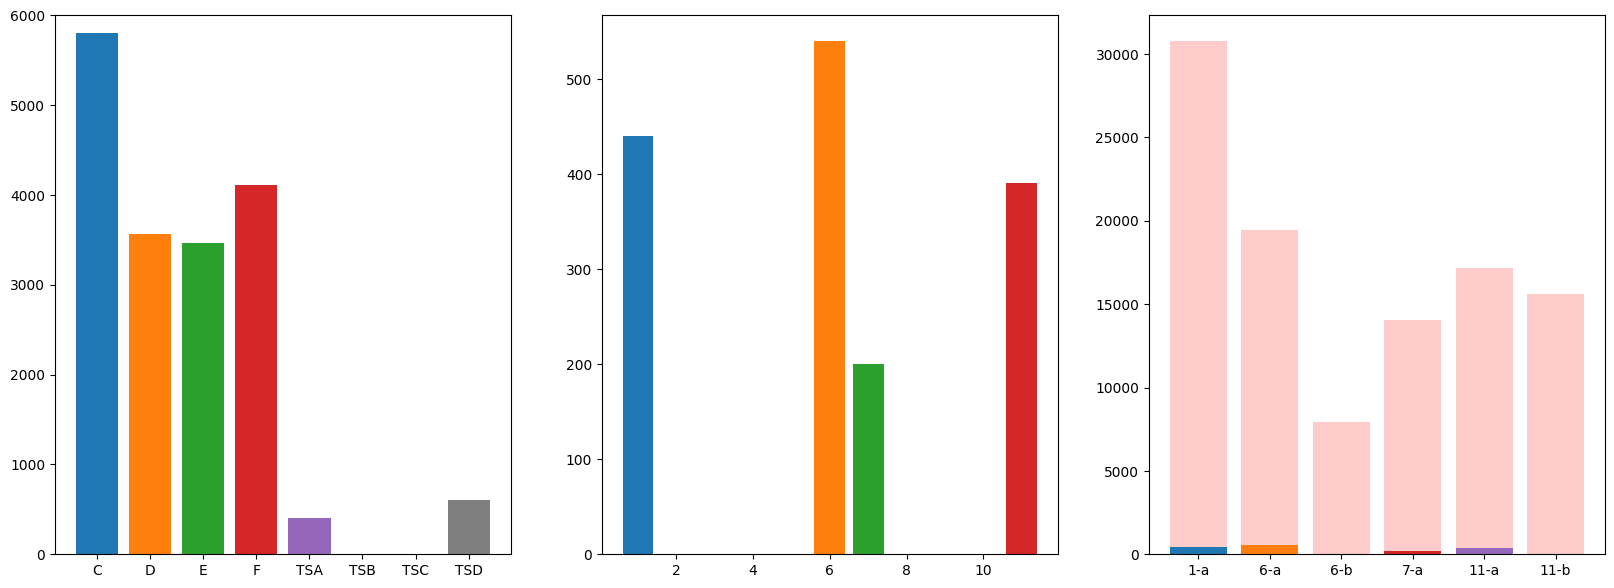

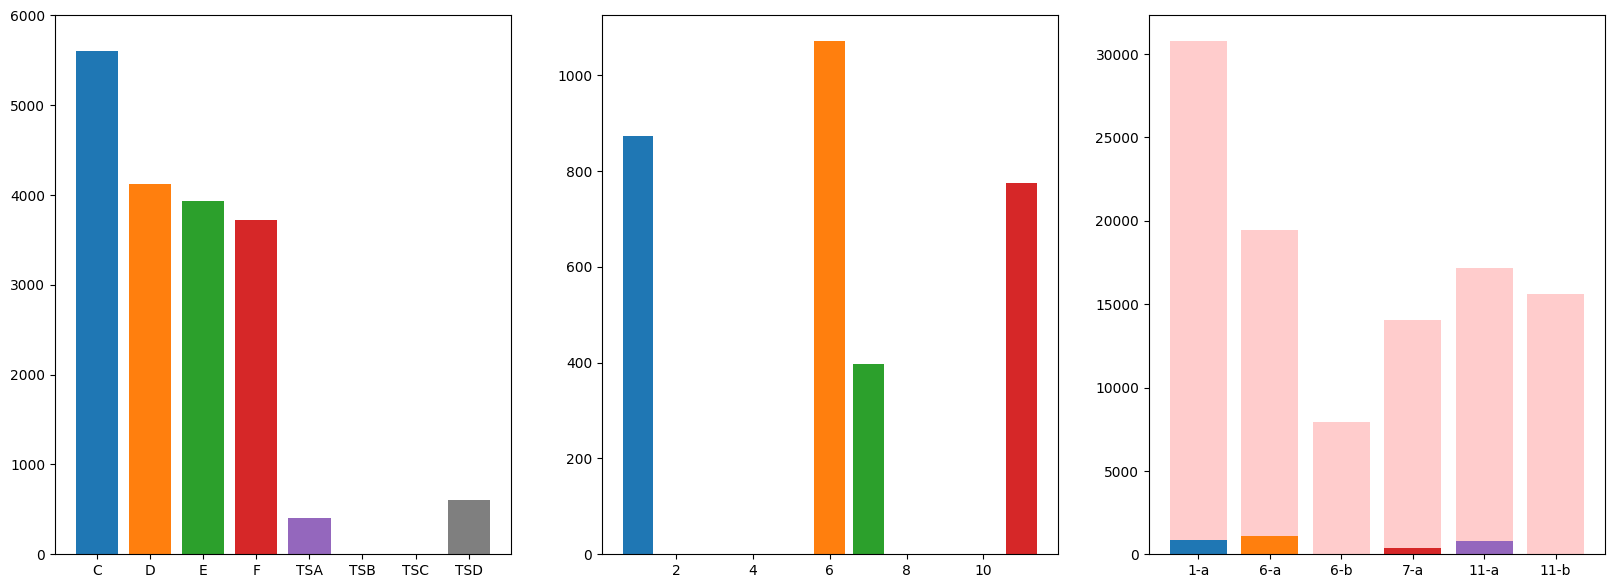

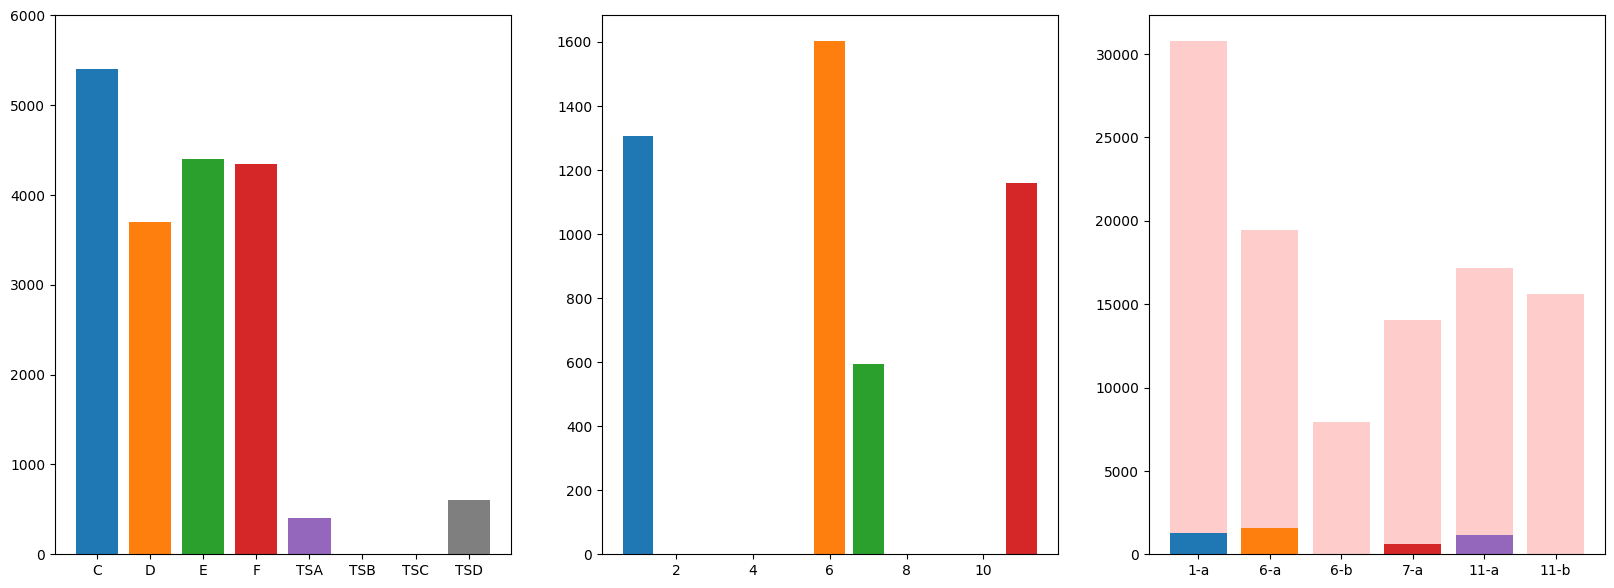

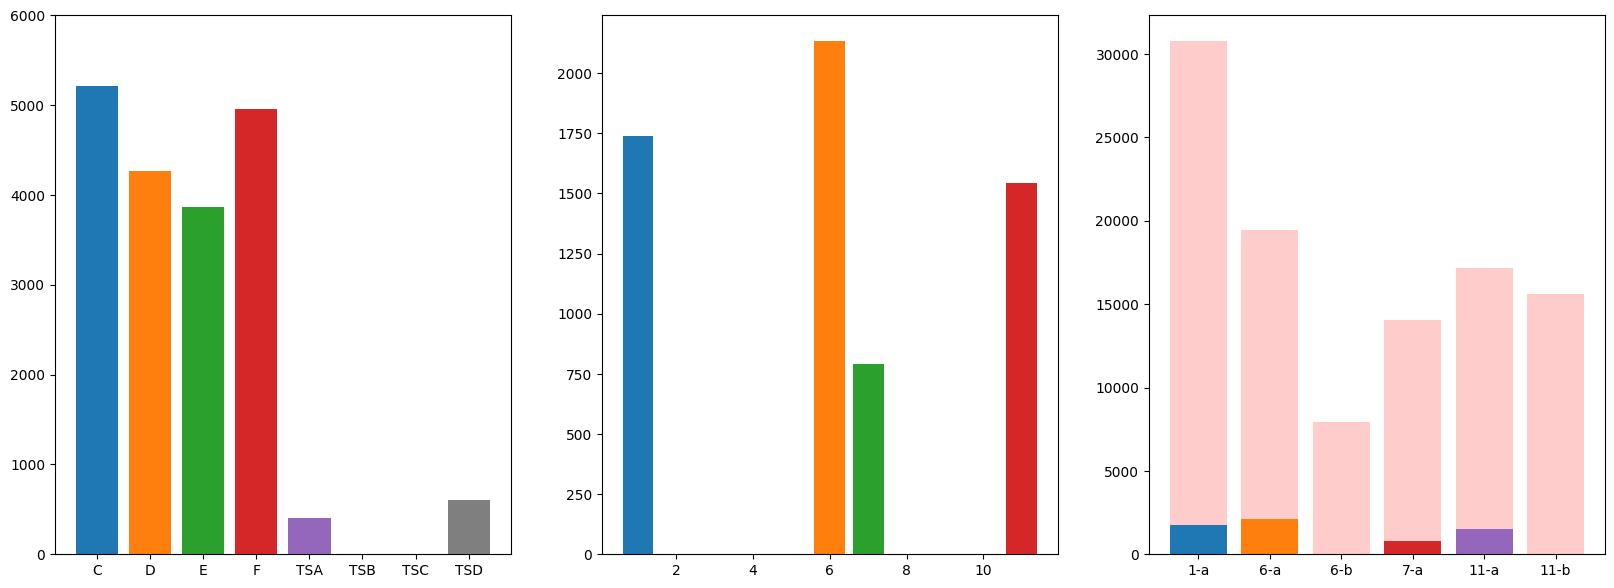

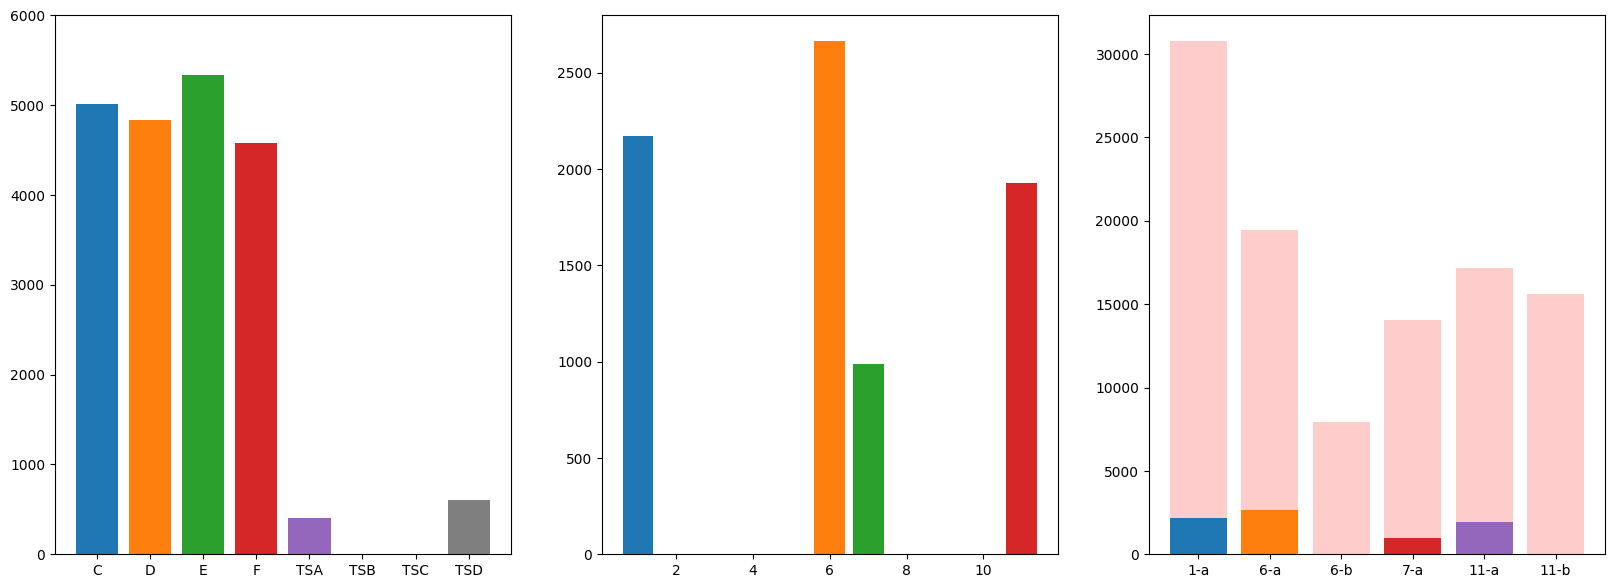

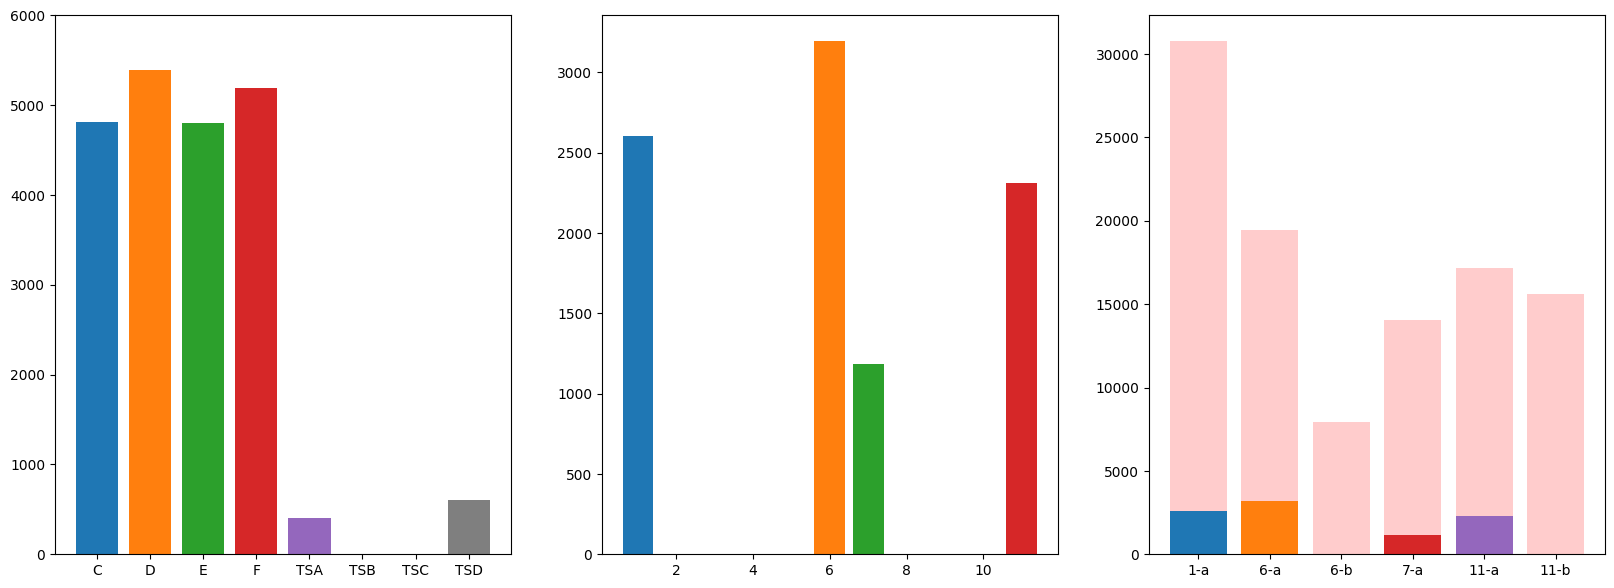

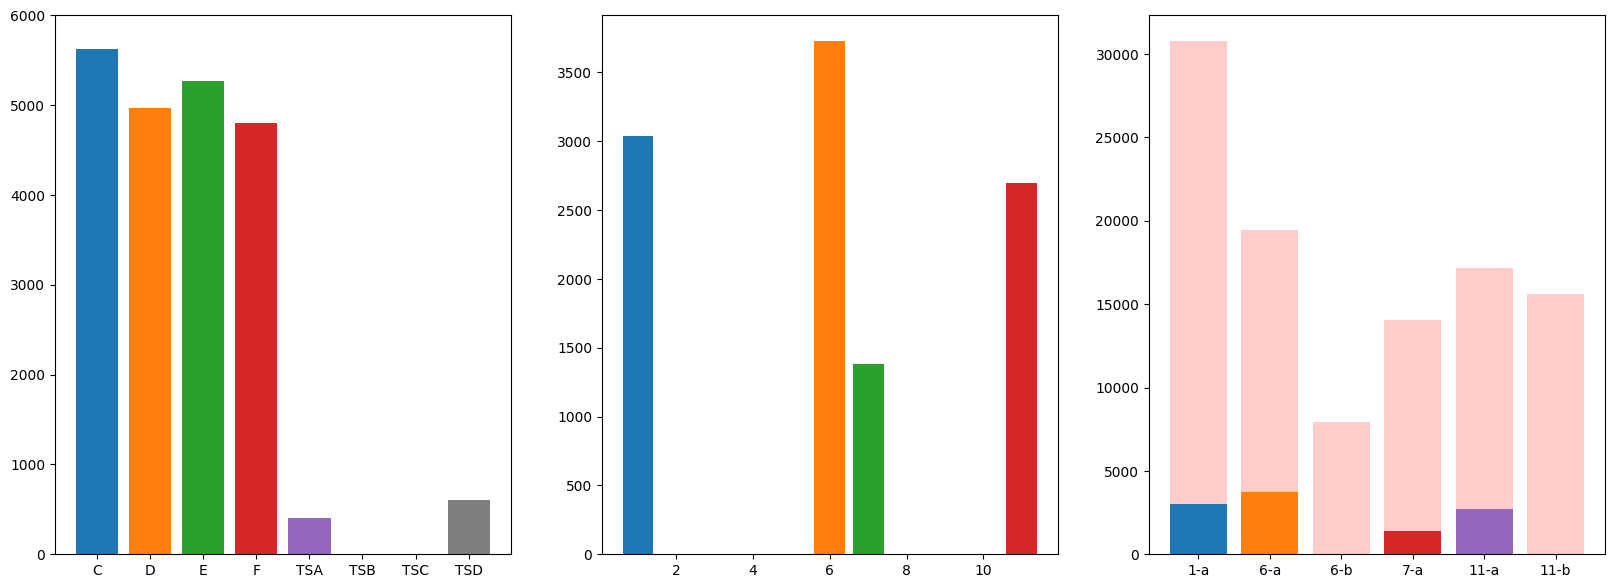

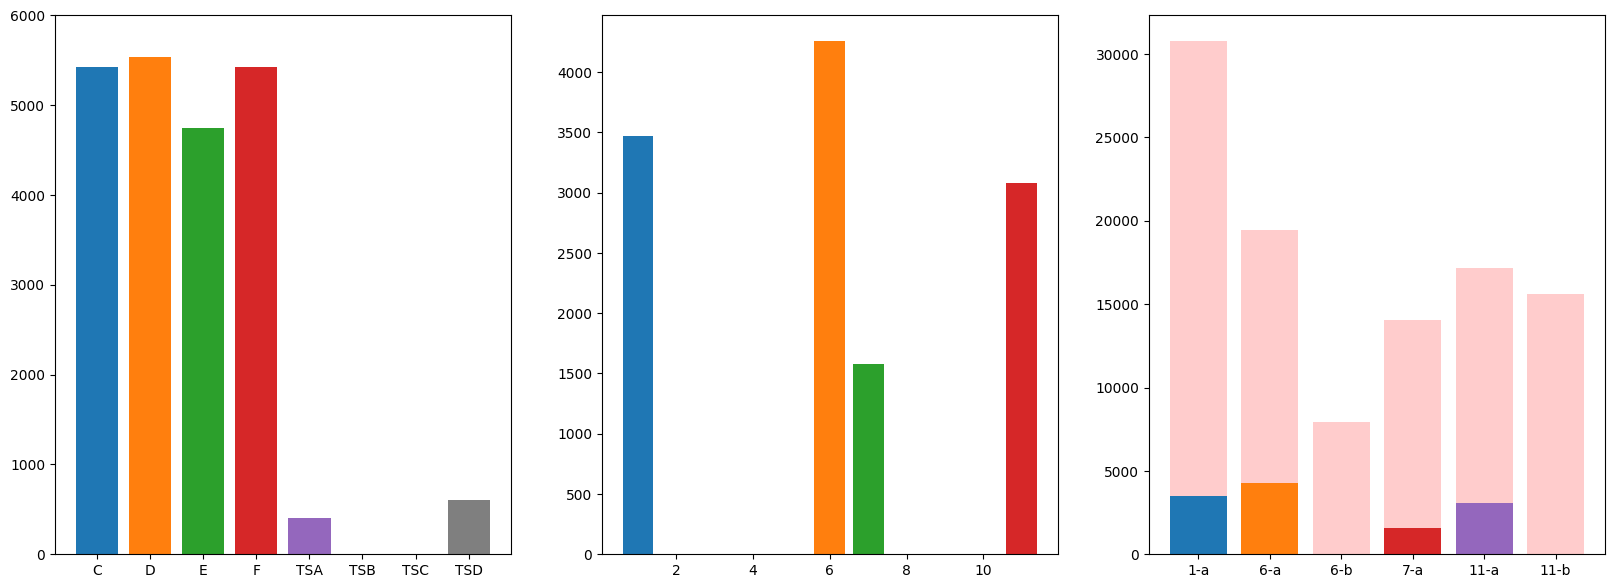

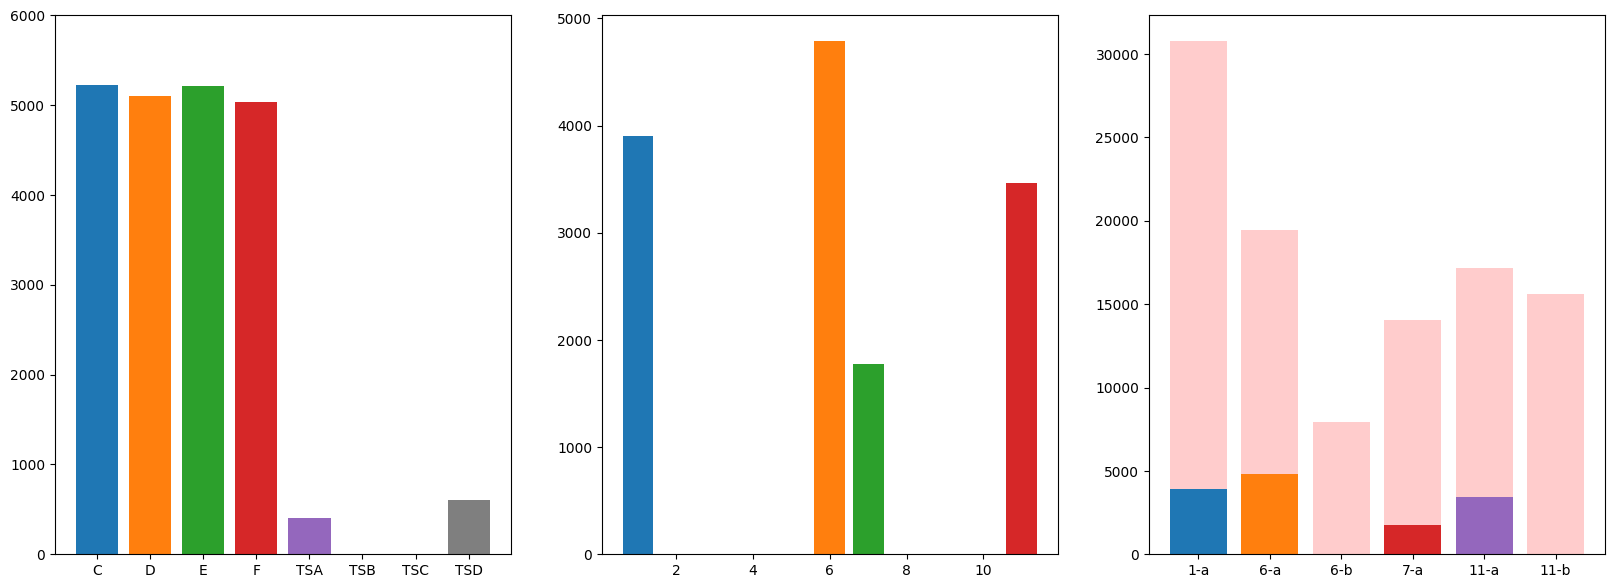

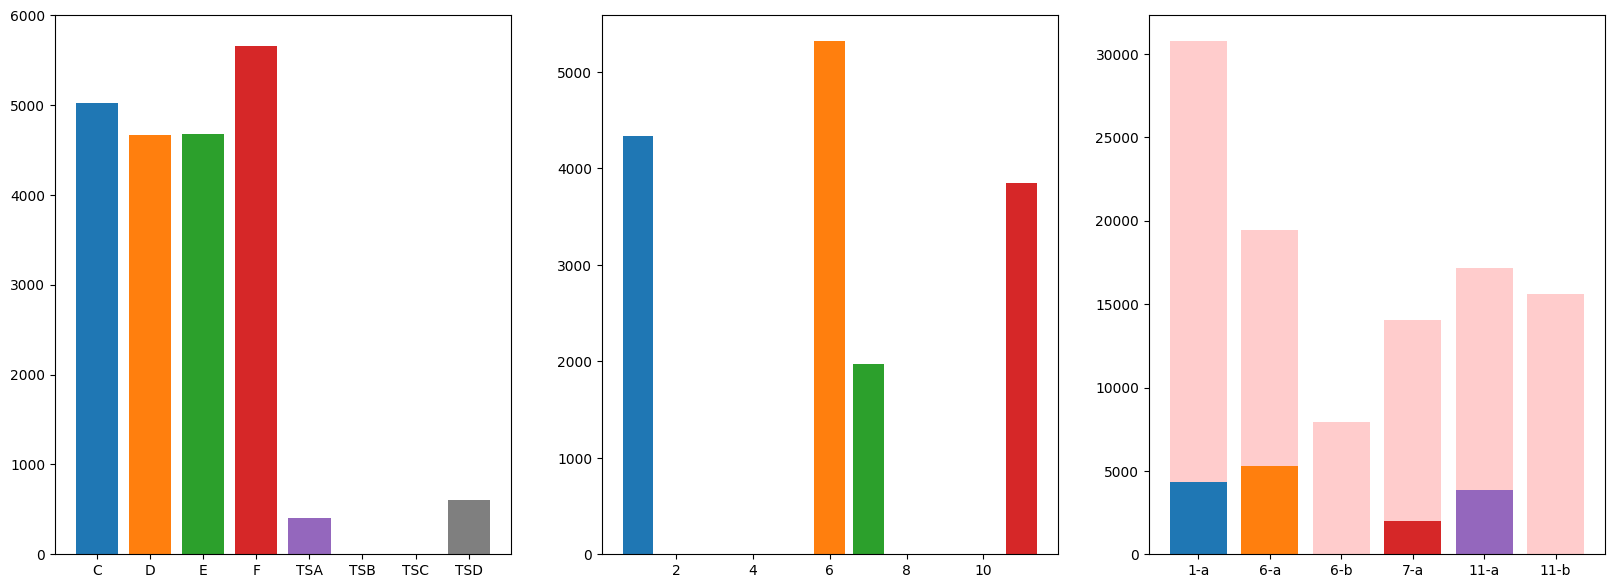

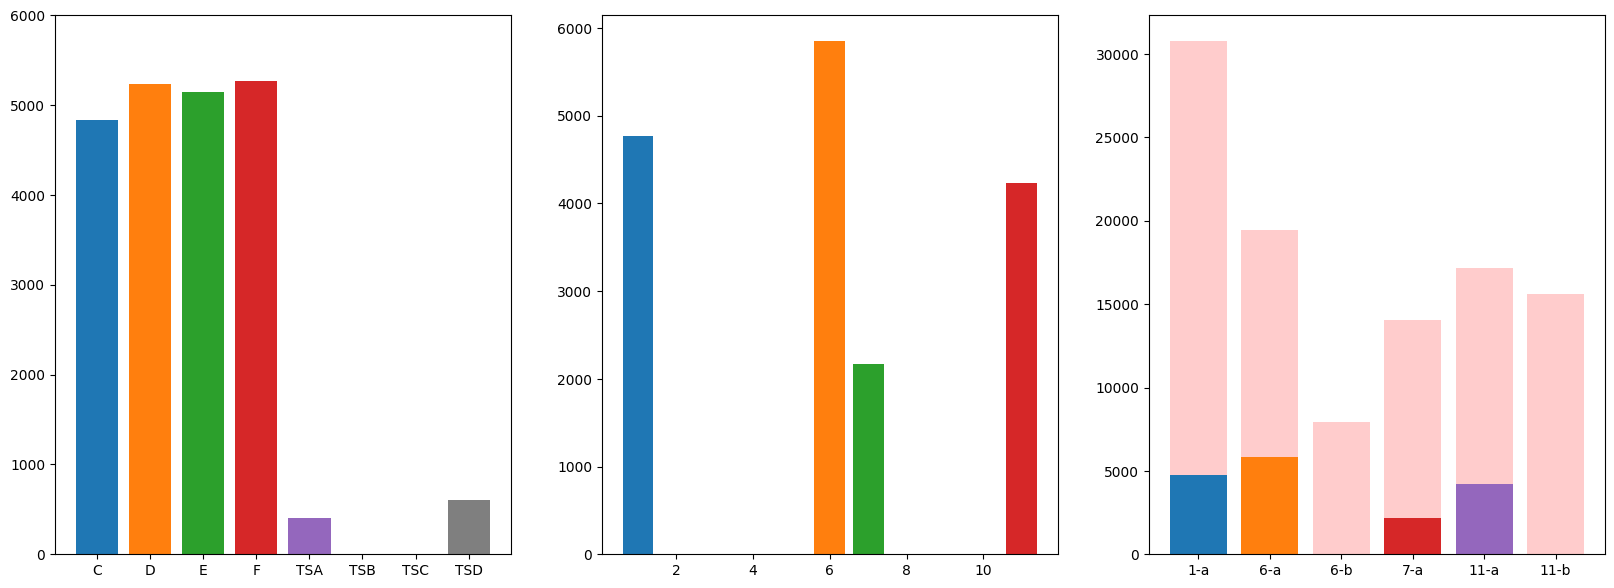

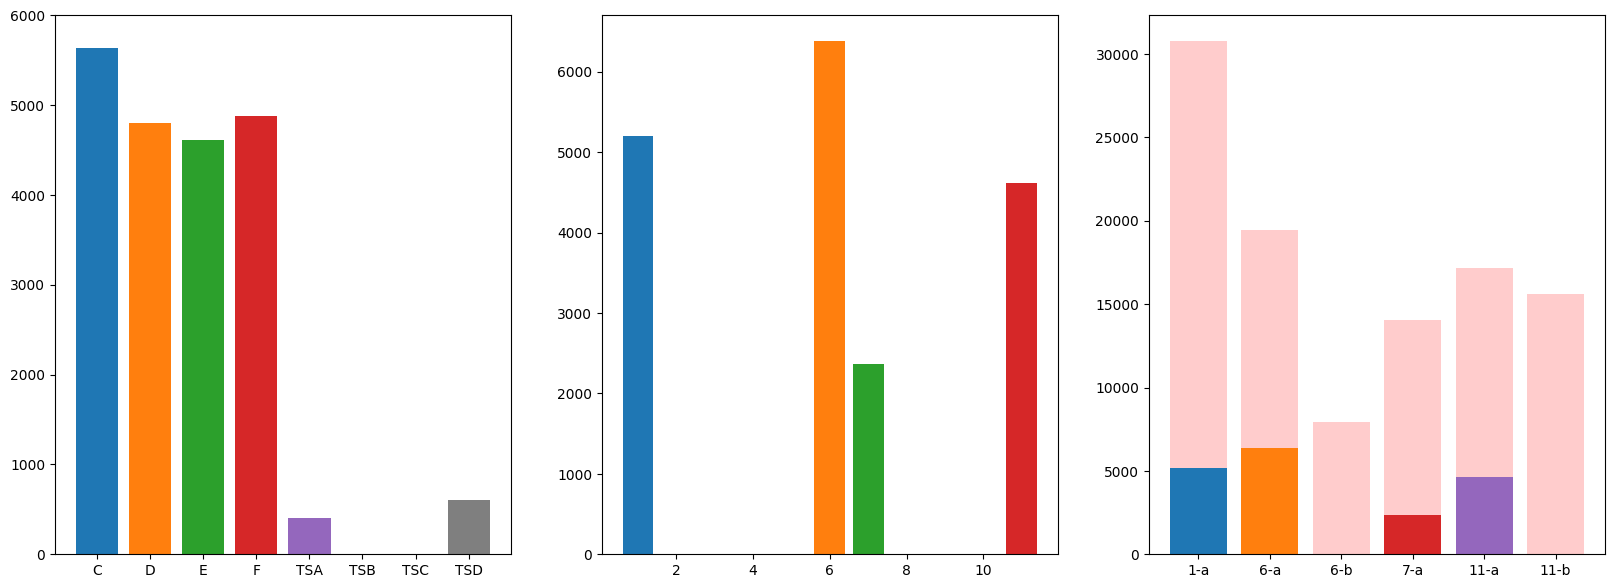

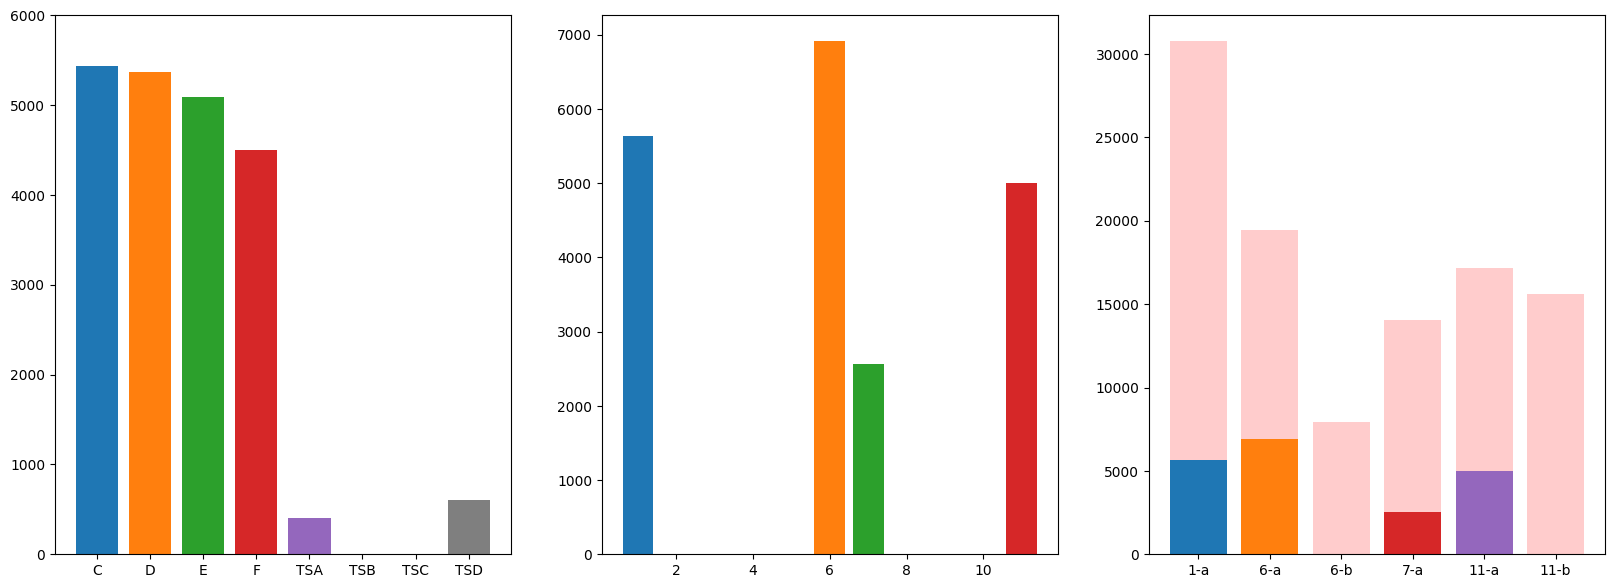

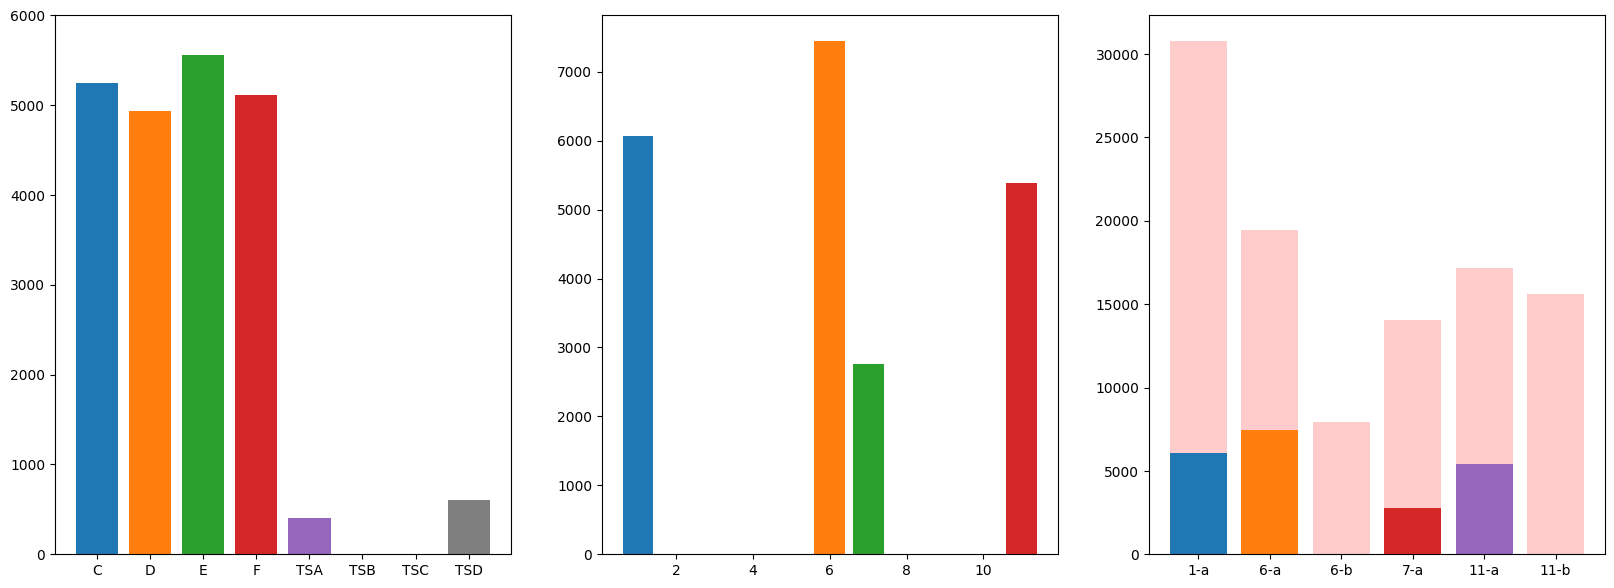

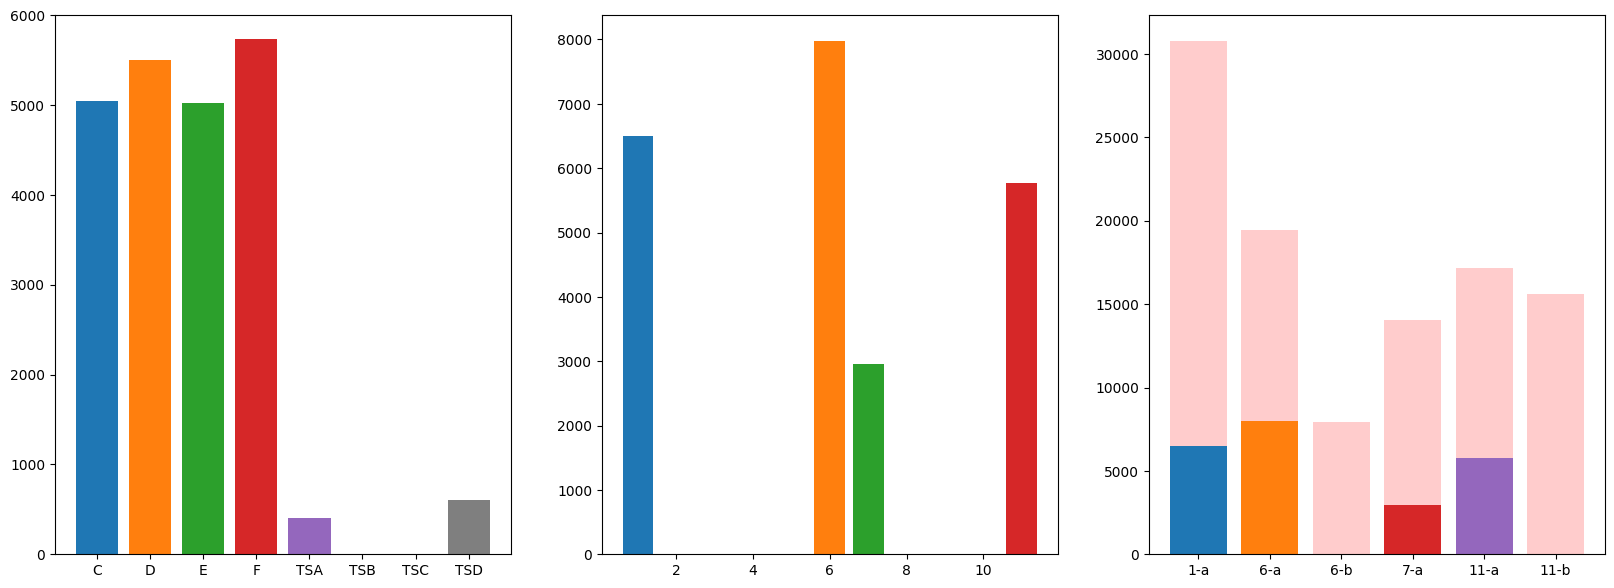

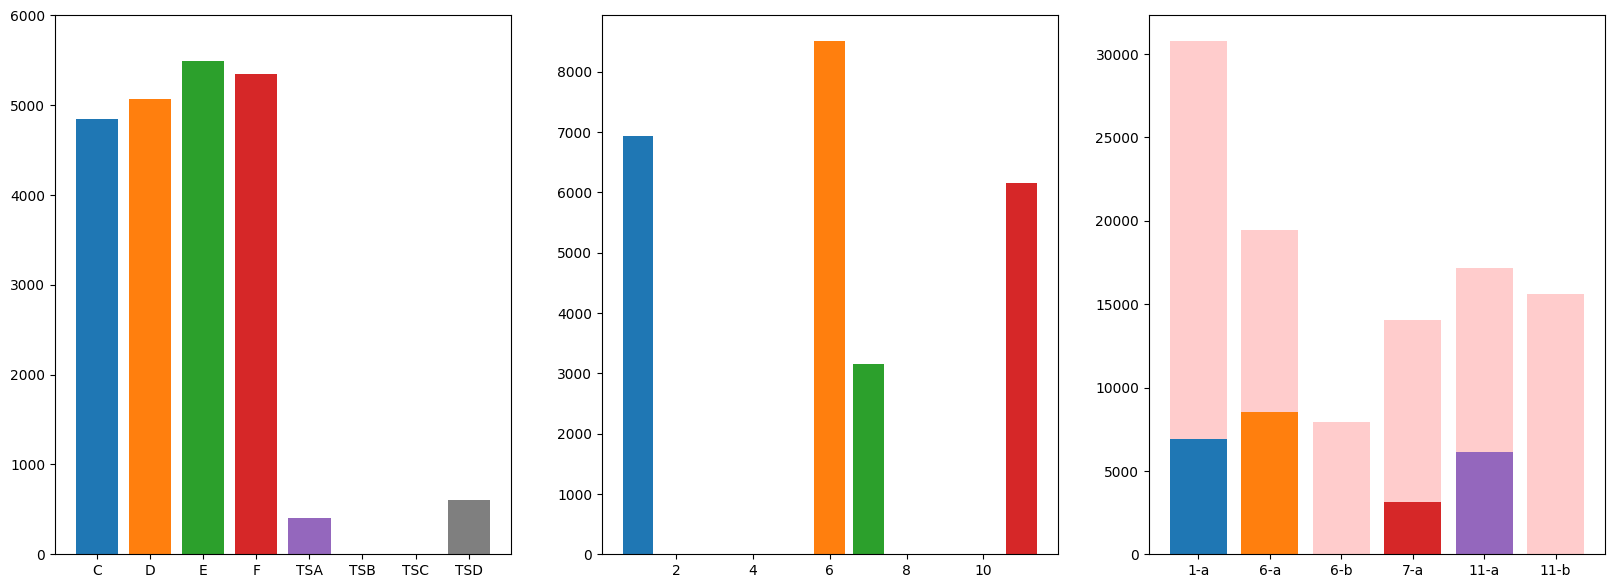

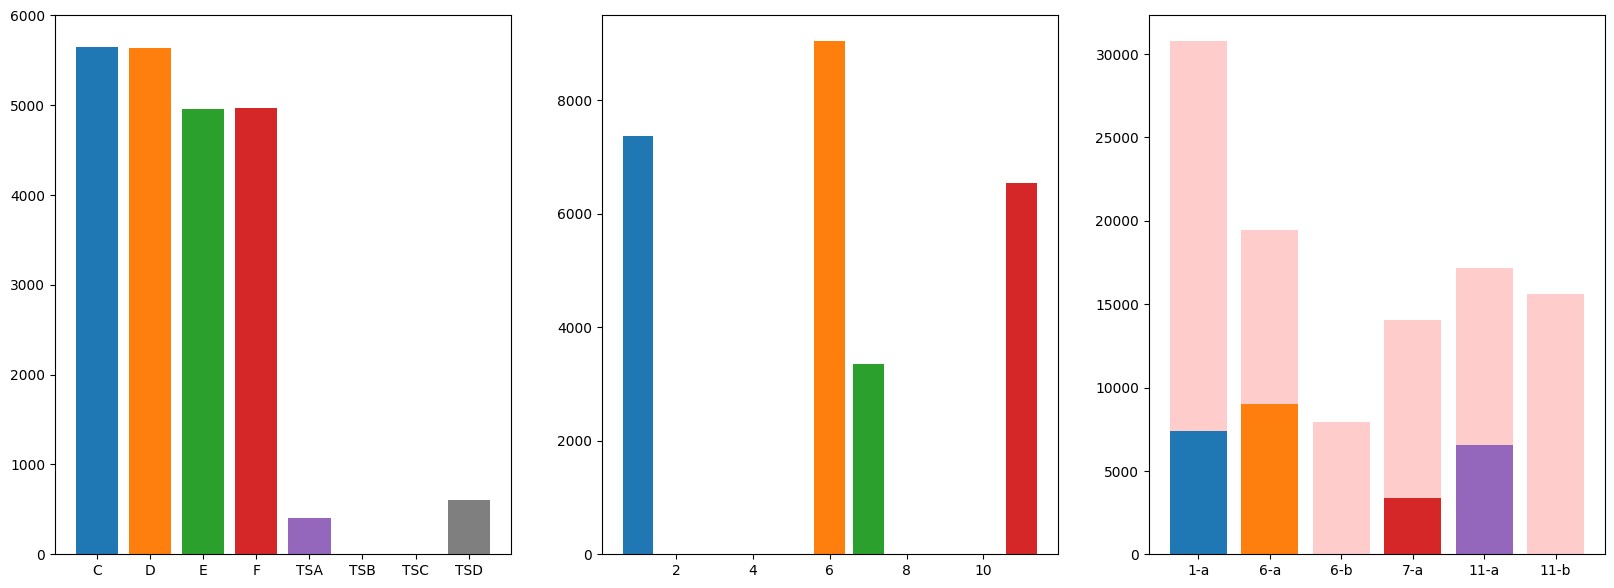

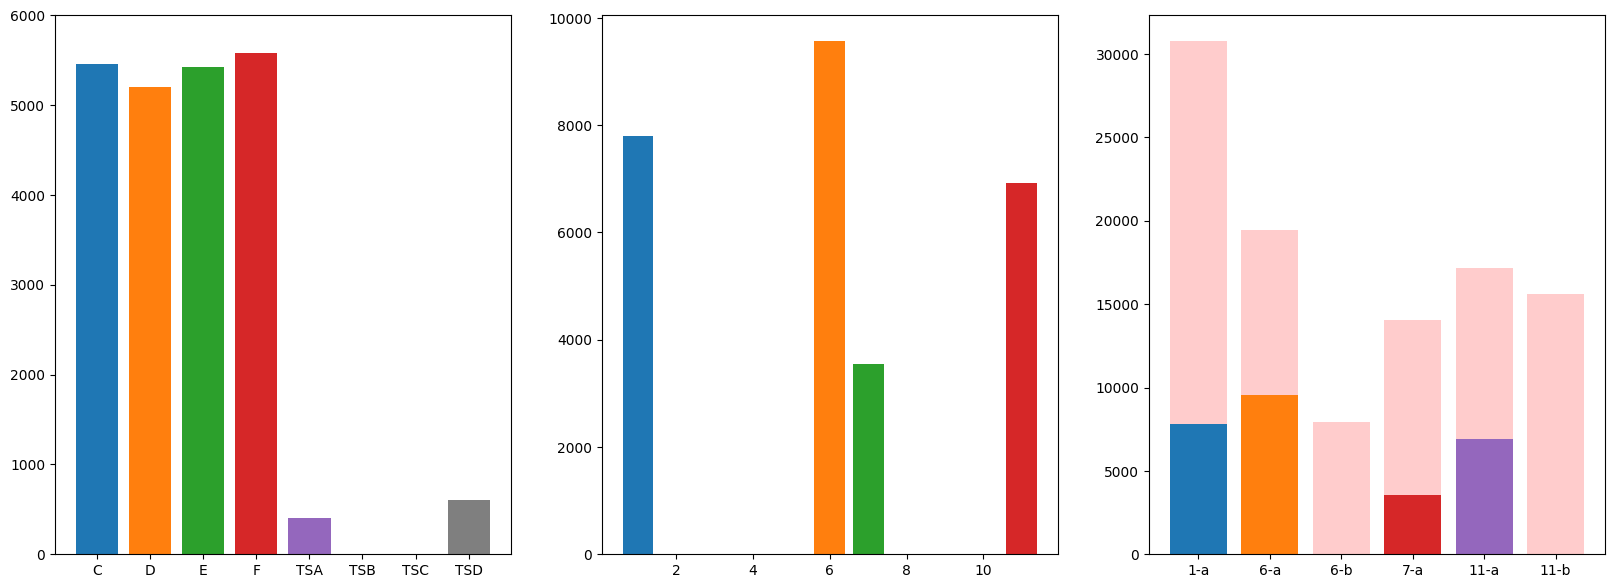

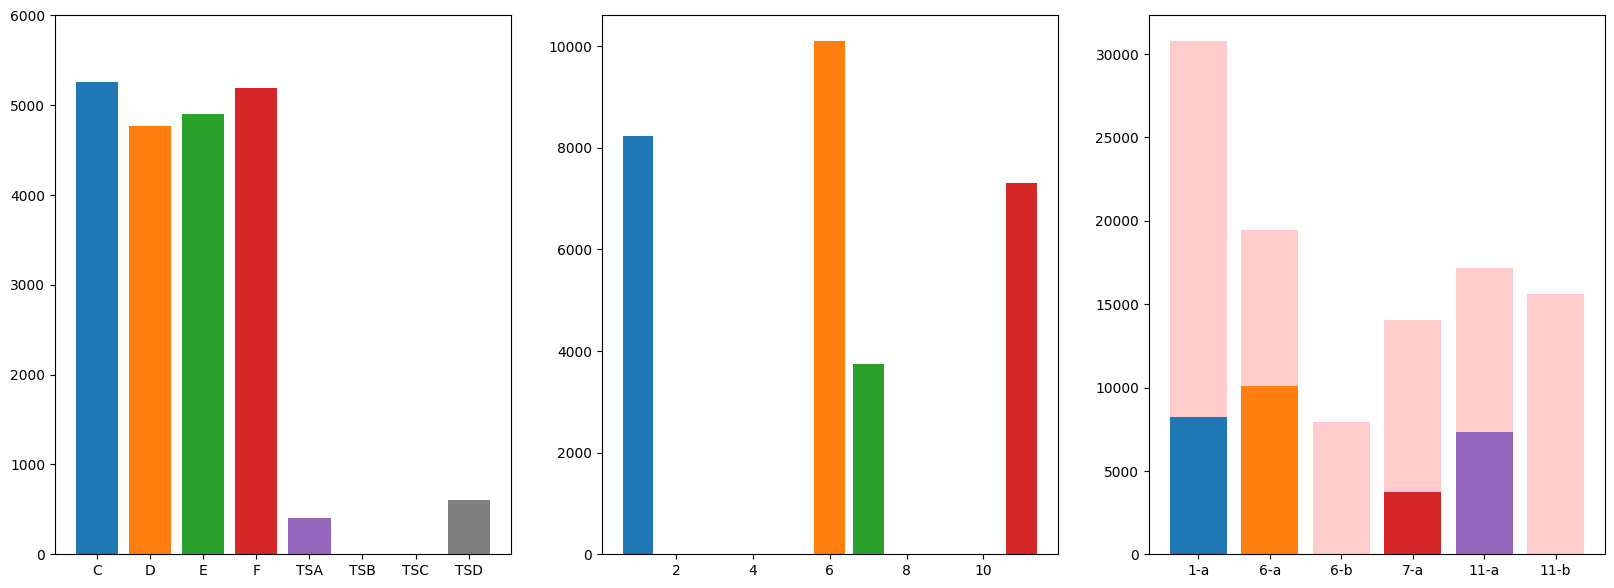

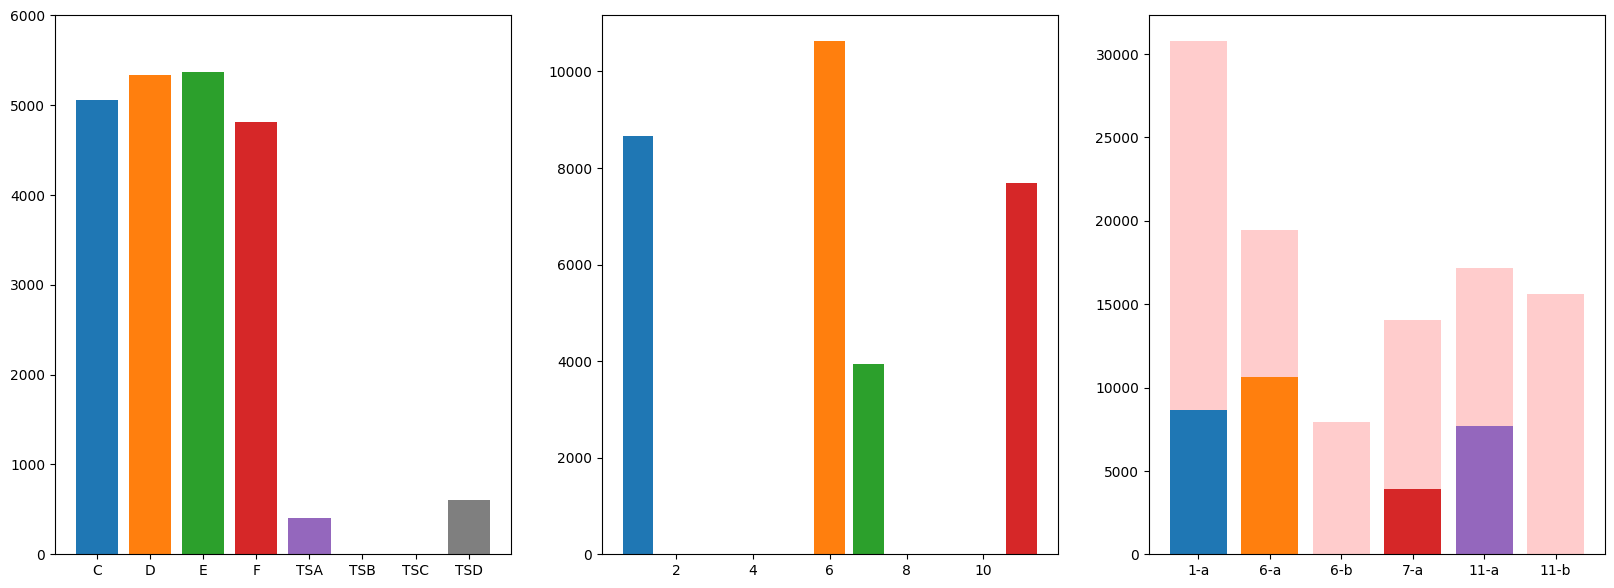

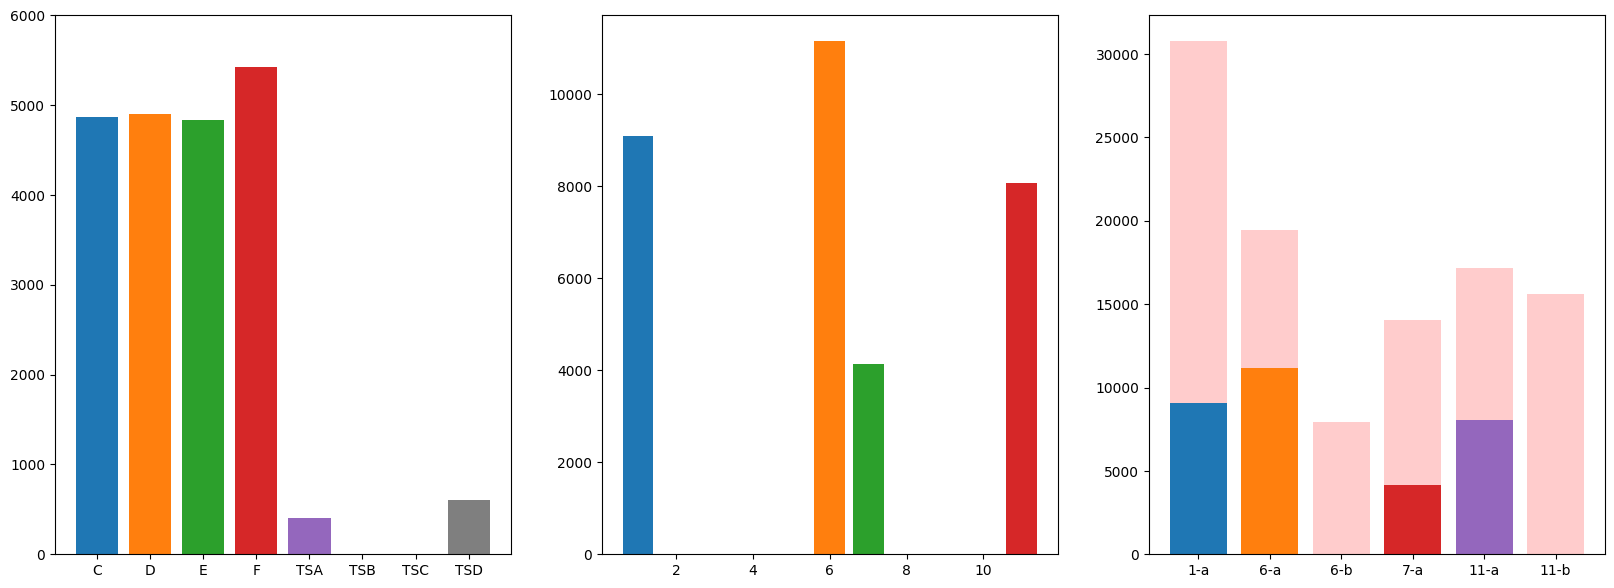

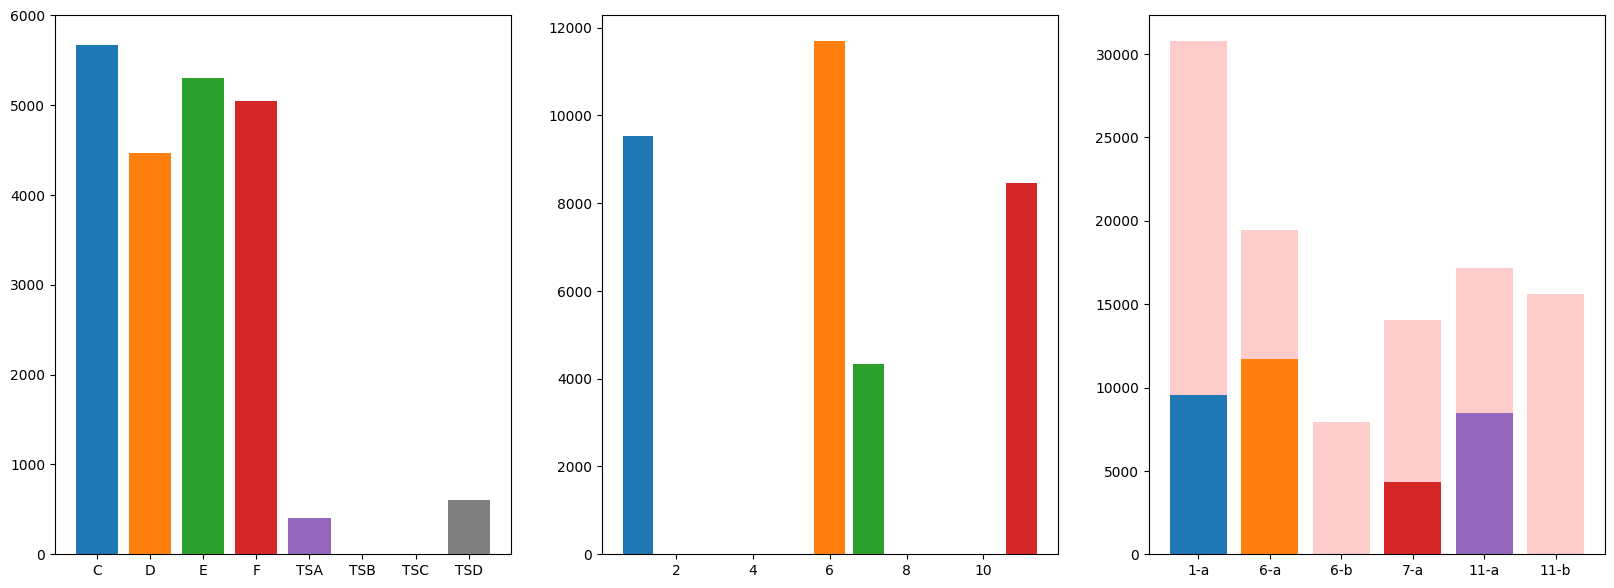

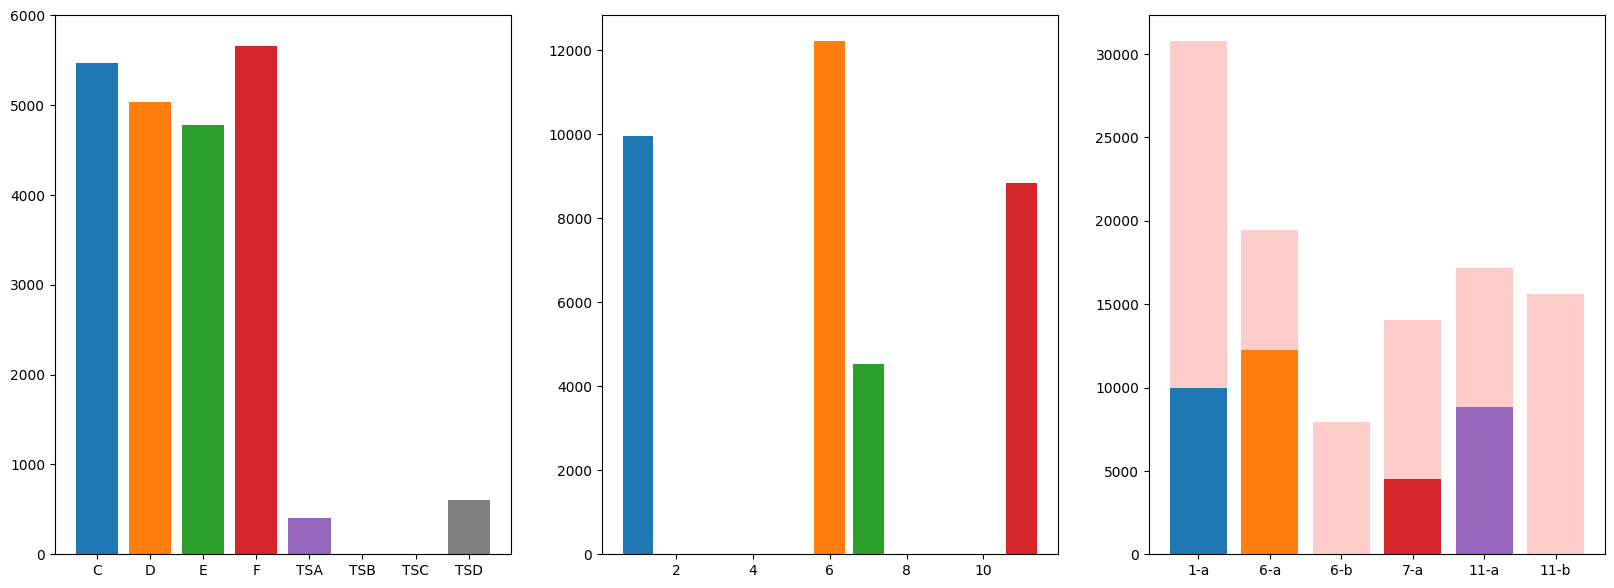

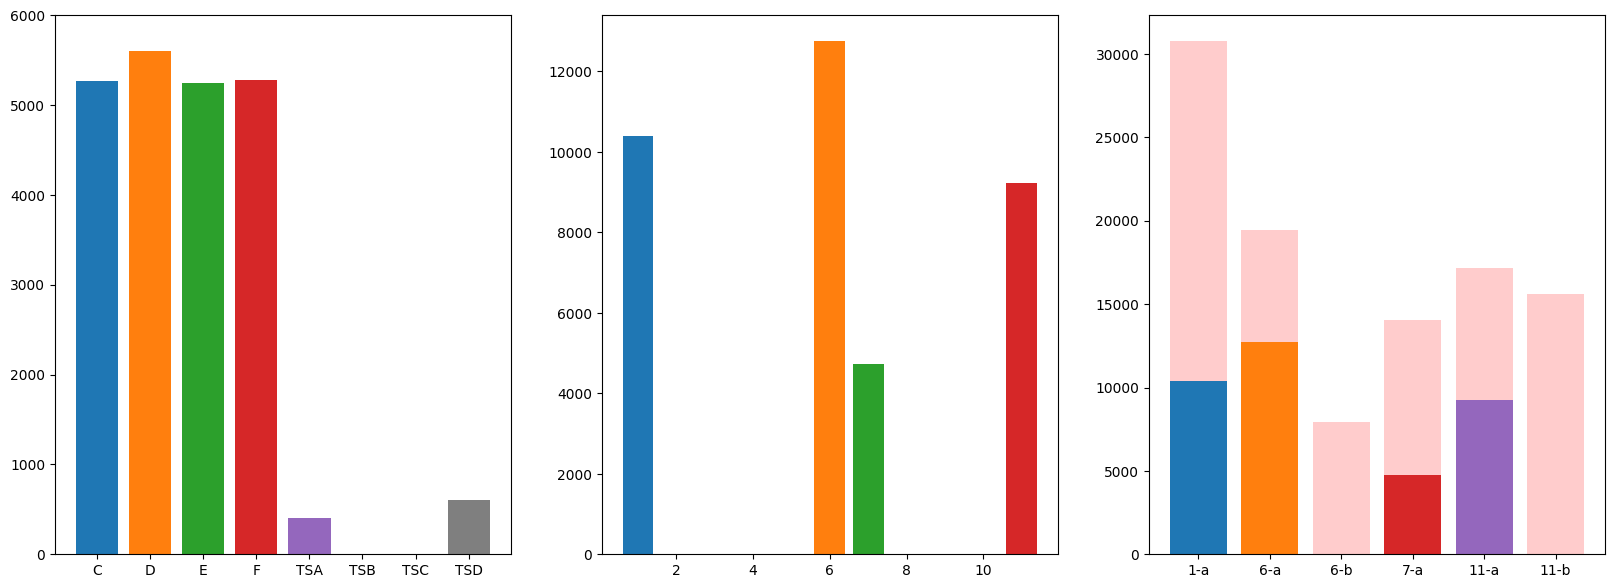

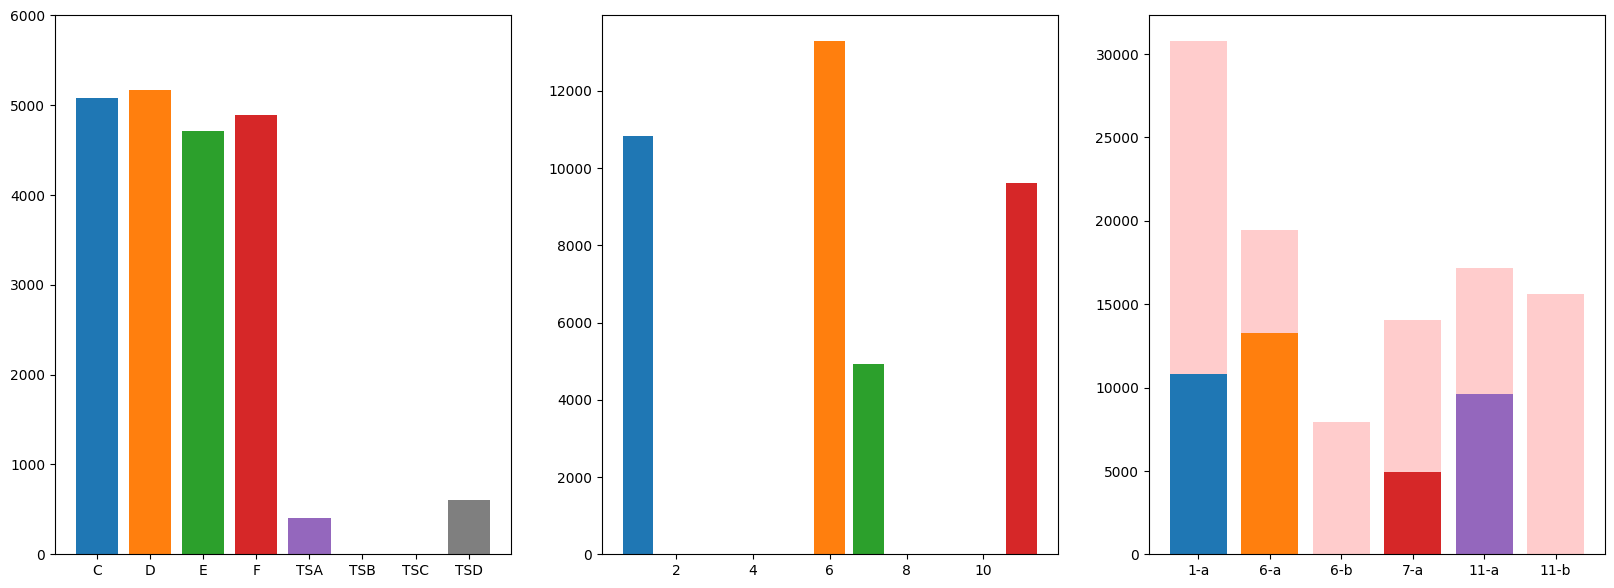

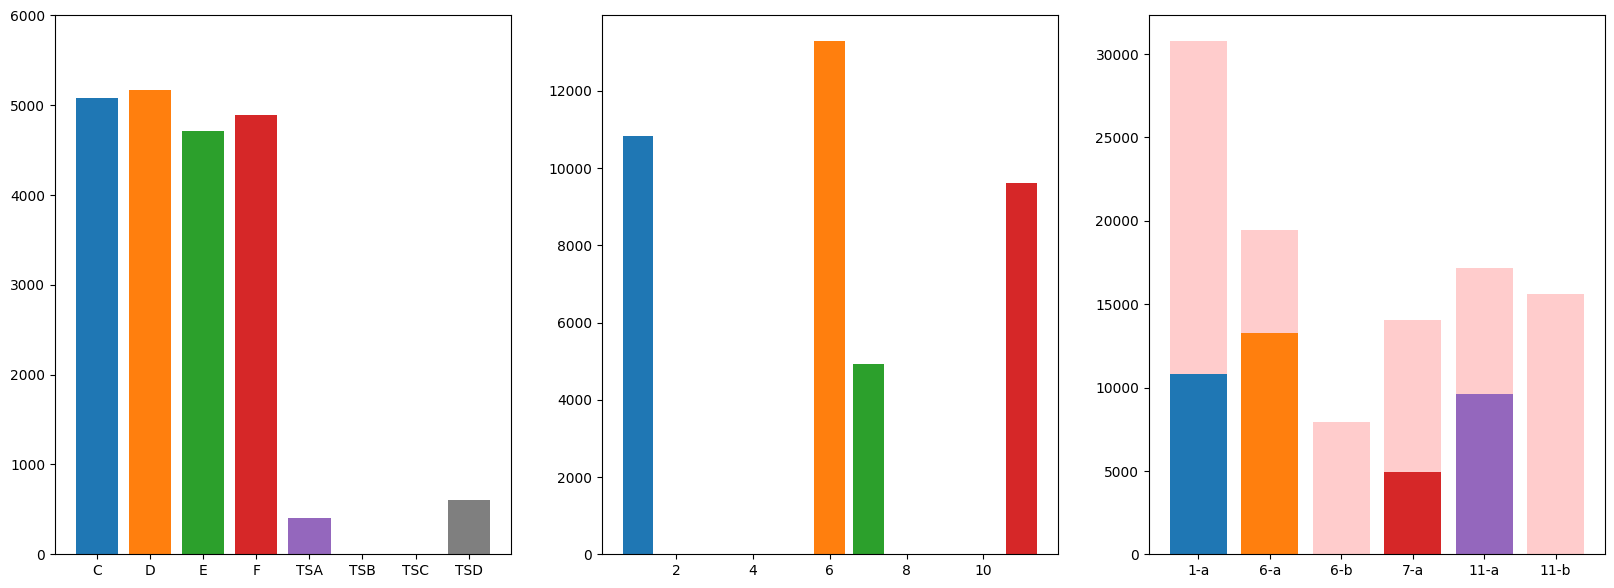

[{'blend_code': 'B0002', 'quantity': 1000, 'from': 'main_wharehouse', 'to': <__main__.Silos object at 0x15d4a9390>, 'to_silos': 'E', 'ttgo': 11, 'to_line': [6]}]
Current timestamp 1500
B0002 B0002
True
adding
5711.146666666466
timestamp 1500
5 steps
Current timestamp 1501
Current timestamp 1502
Current timestamp 1503
Current timestamp 1504
Current timestamp 1505
B0002 B0002
True
adding
5666.879999999799
timestamp 1505
5 steps
Current timestamp 1506
Current timestamp 1507
Current timestamp 1508
Current timestamp 1509
Current timestamp 1510
B0002 B0002
True
adding
5622.613333333132
timestamp 1510
5 steps
Current timestamp 1511
entering
B0002 1000
B0002 B0002
True
adding
5604.906666666465
Current timestamp 1512
checking silos
The silo: F 4814.026166666652
timestamp 1512
Current timestamp 1513
Current timestamp 1514
Current timestamp 1515
B0003 B0003
True
adding
5794.820666666652
timestamp 1515
5 steps
Current timestamp 1516
Current timestamp 1517
Current timestamp 1518
Current timestamp 1

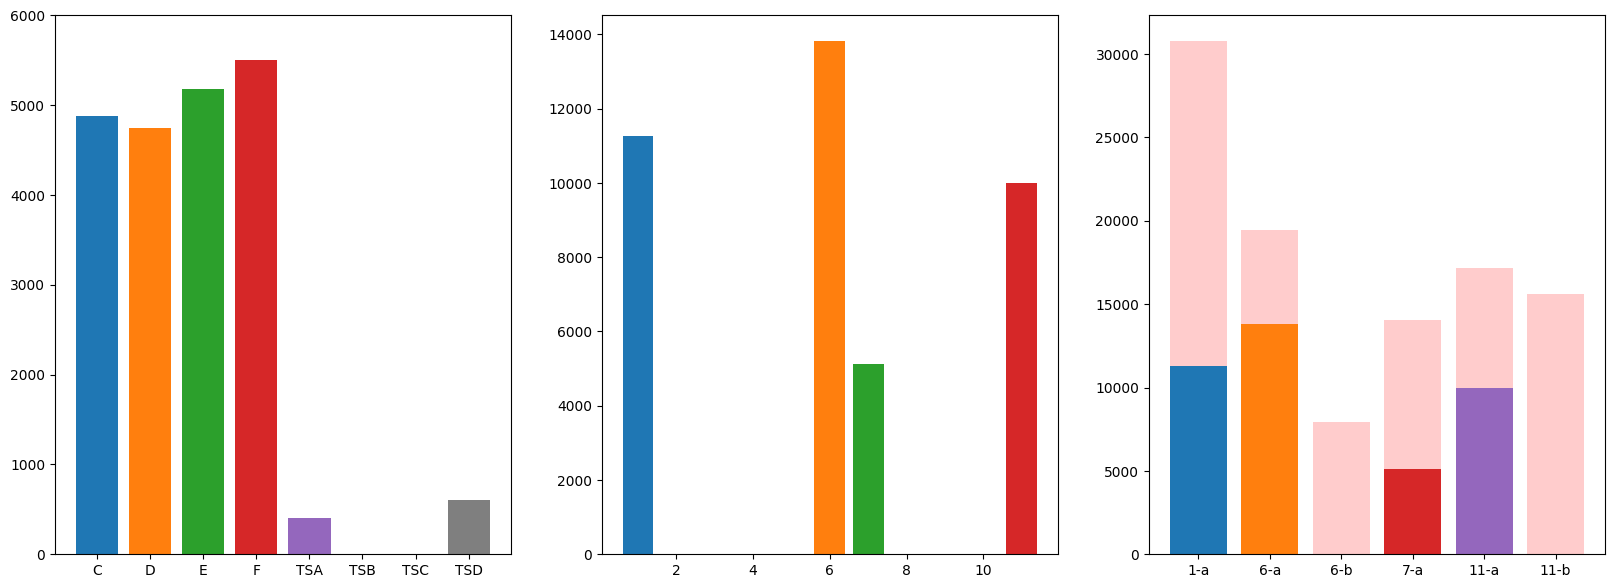

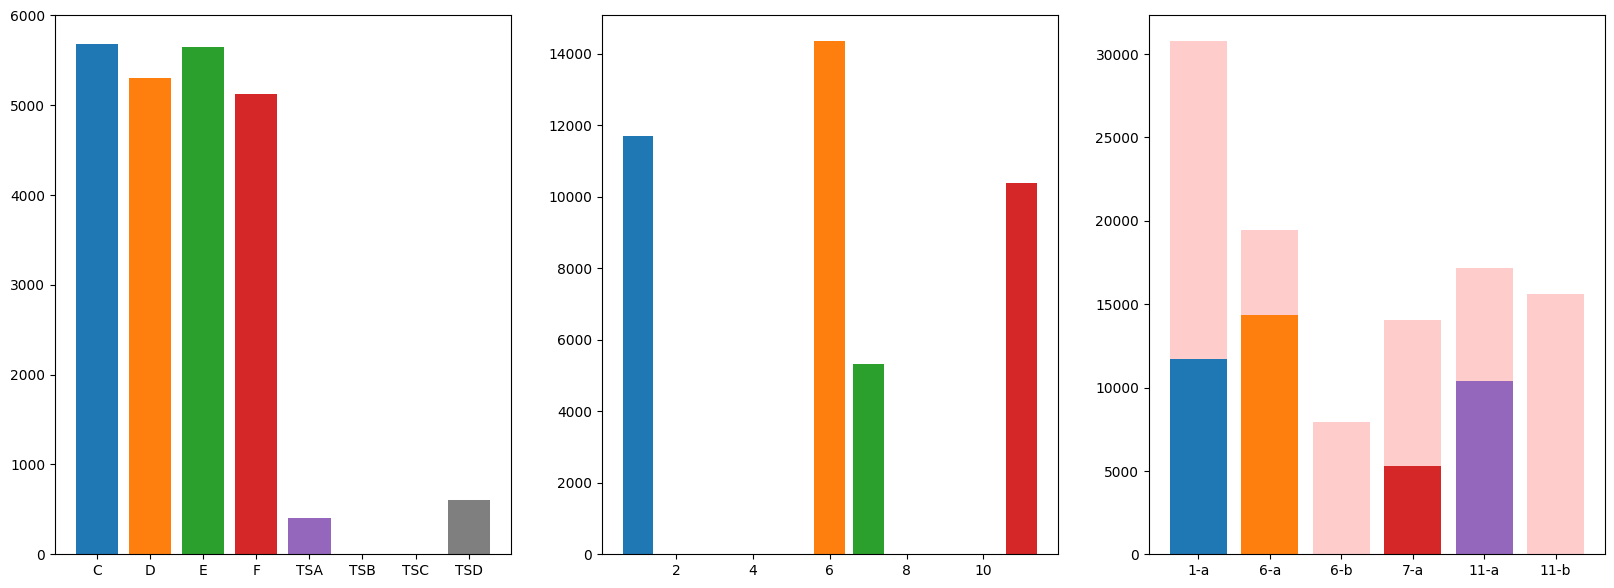

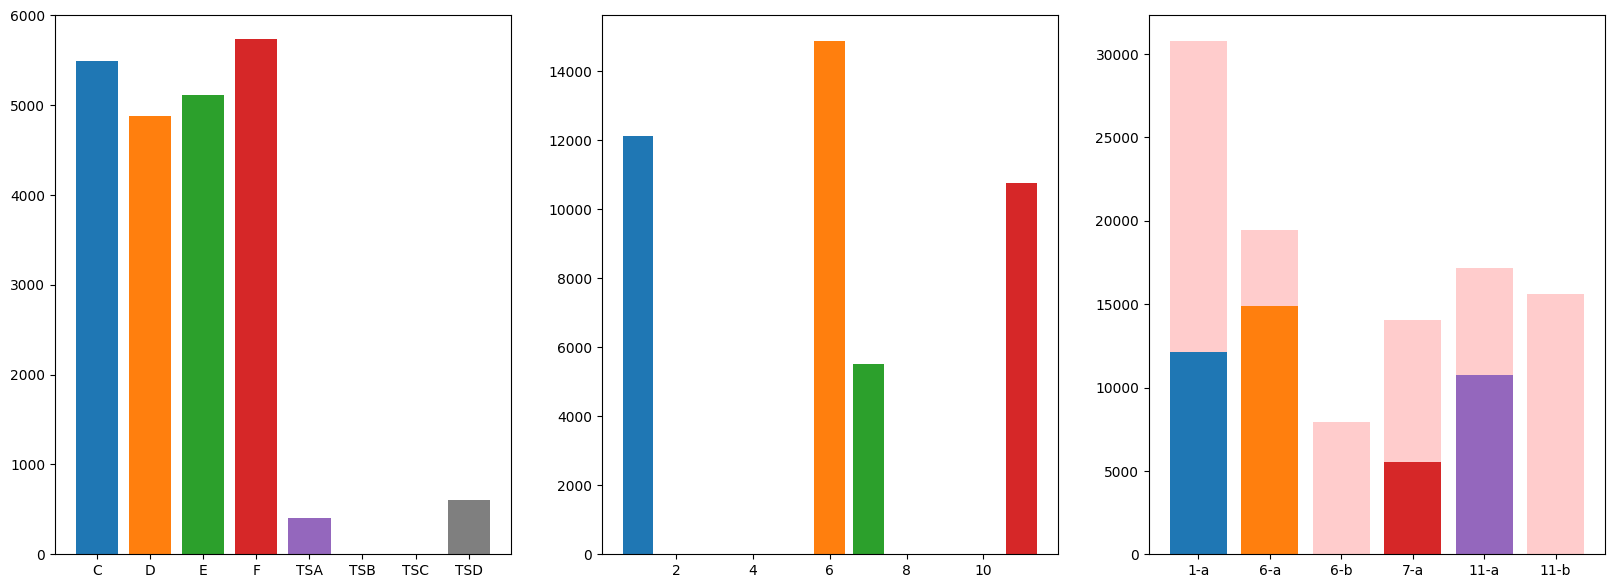

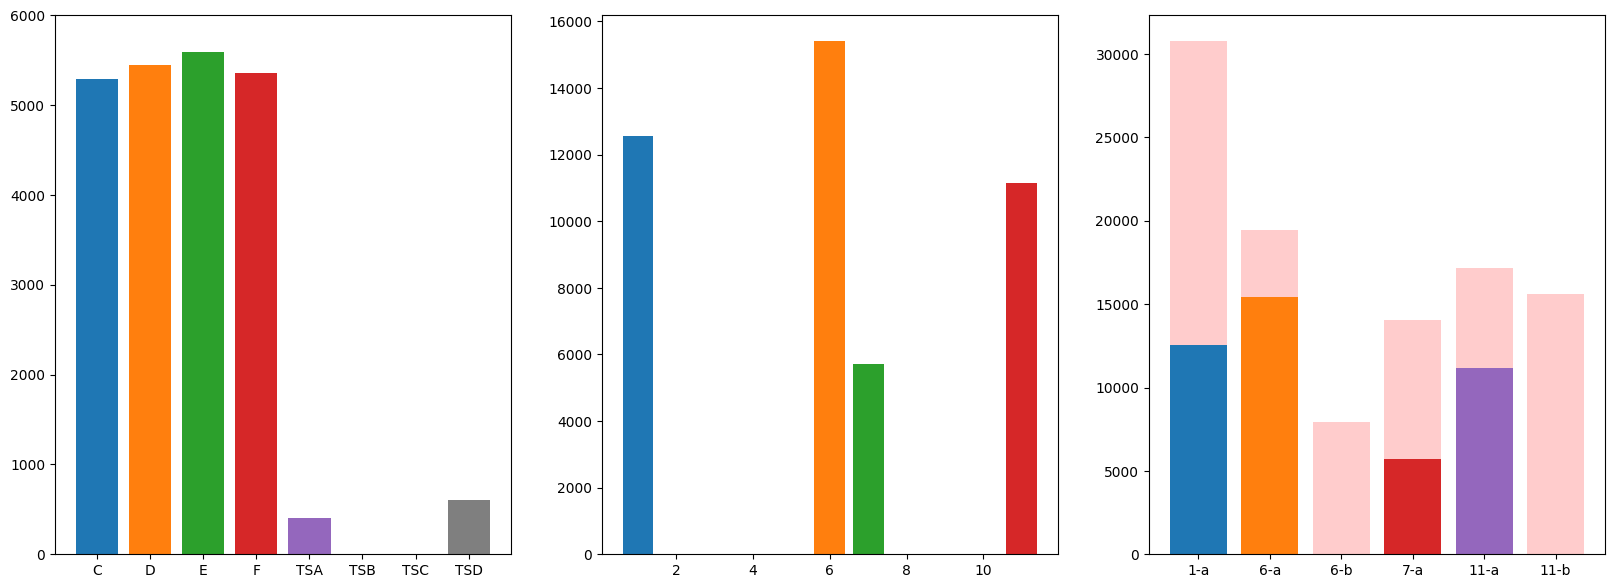

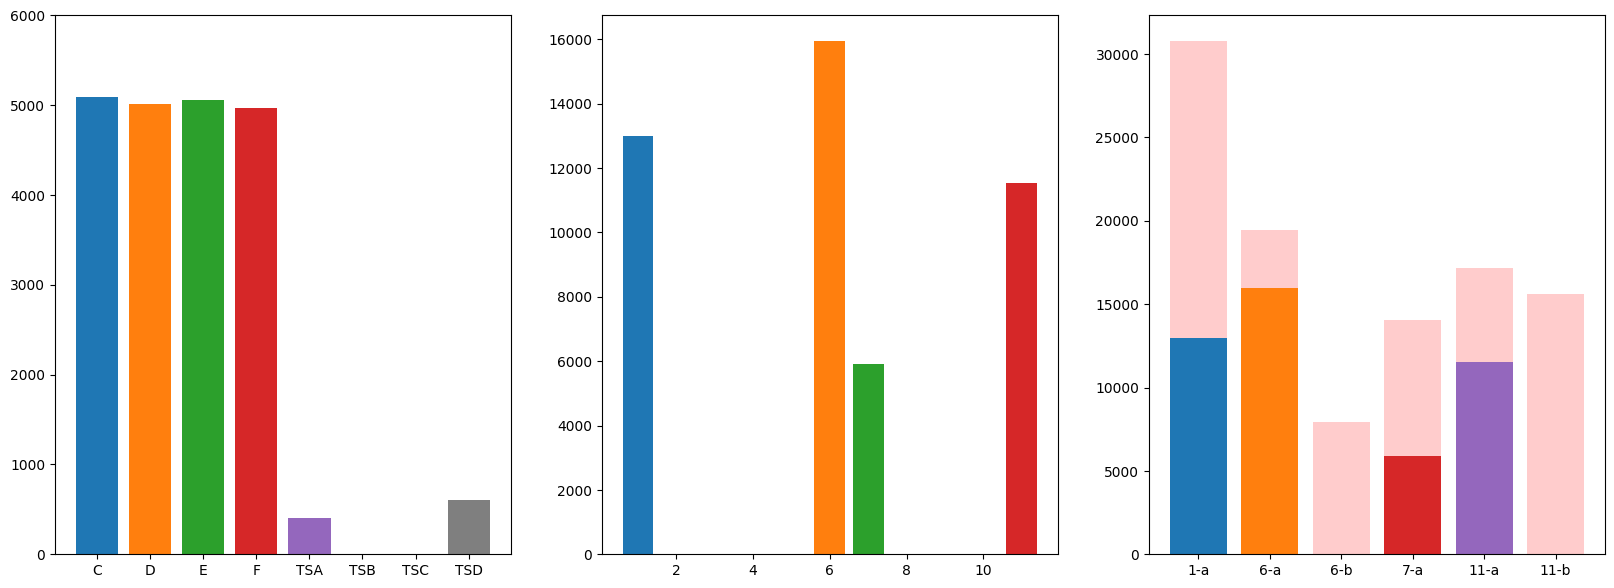

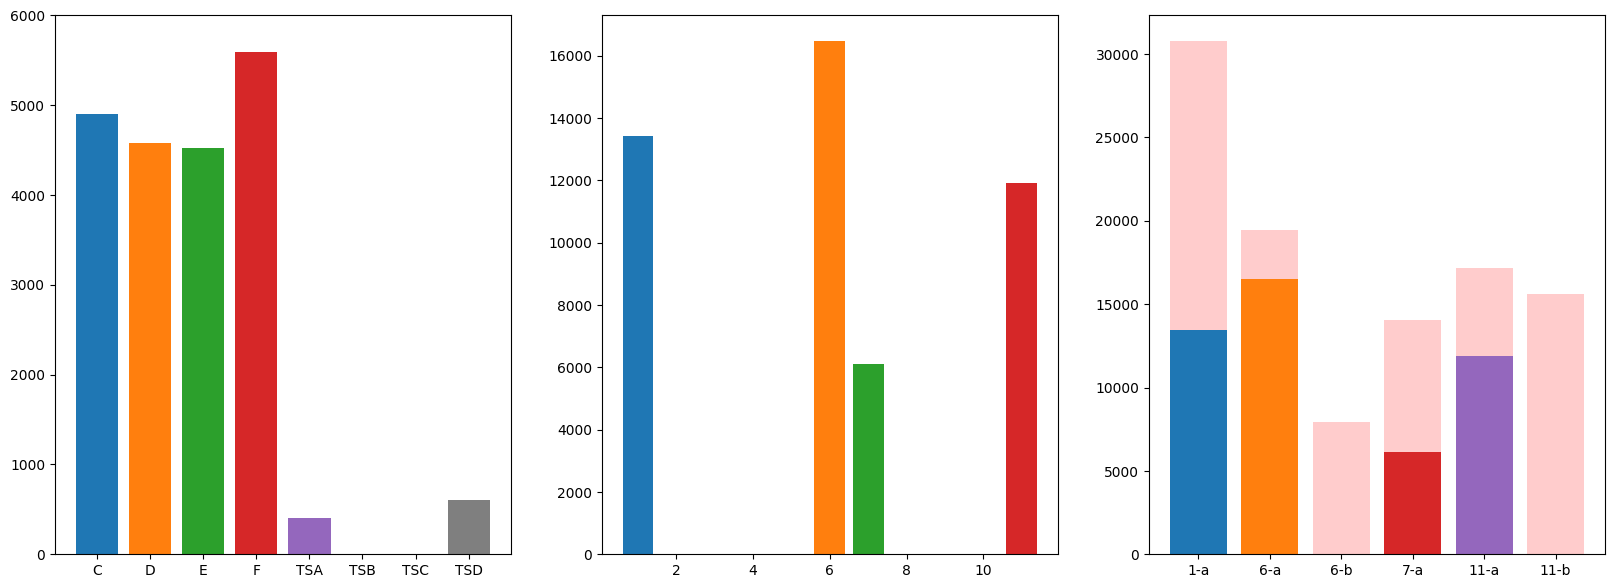

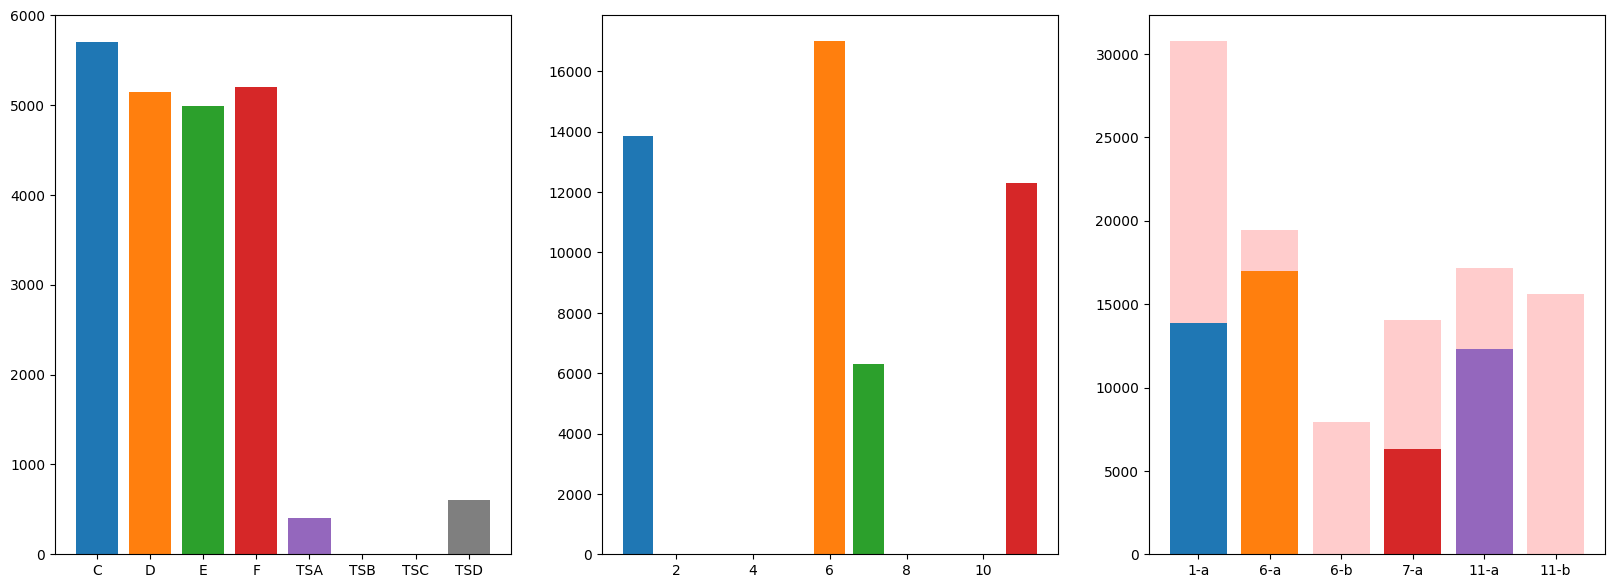

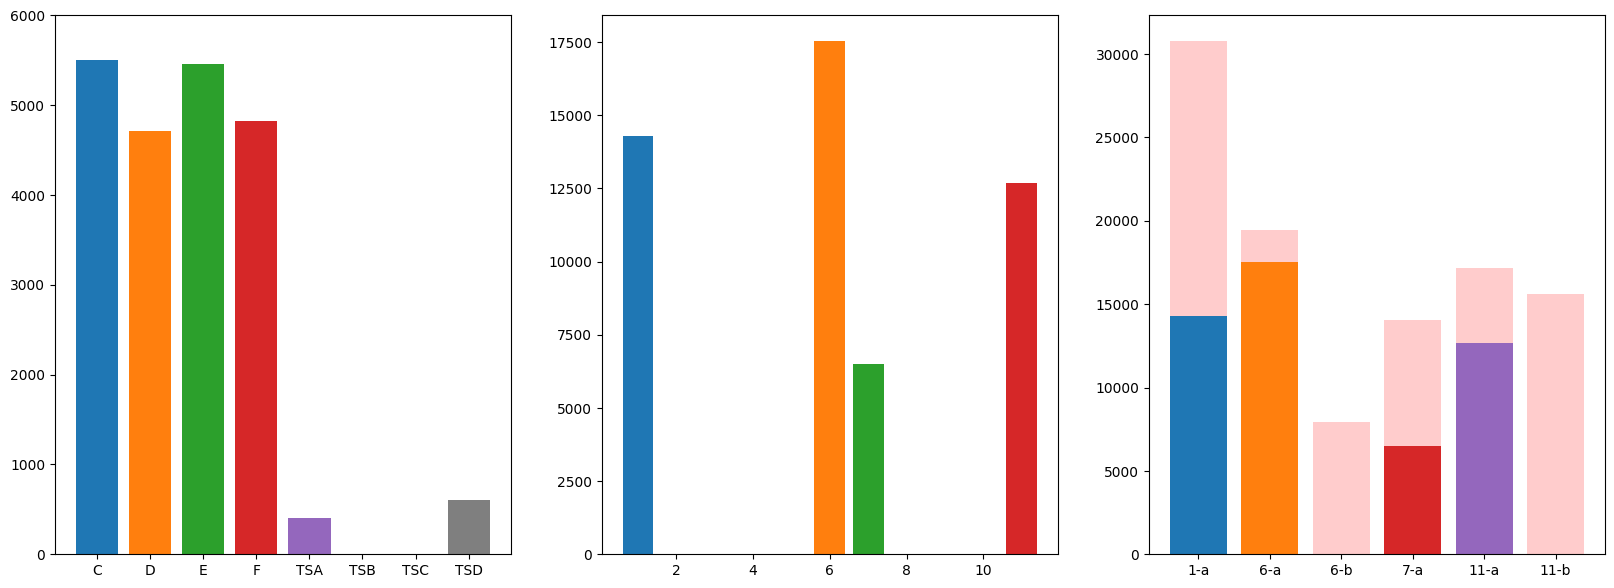

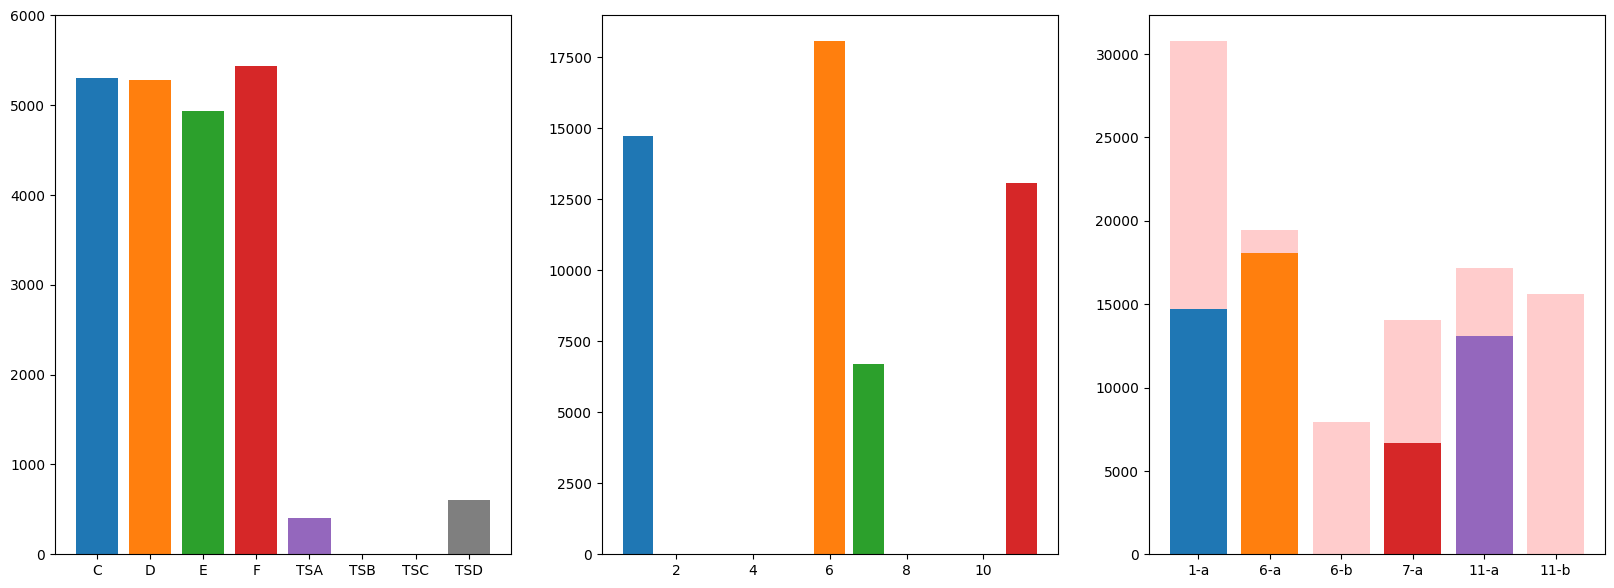

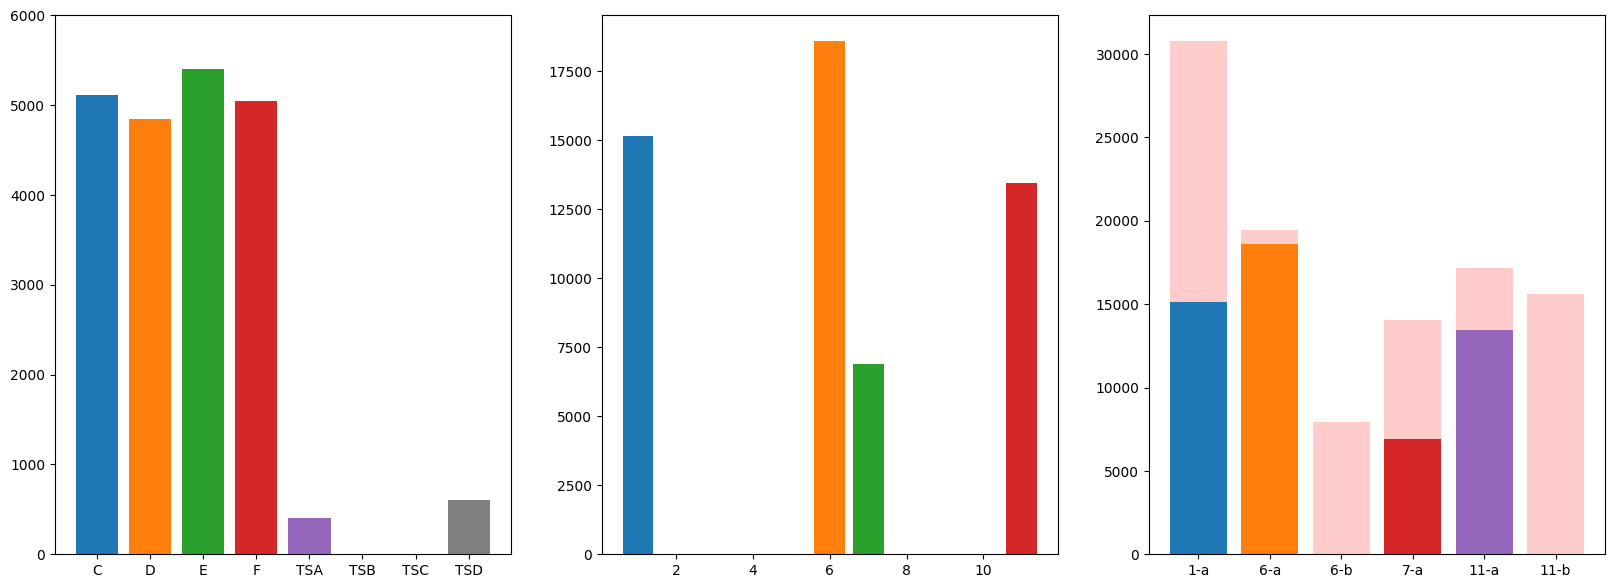

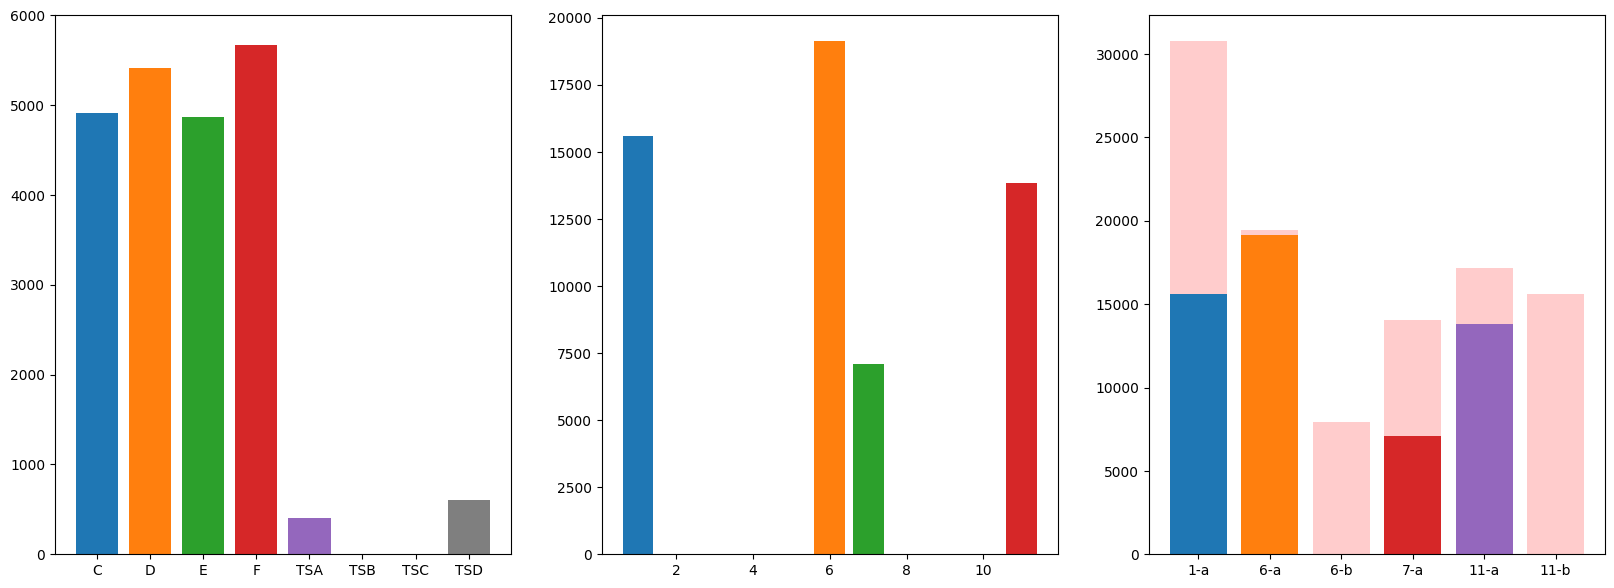

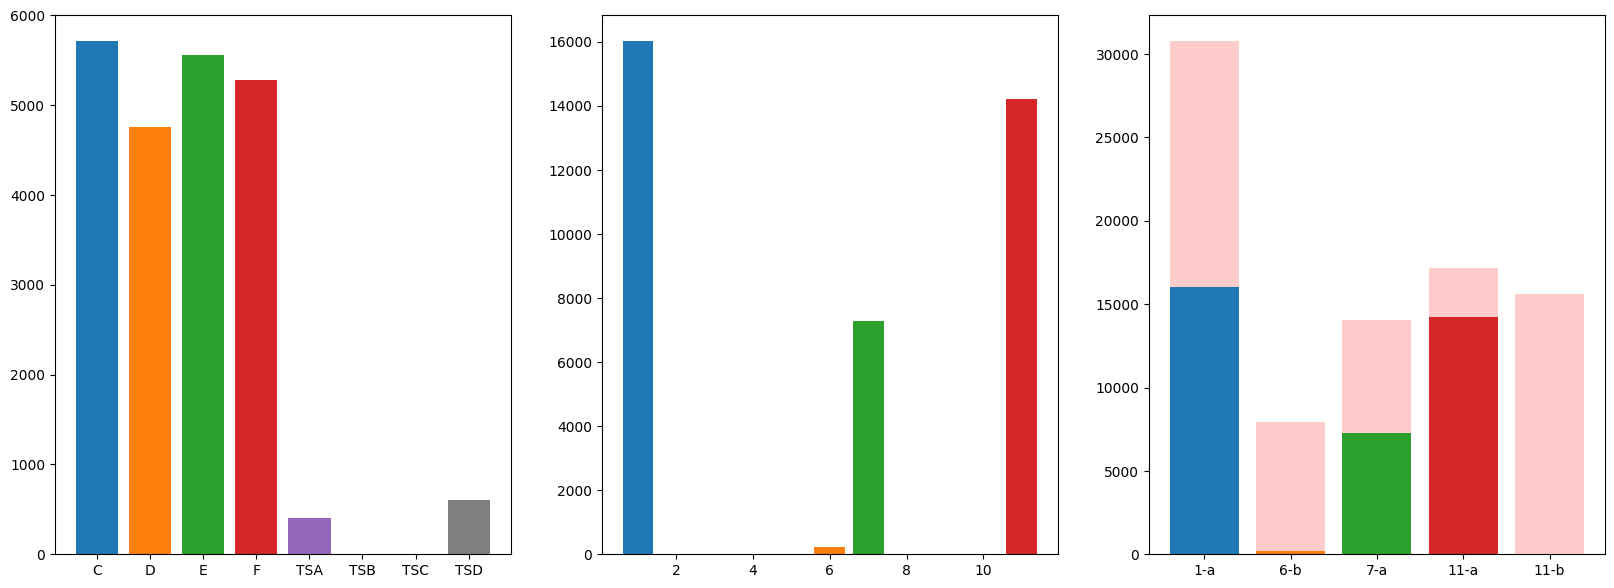

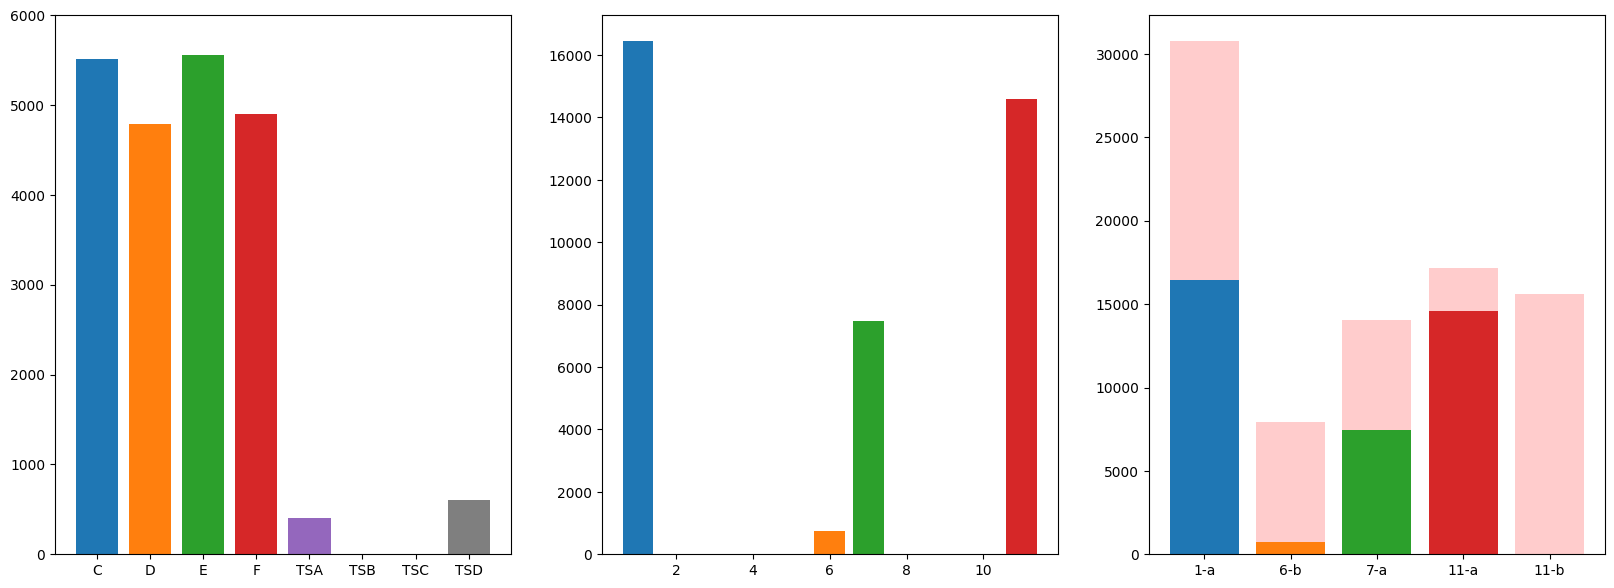

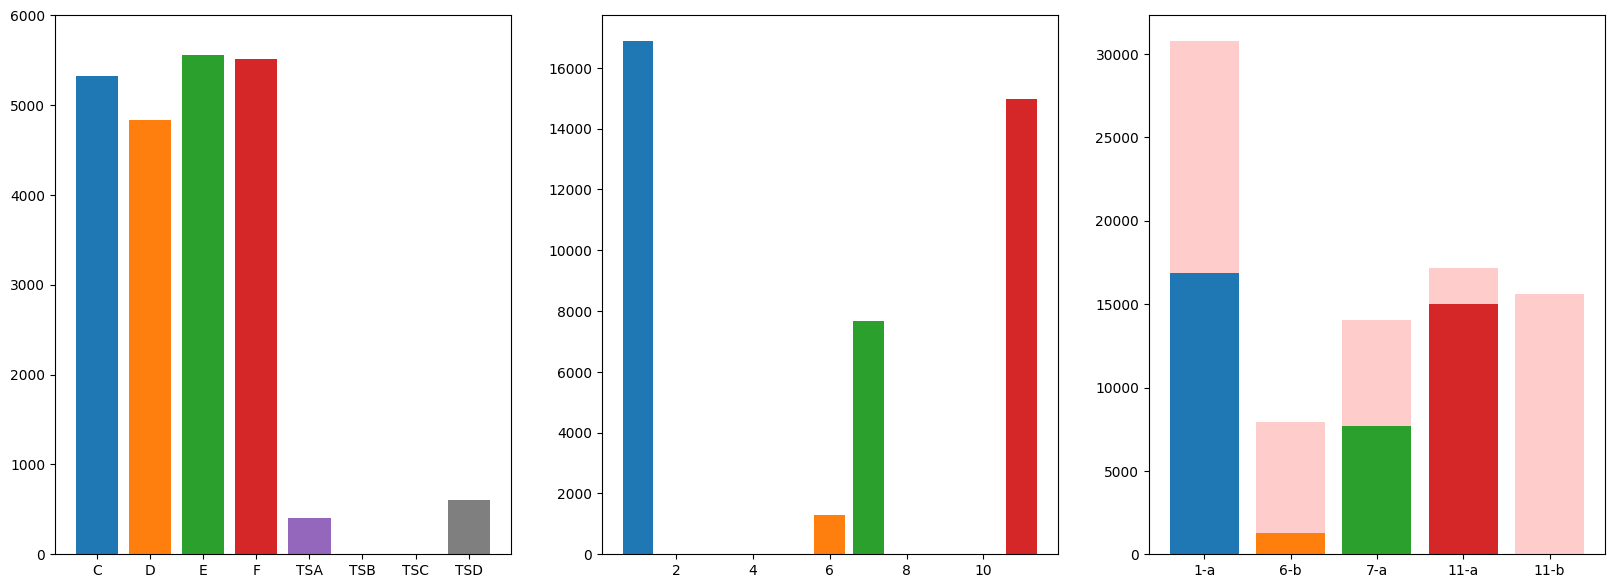

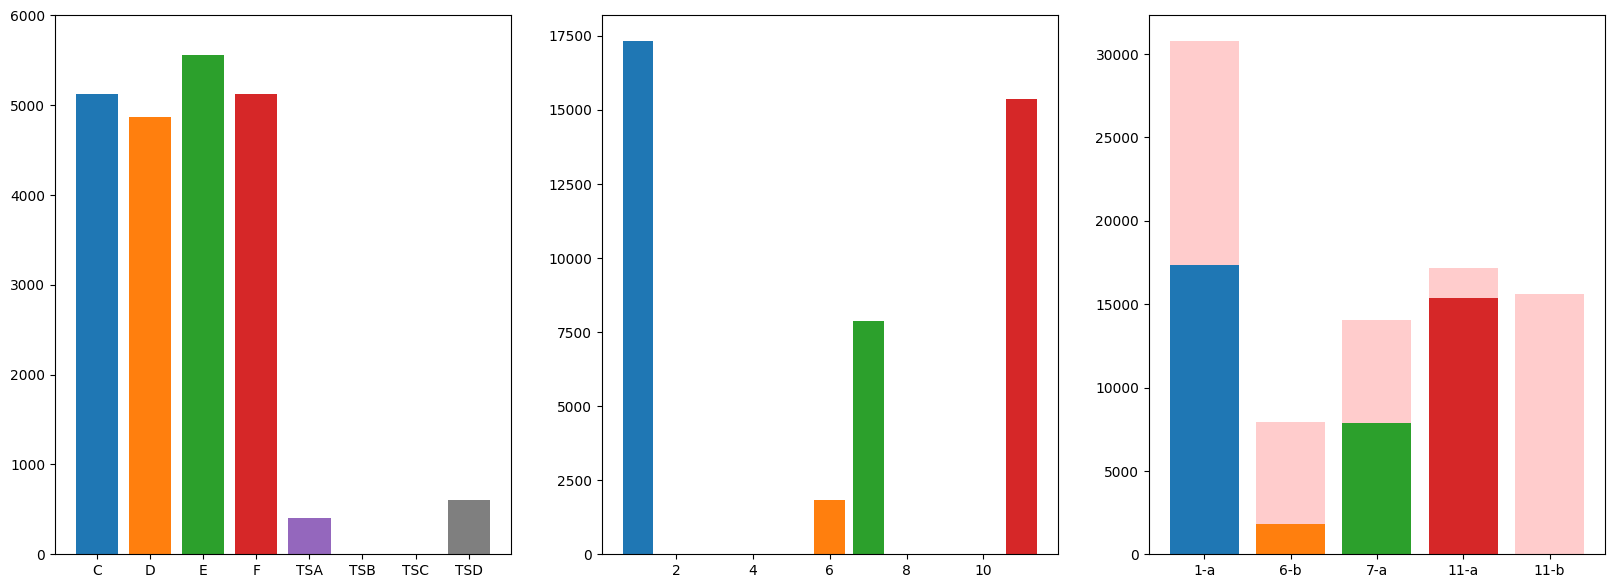

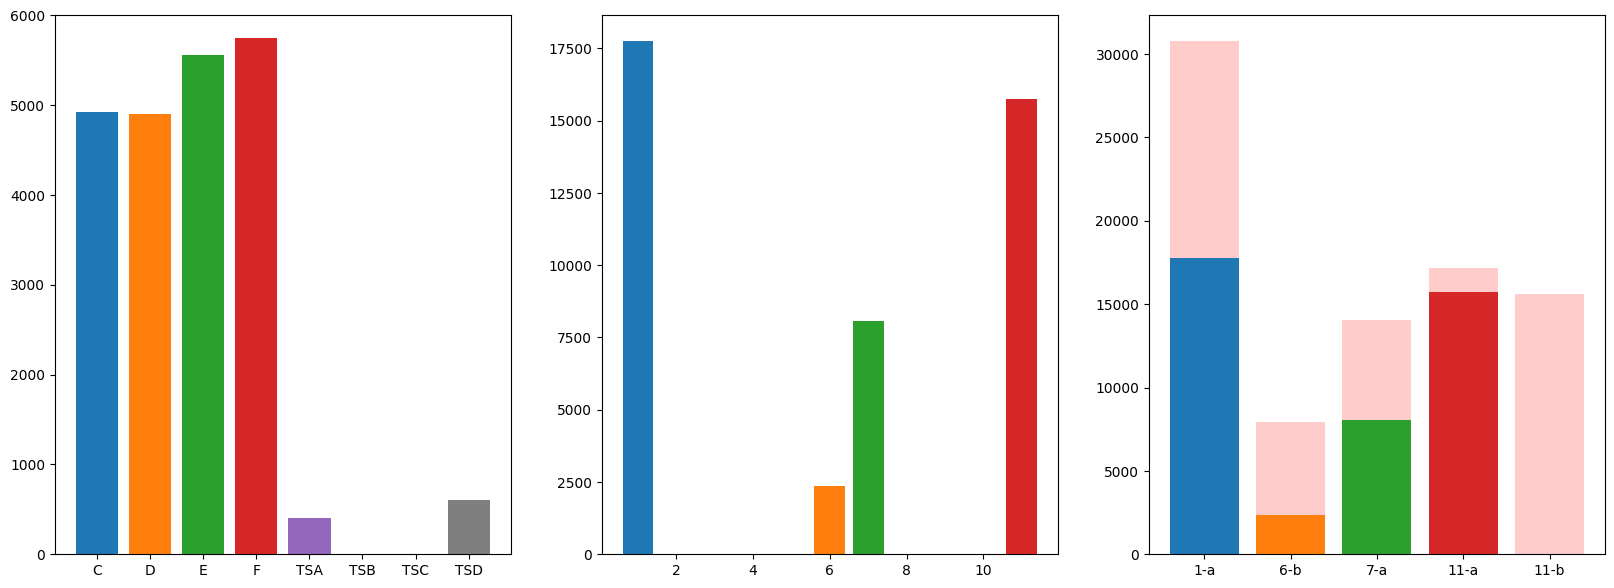

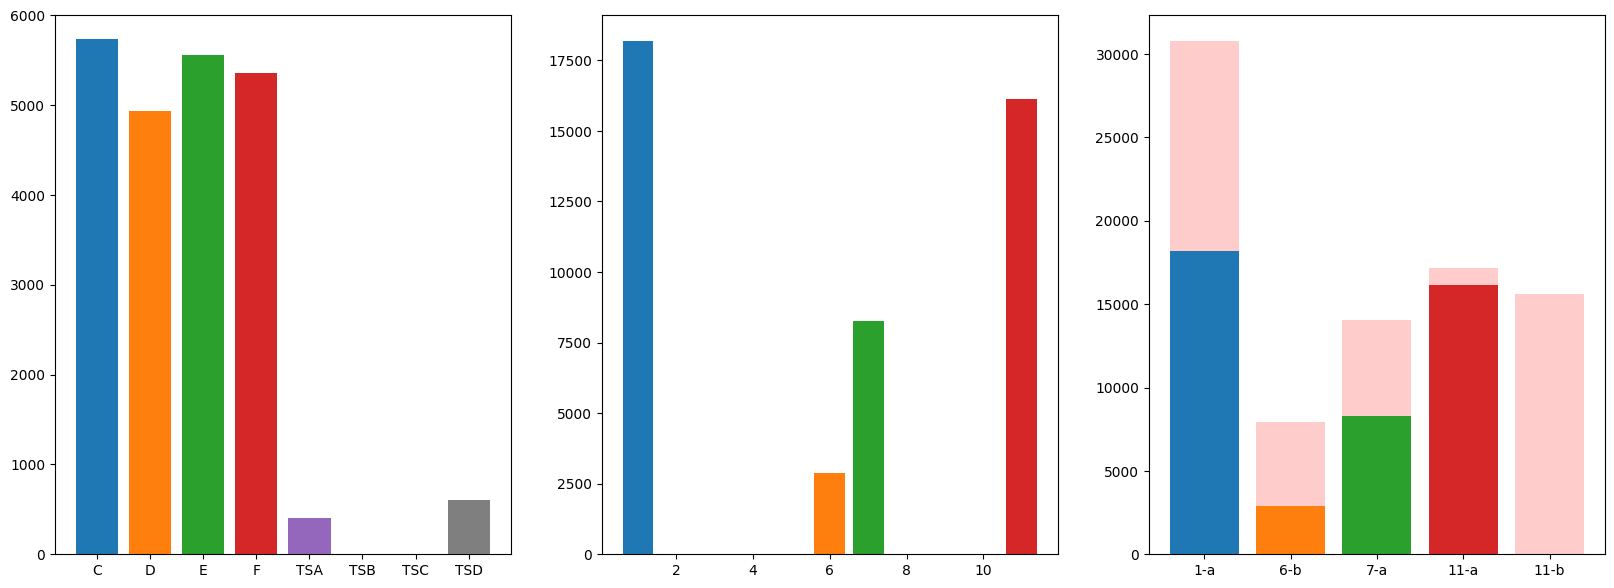

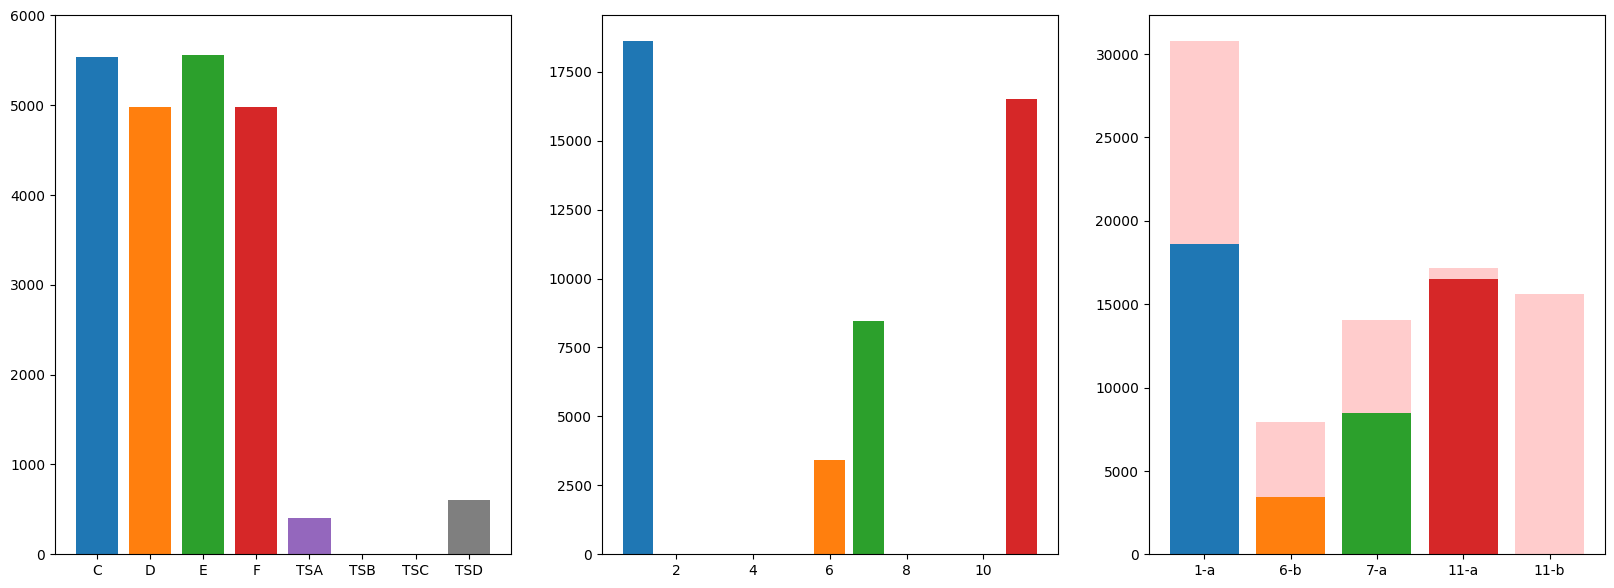

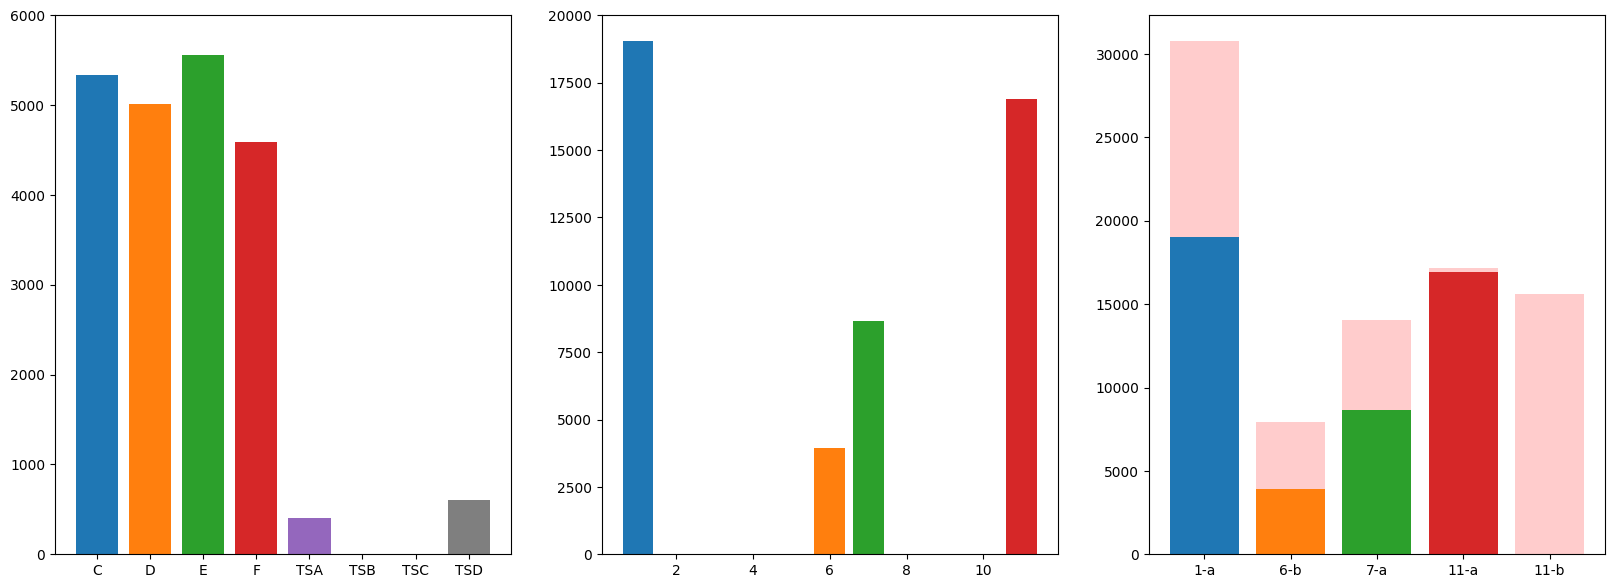

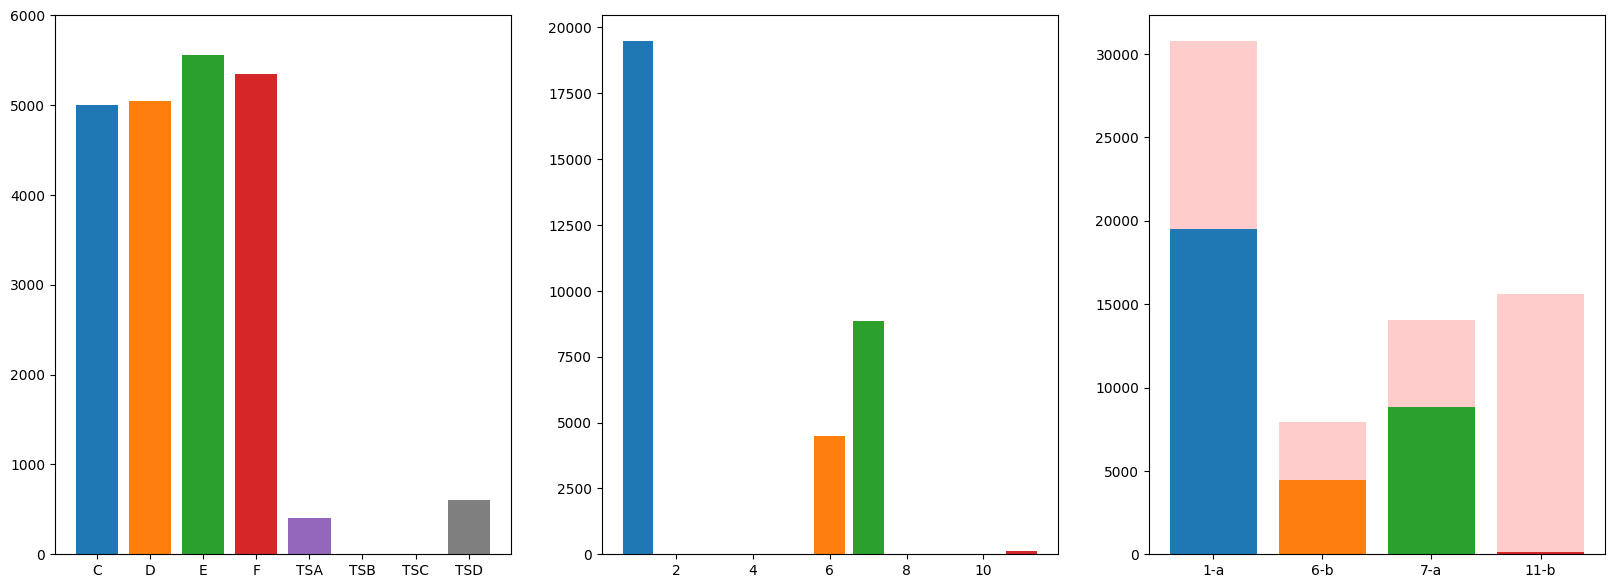

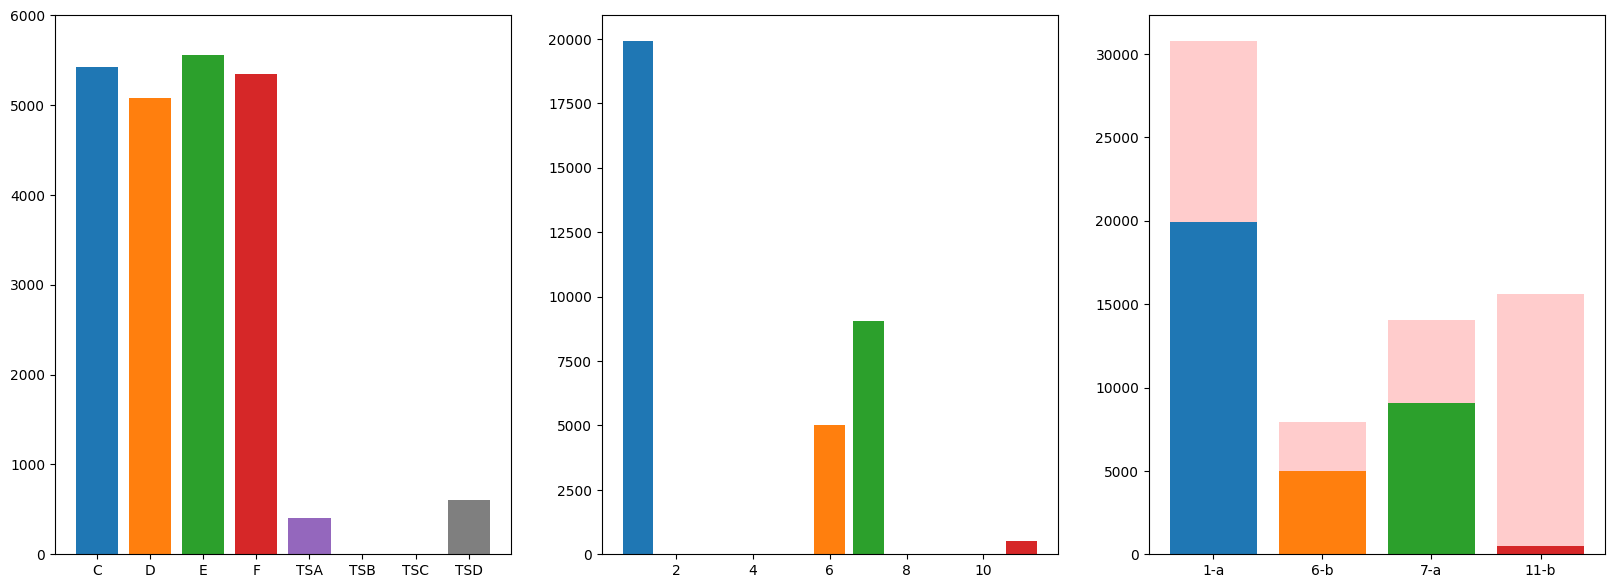

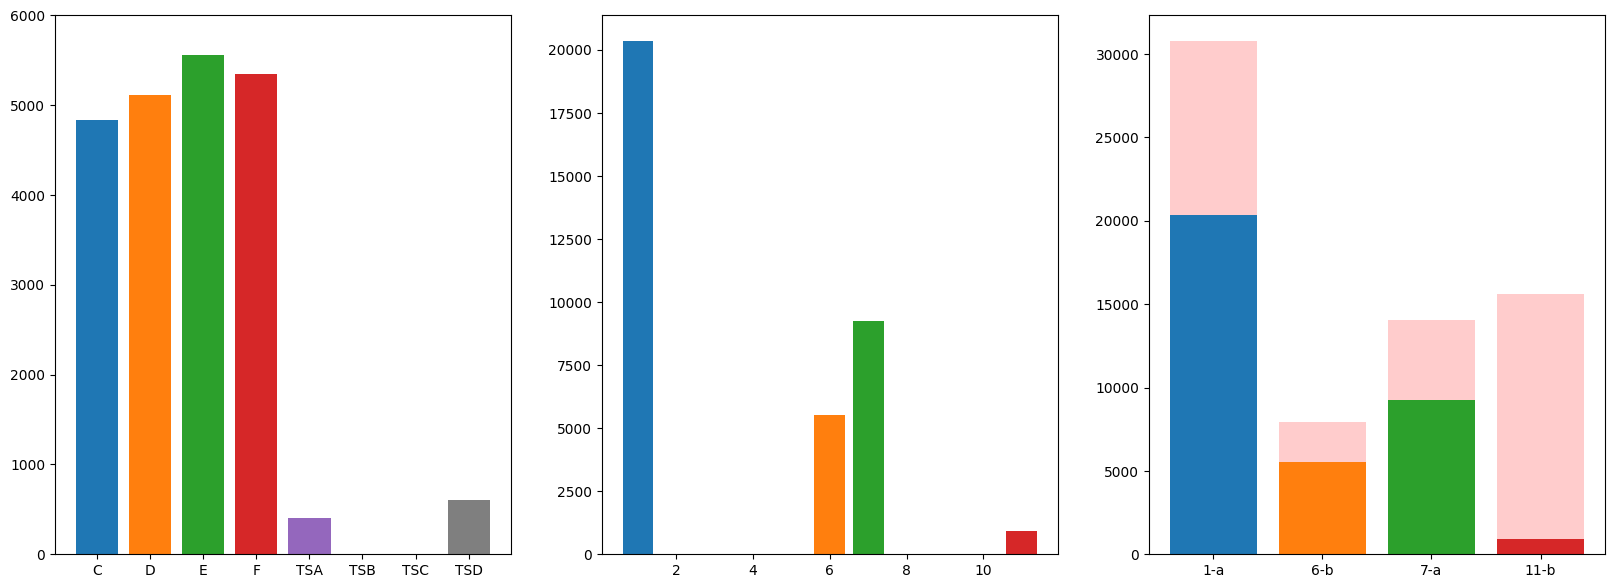

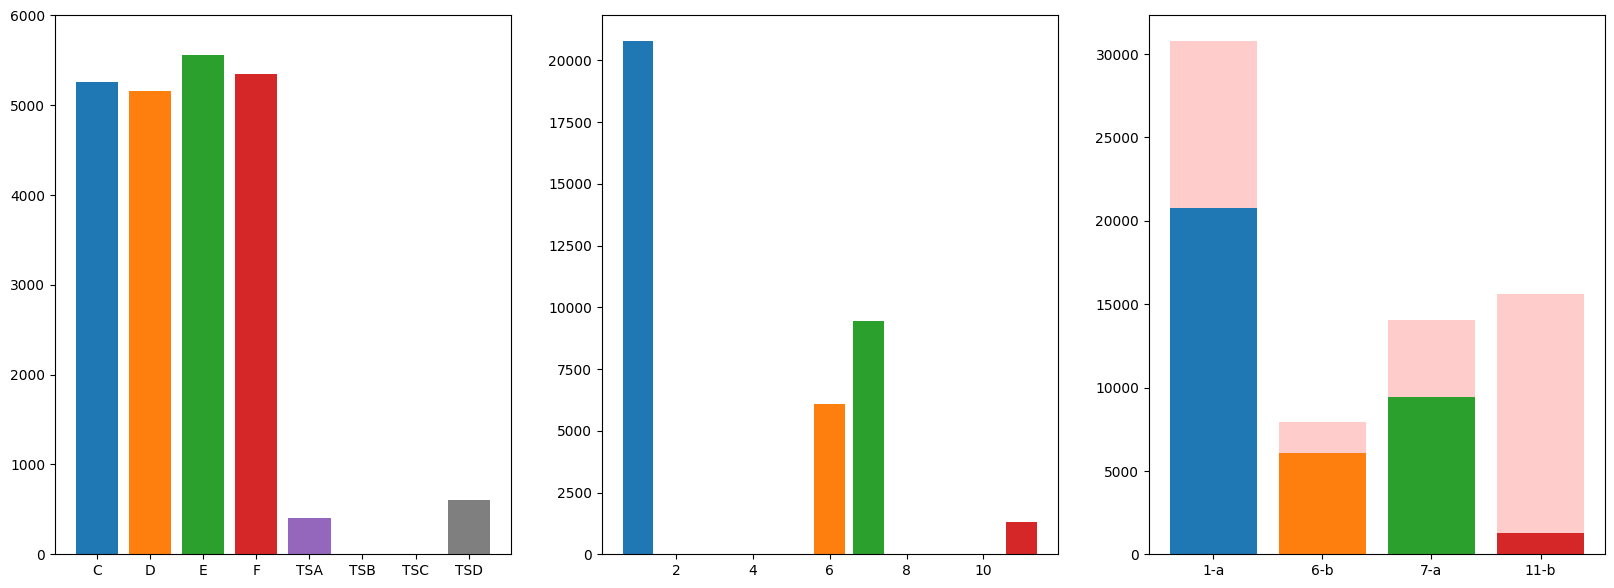

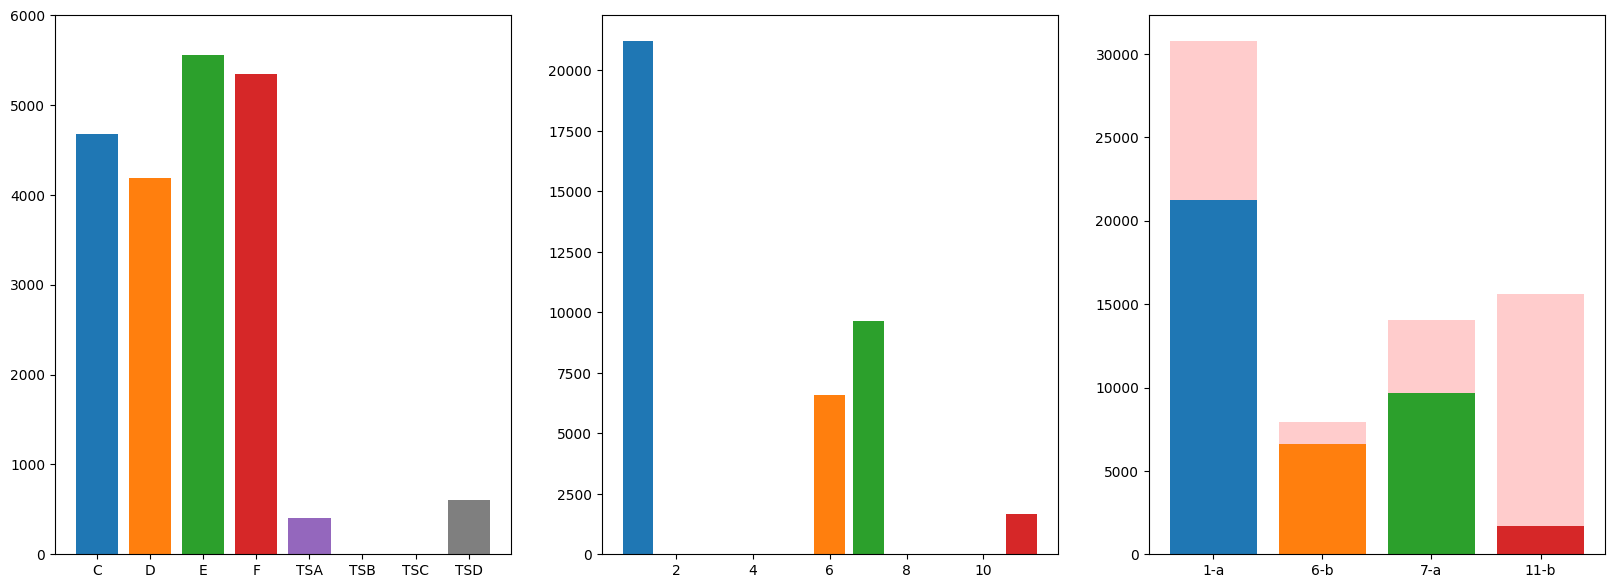

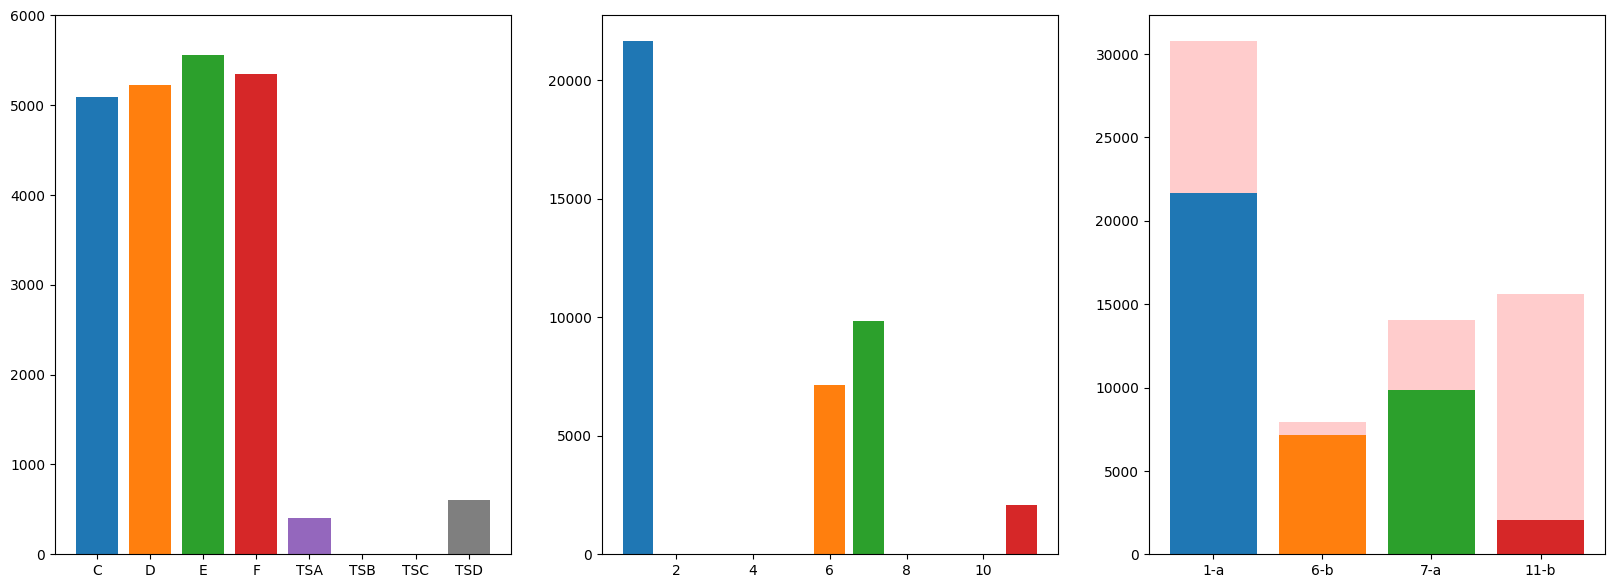

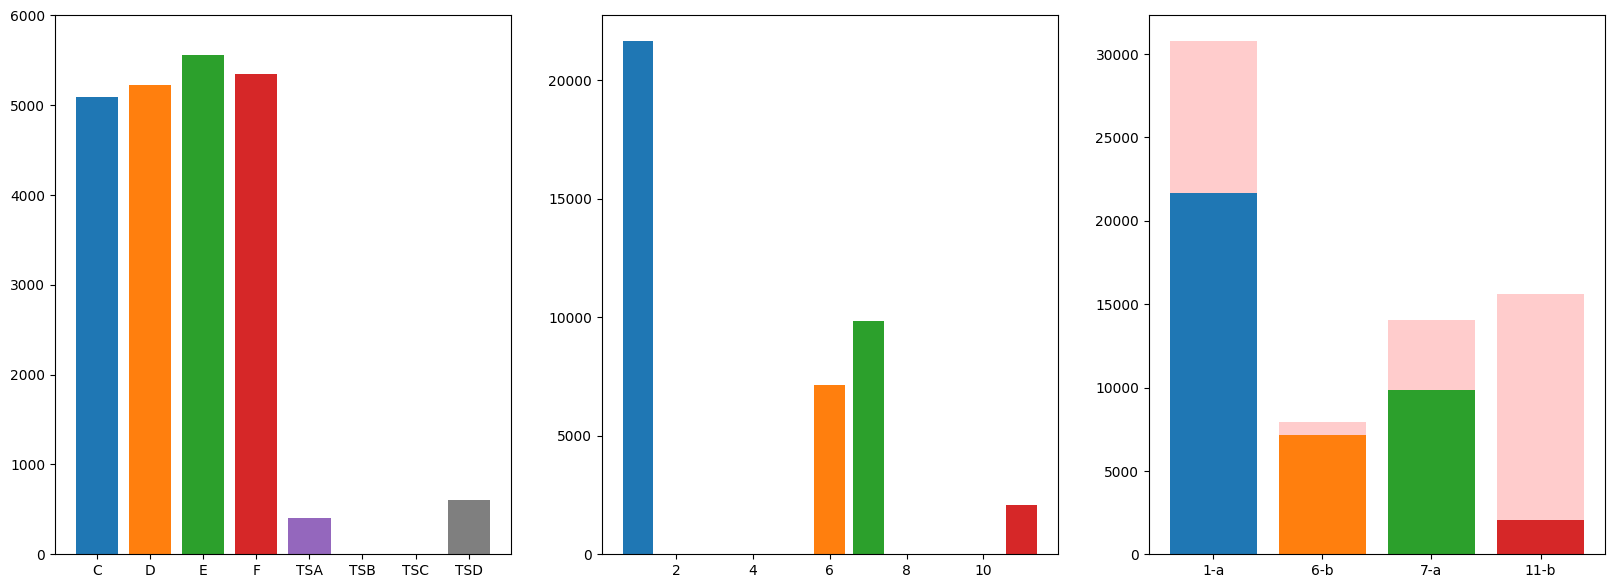

[]
Current timestamp 3000
timestamp 3000
5 steps
Current timestamp 3001
Current timestamp 3002
Current timestamp 3003
Current timestamp 3004
Current timestamp 3005
timestamp 3005
5 steps
Current timestamp 3006
Current timestamp 3007
Current timestamp 3008
Current timestamp 3009
Current timestamp 3010
timestamp 3010
5 steps
Current timestamp 3011
Current timestamp 3012
Current timestamp 3013
Current timestamp 3014
Current timestamp 3015
timestamp 3015
5 steps
Current timestamp 3016
Current timestamp 3017
Current timestamp 3018
Current timestamp 3019
Current timestamp 3020
timestamp 3020
5 steps
Current timestamp 3021
Current timestamp 3022
Current timestamp 3023
Current timestamp 3024
checking silos
The silo: D 4840.25333333381
timestamp 3024
Current timestamp 3025
B0001 B0001
True
adding
5824.186666667143
timestamp 3025
5 steps
Current timestamp 3026
Current timestamp 3027
Current timestamp 3028
Current timestamp 3029
Current timestamp 3030
B0001 B0001
True
adding
5743.85333333381
time

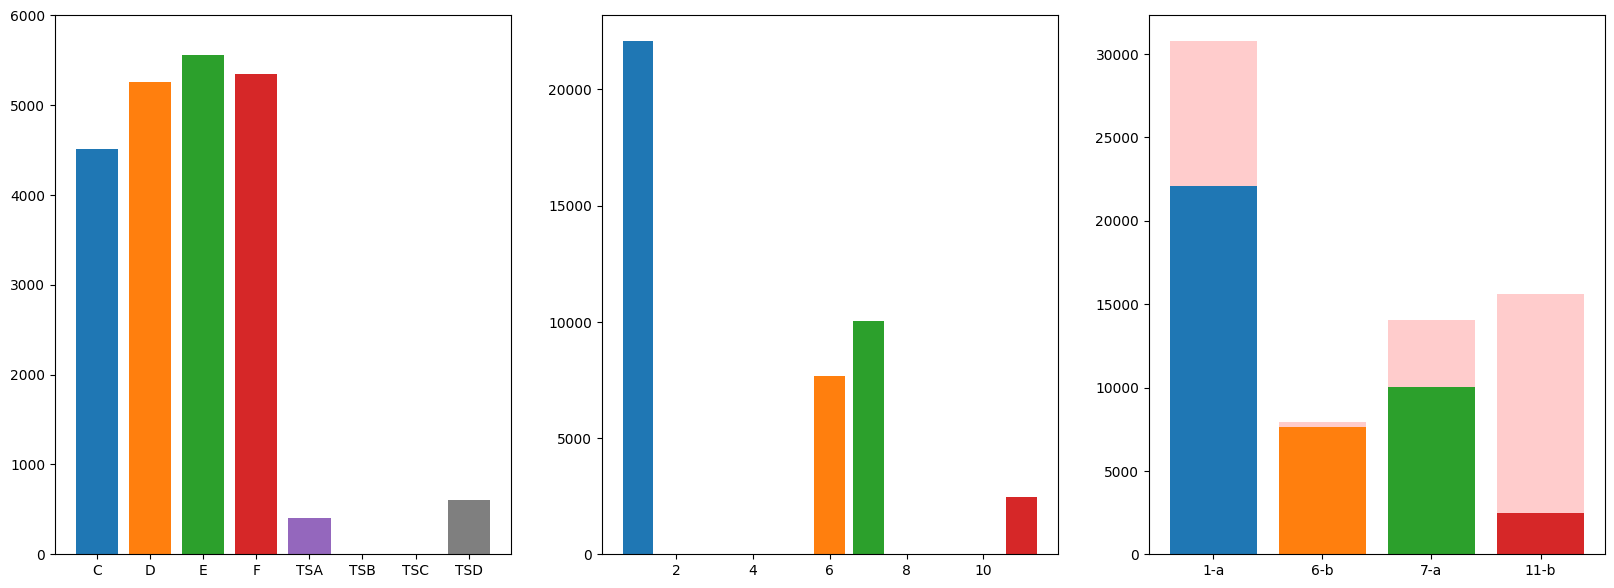

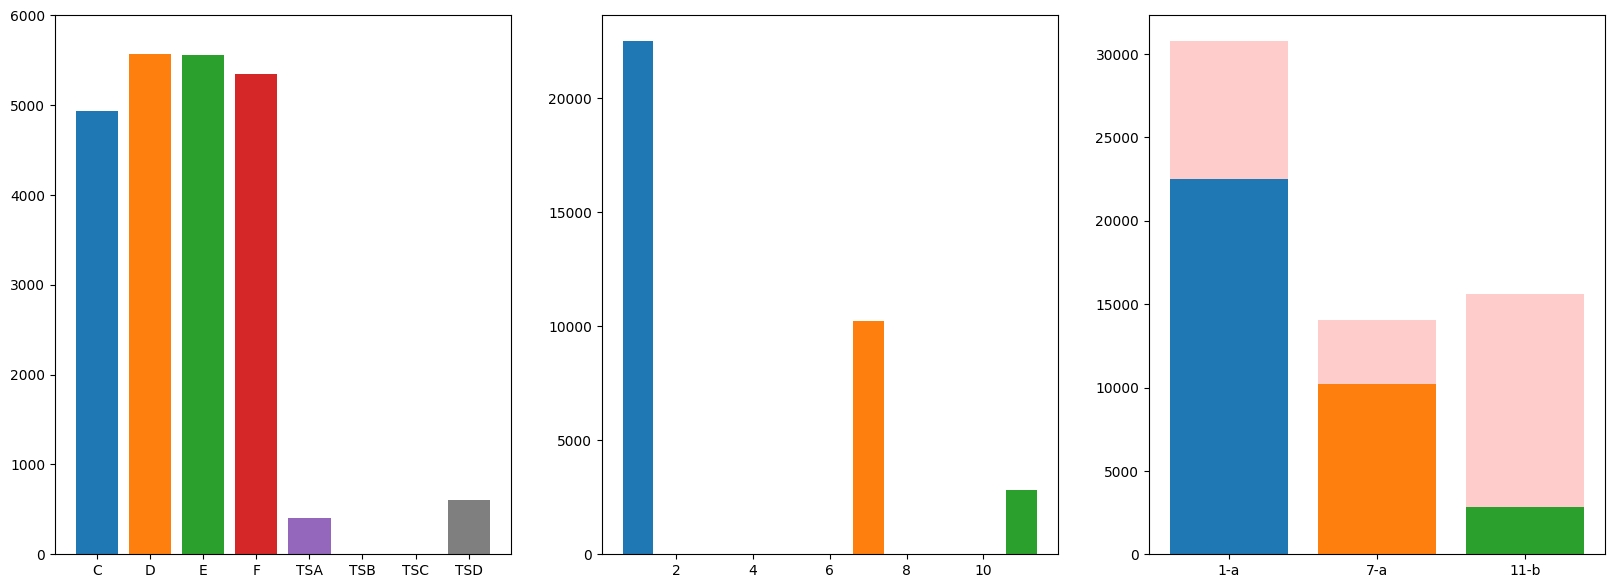

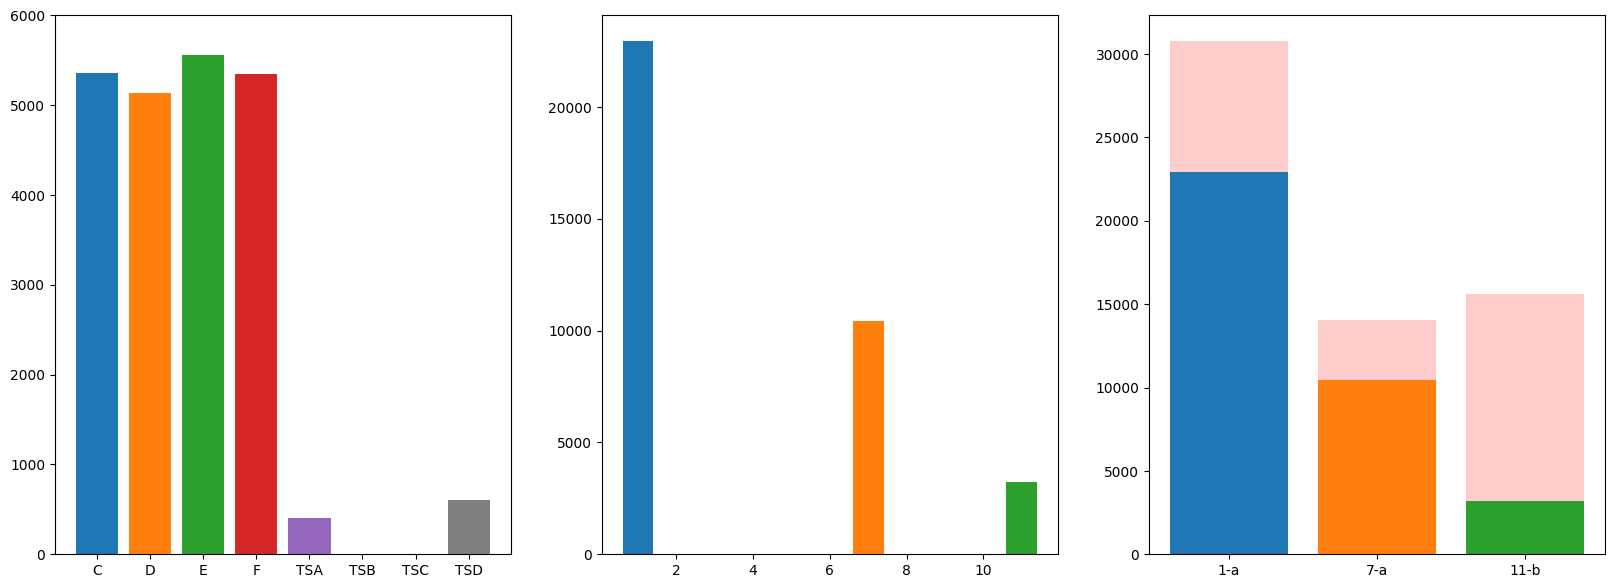

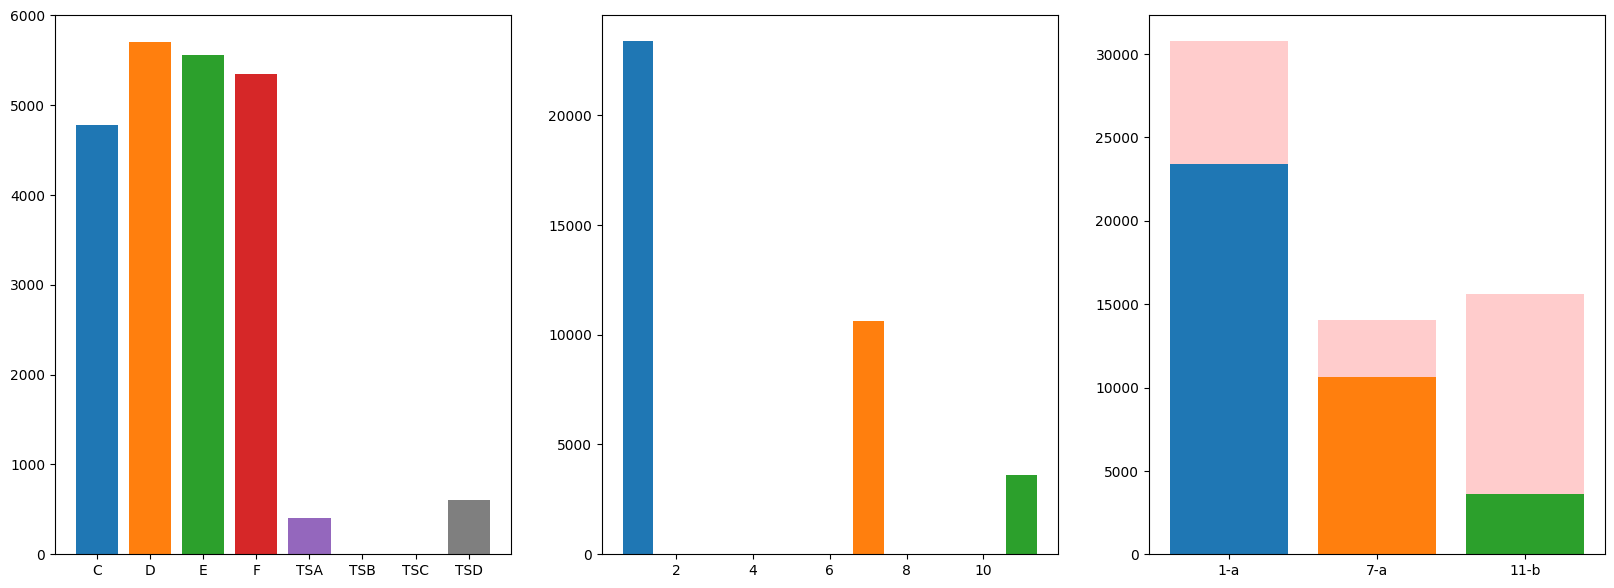

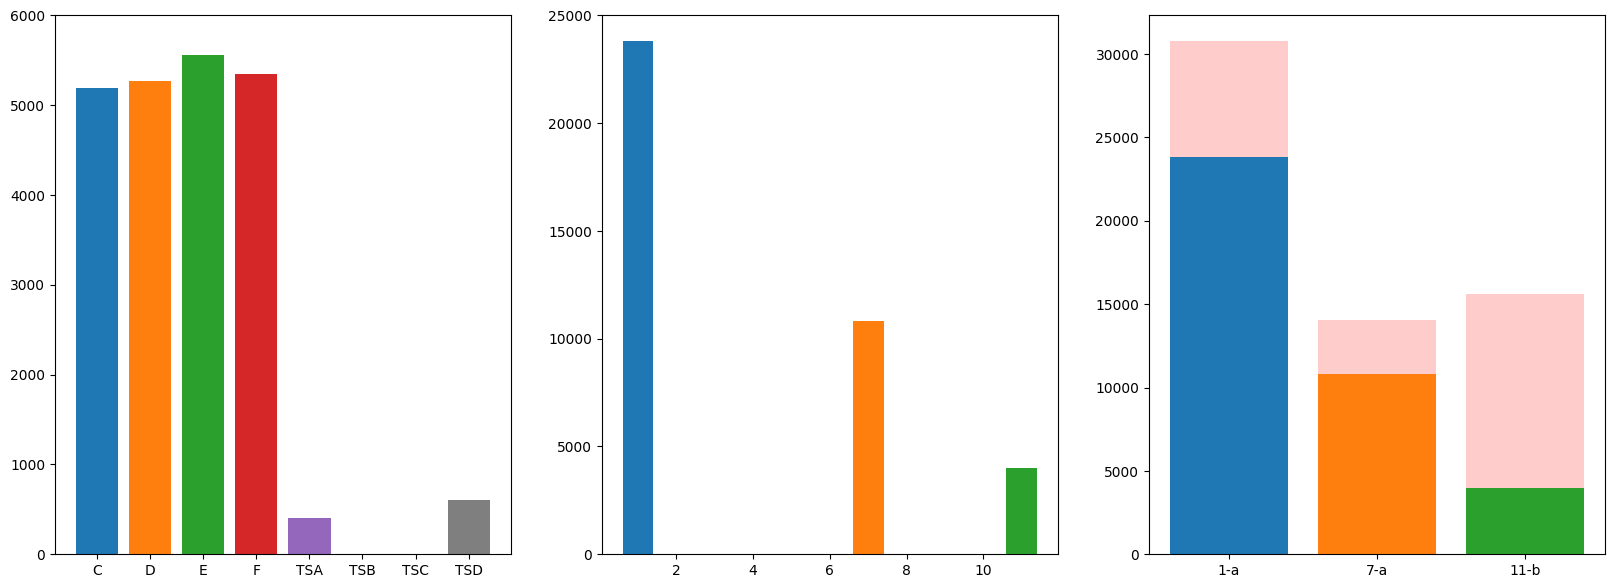

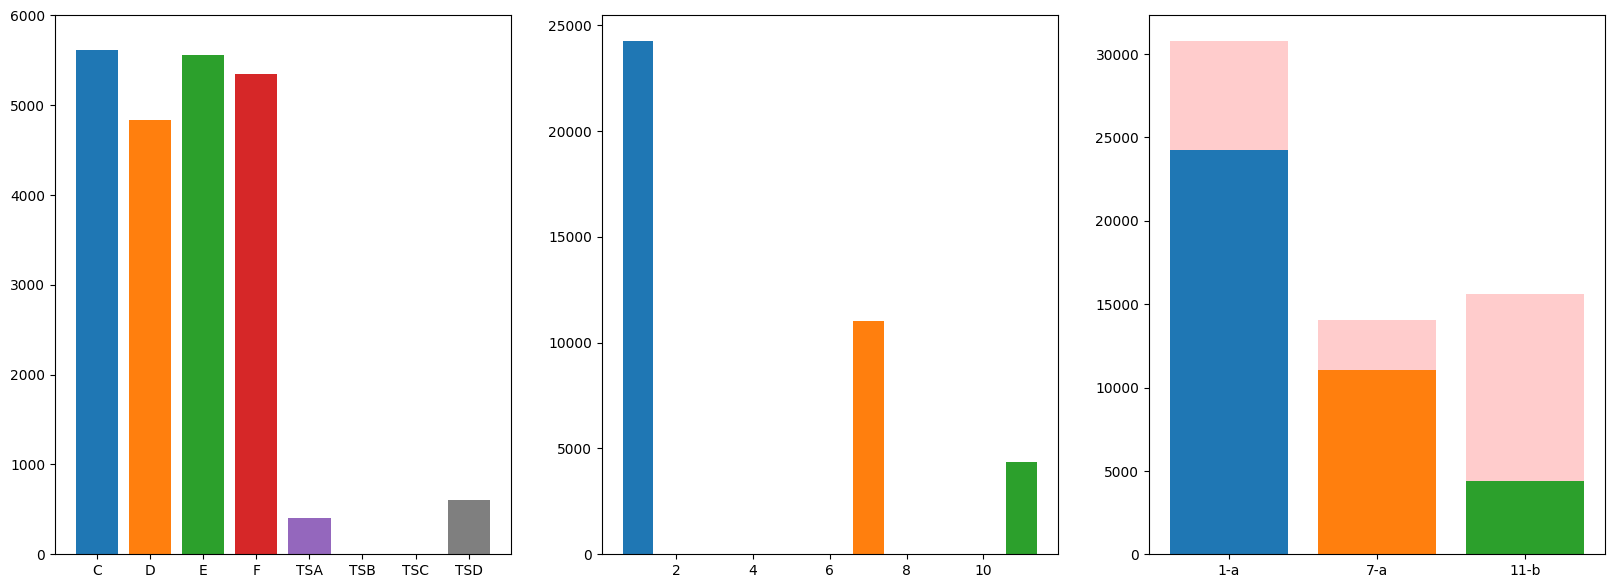

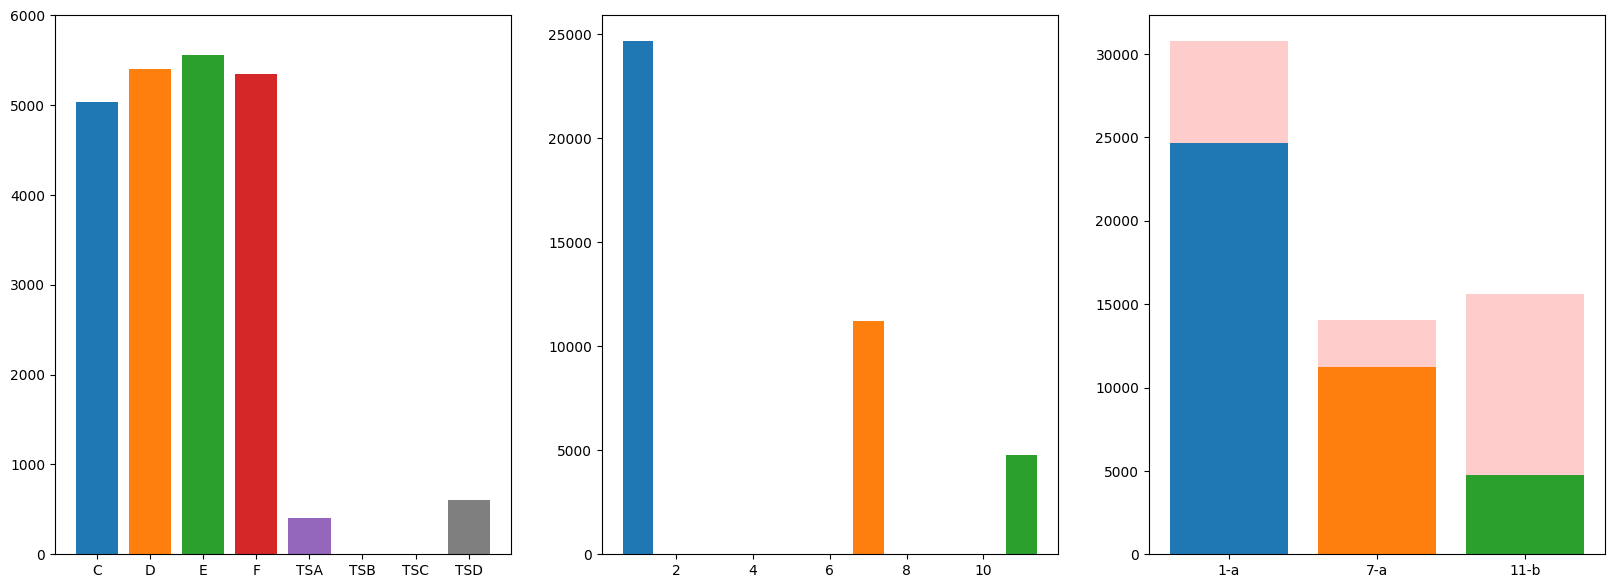

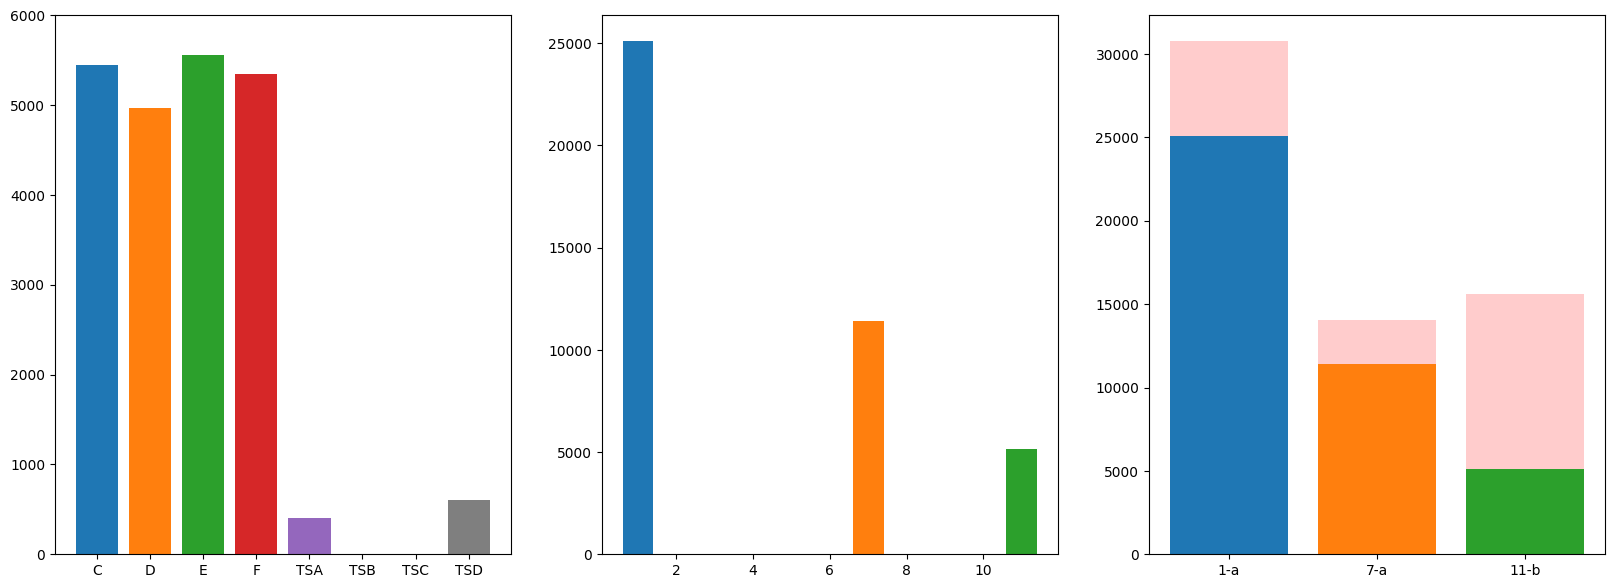

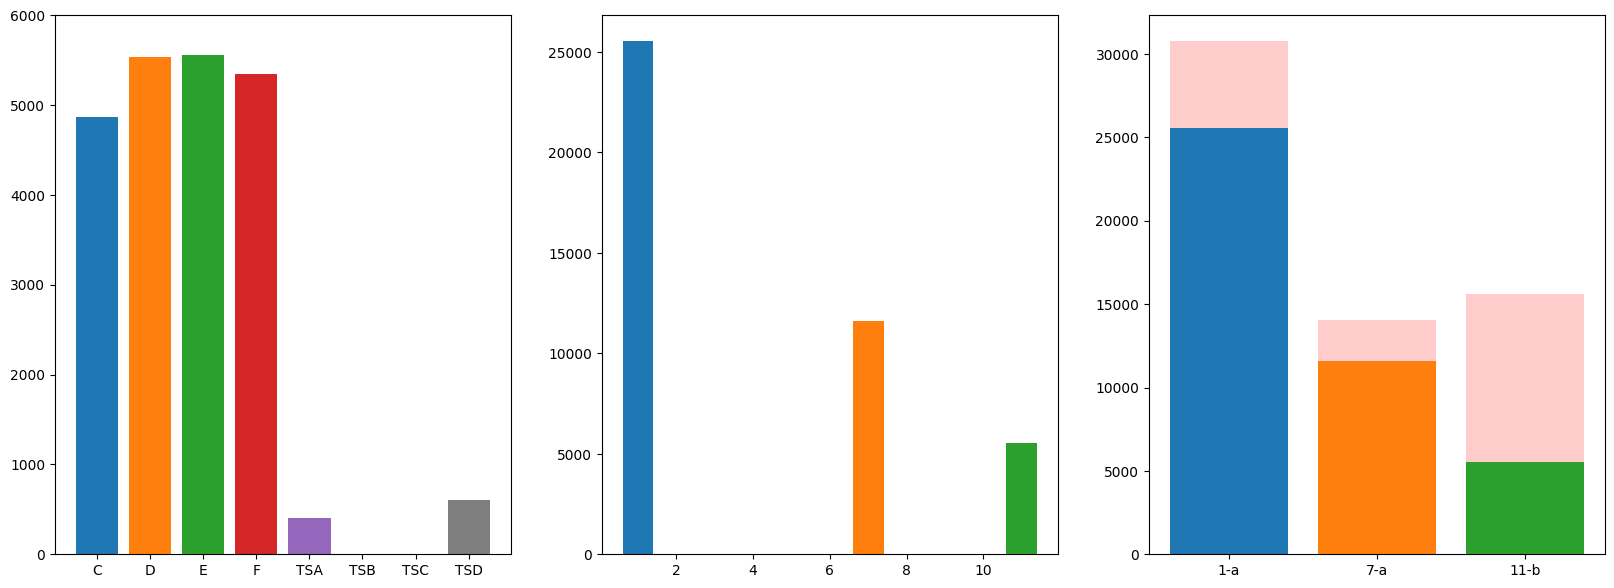

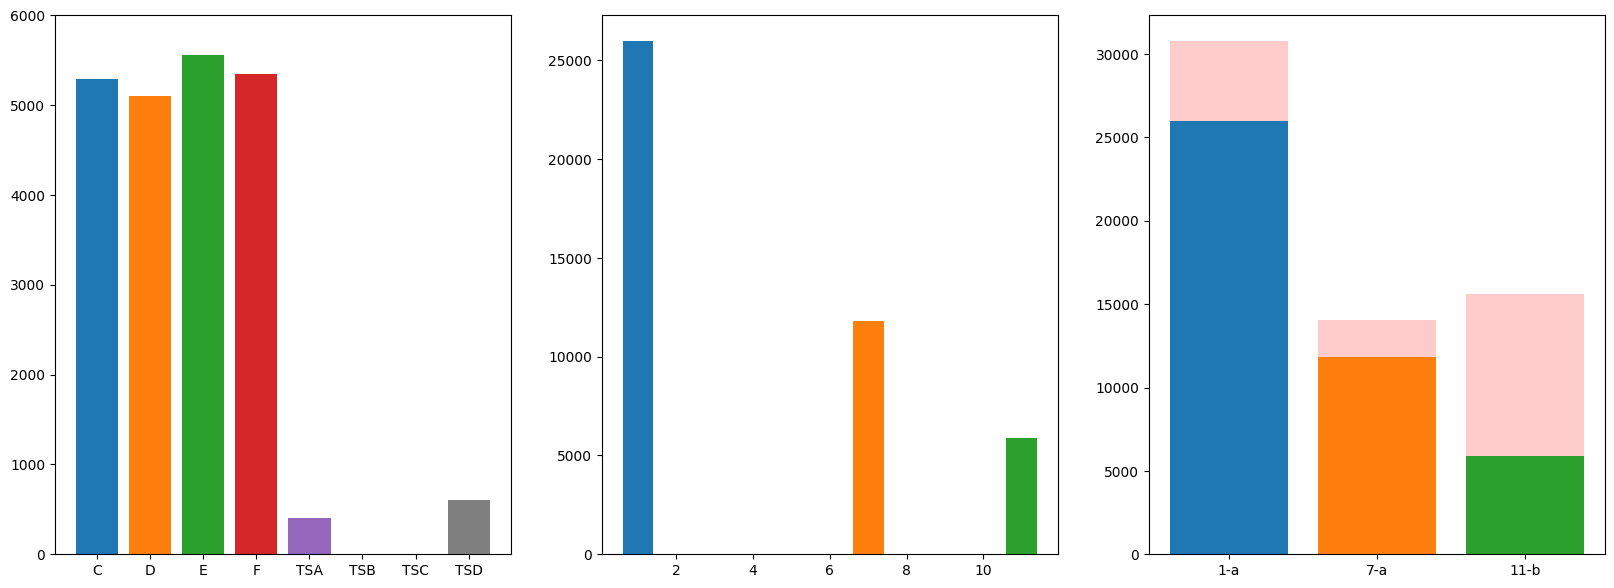

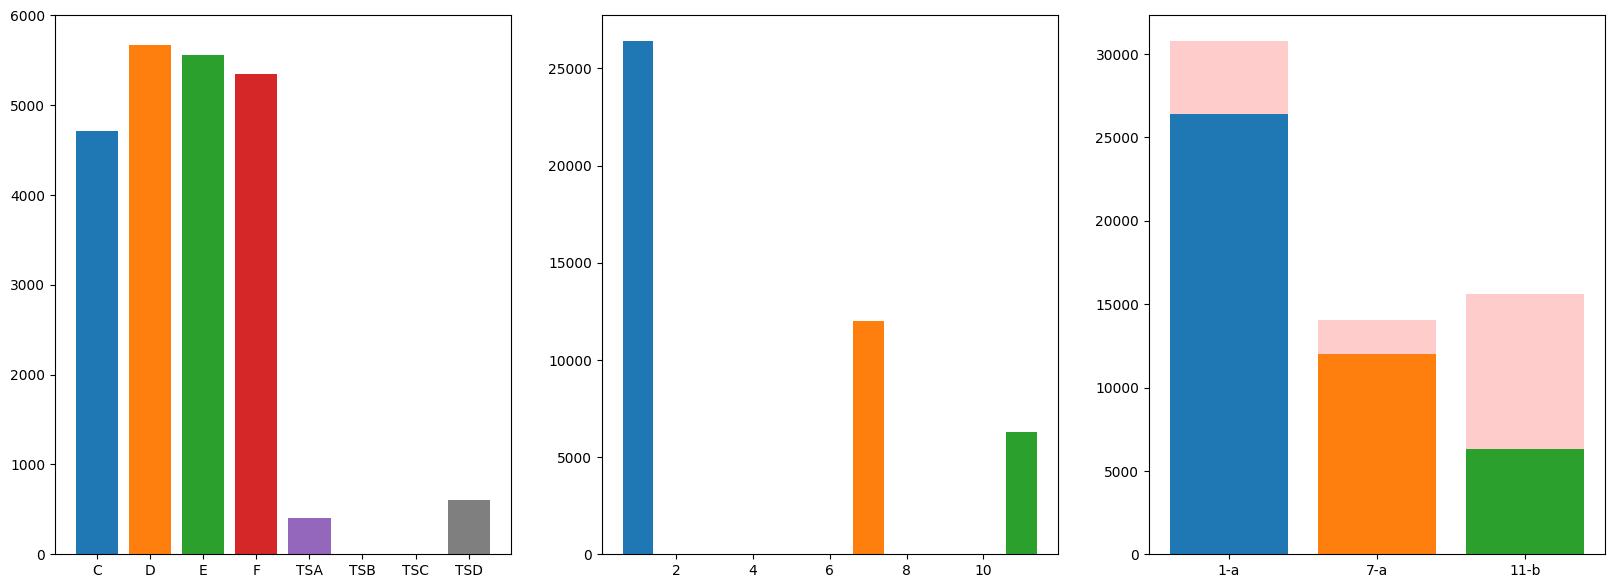

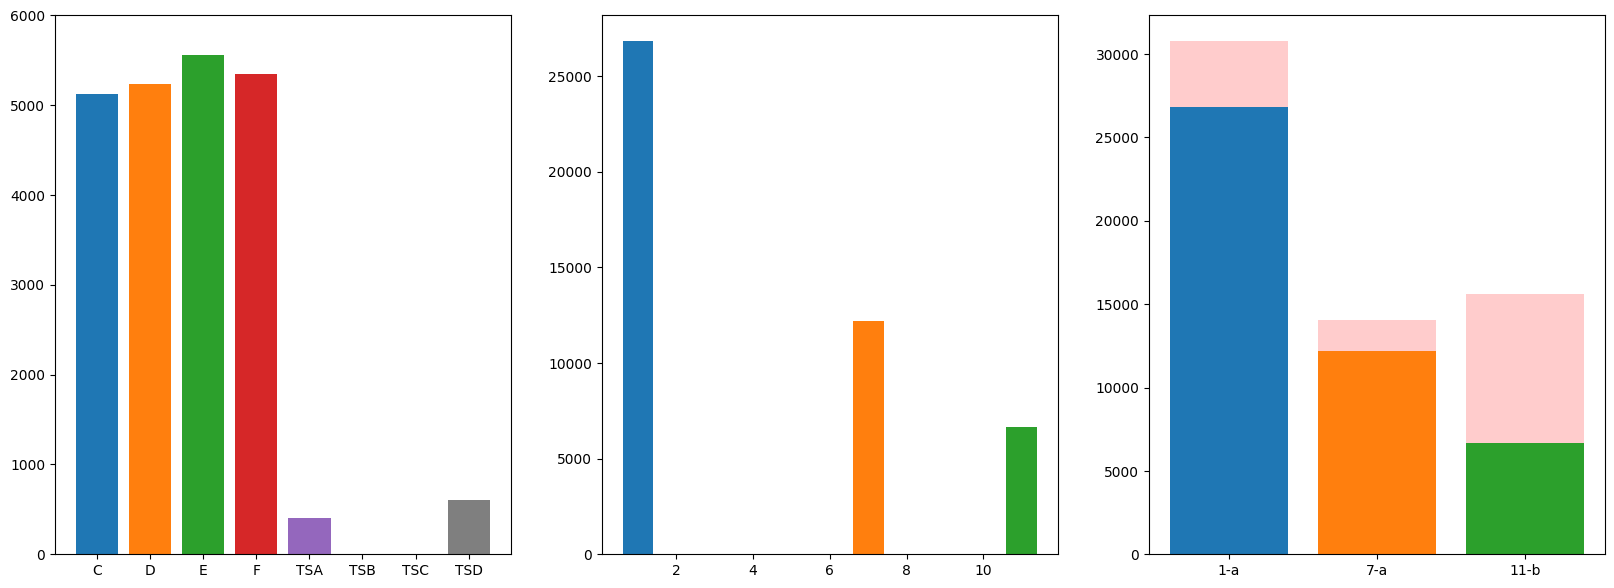

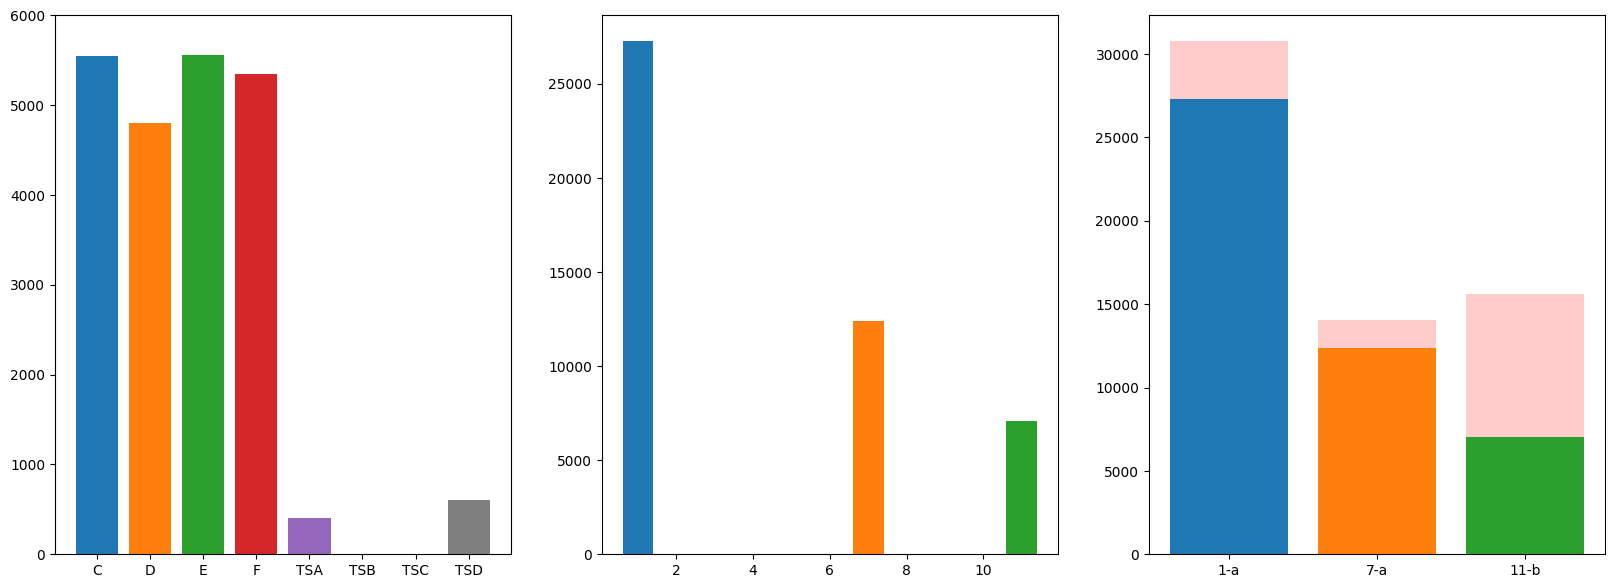

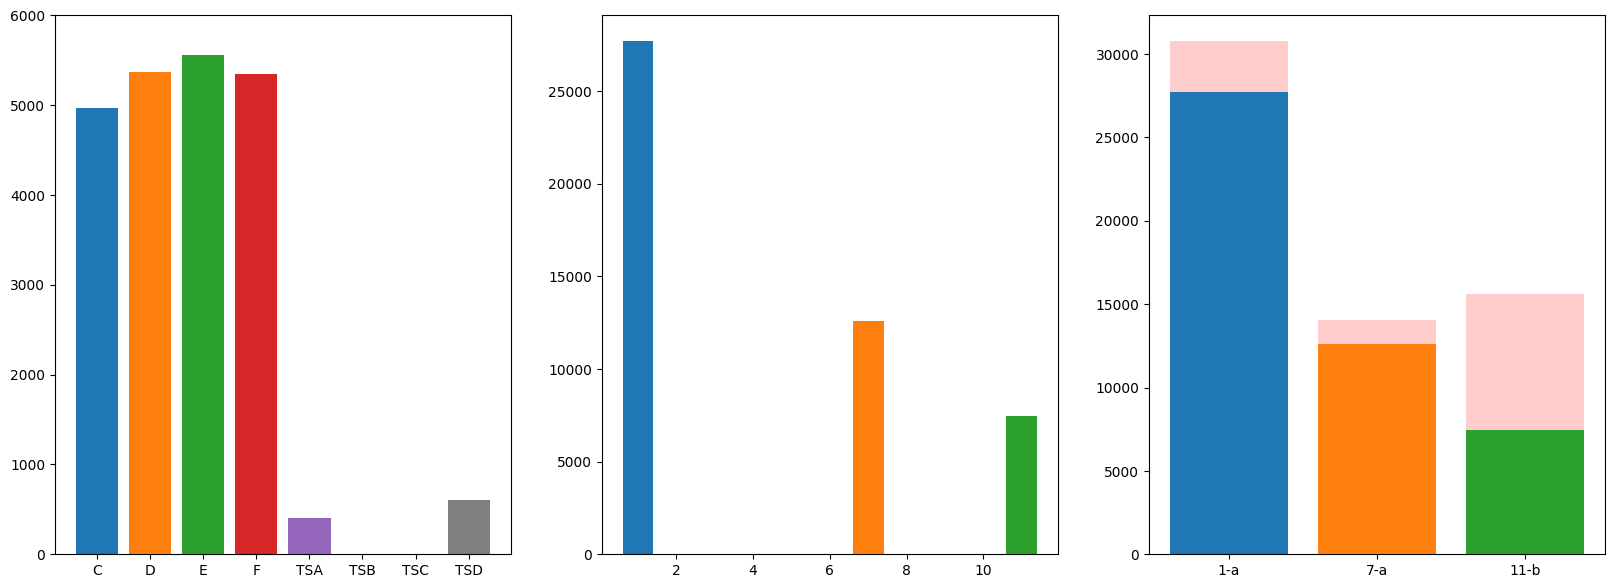

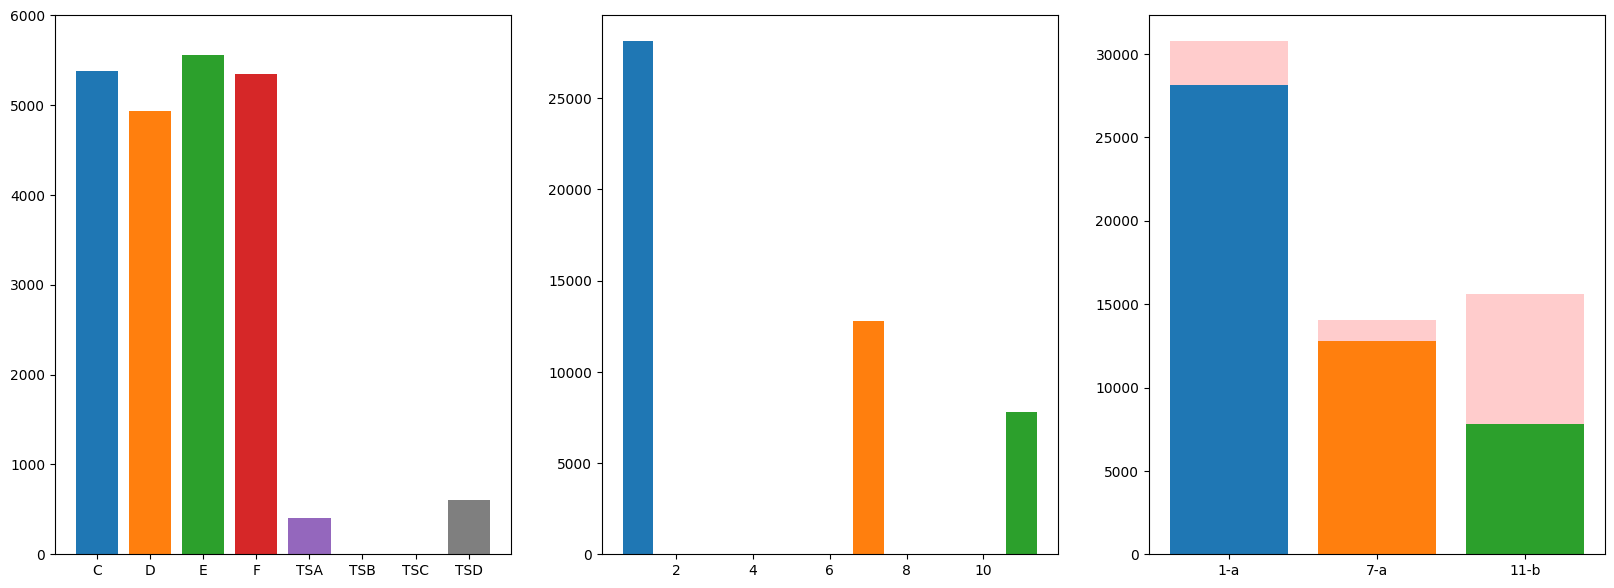

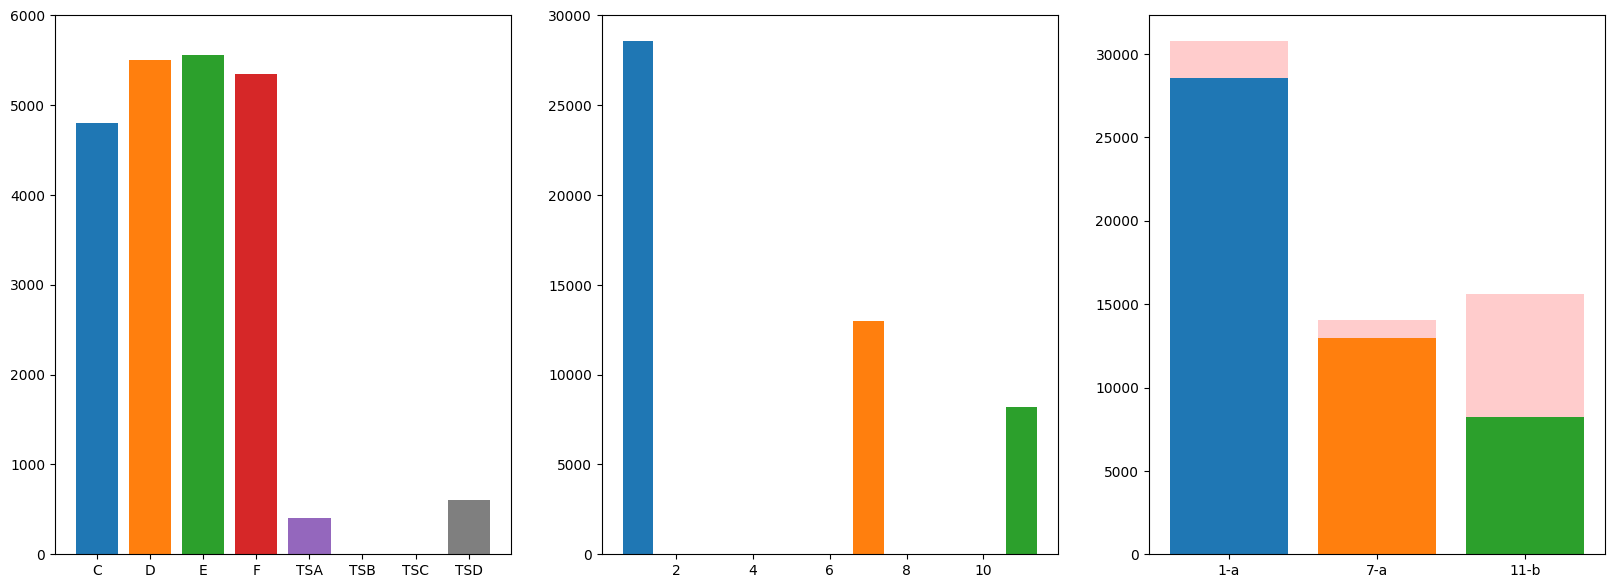

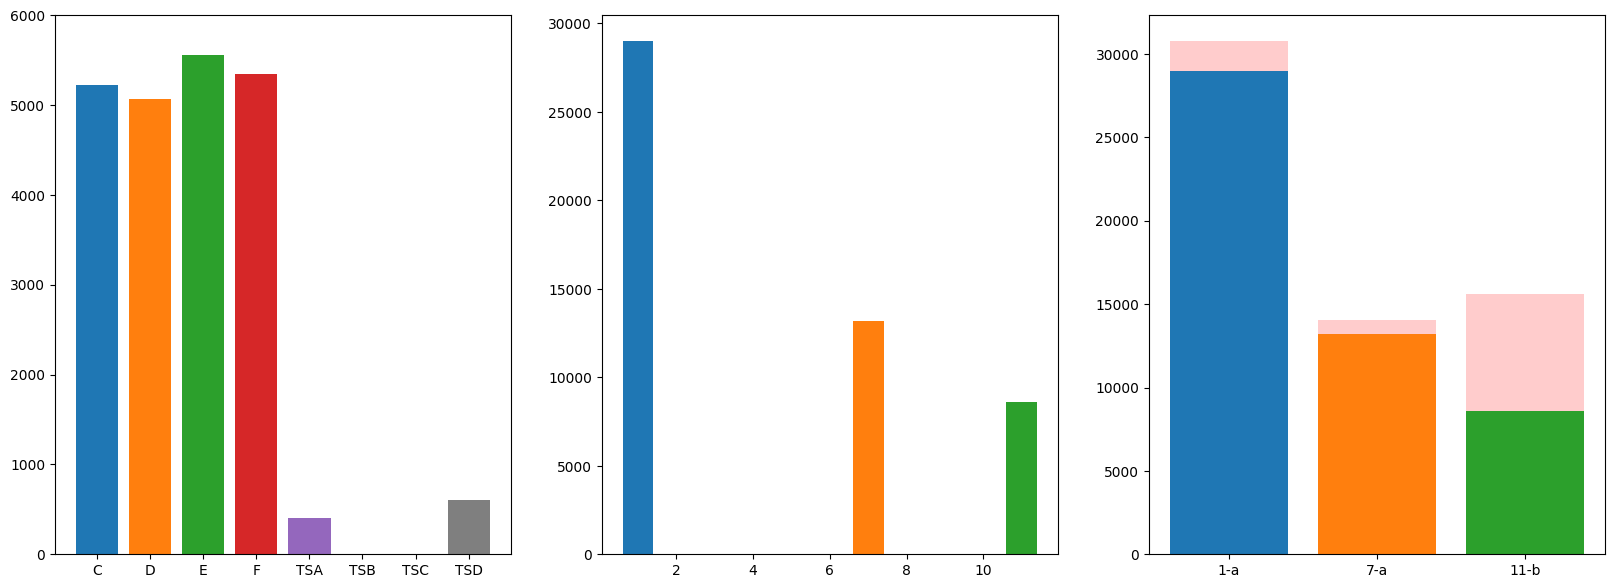

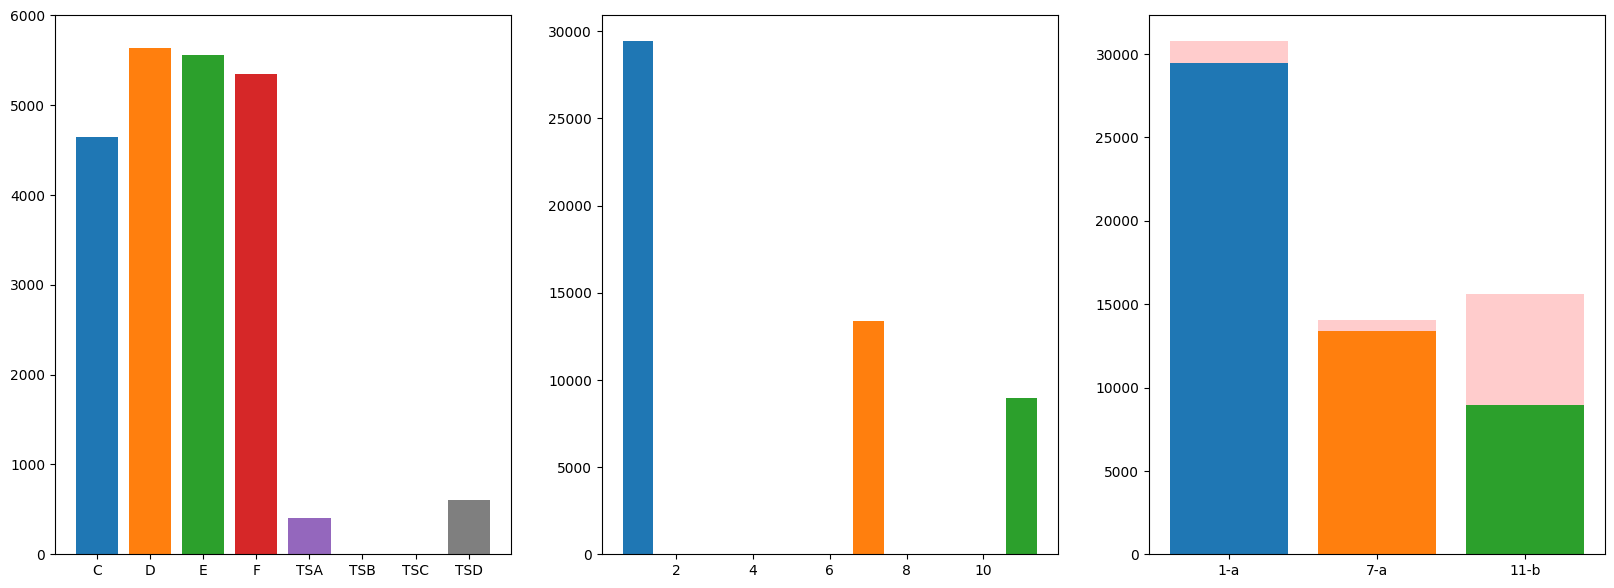

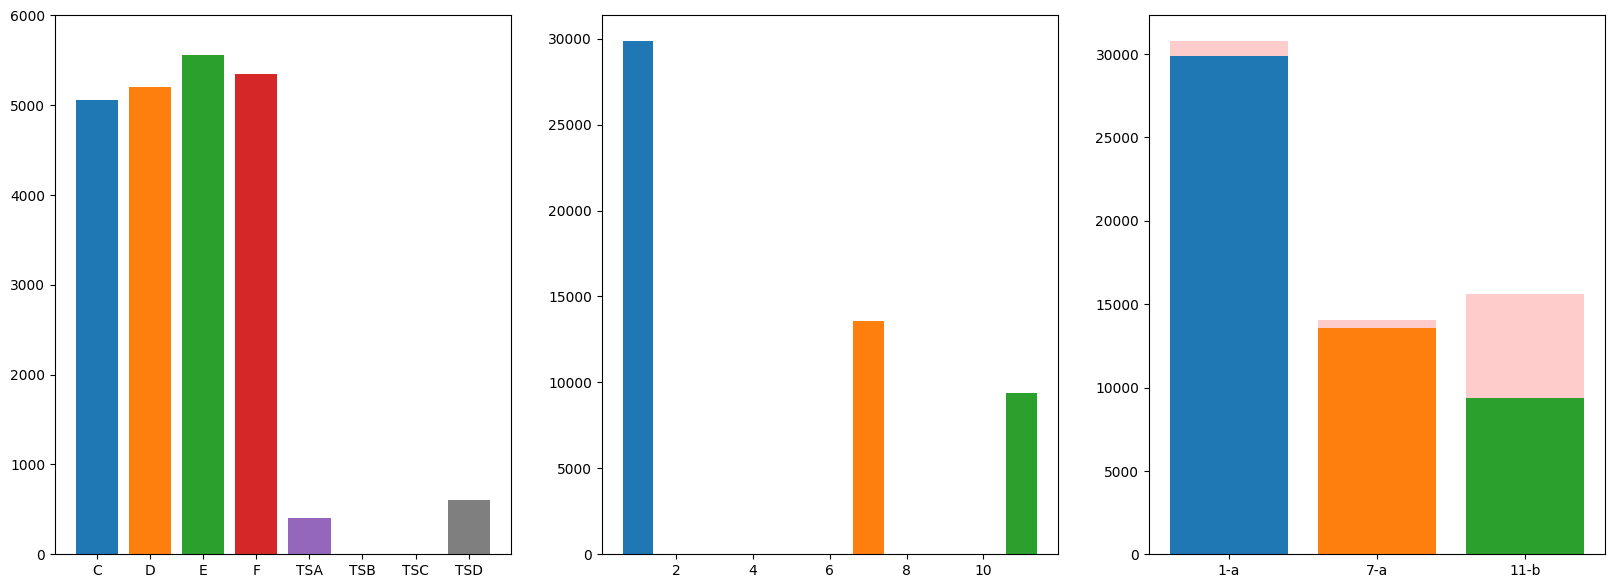

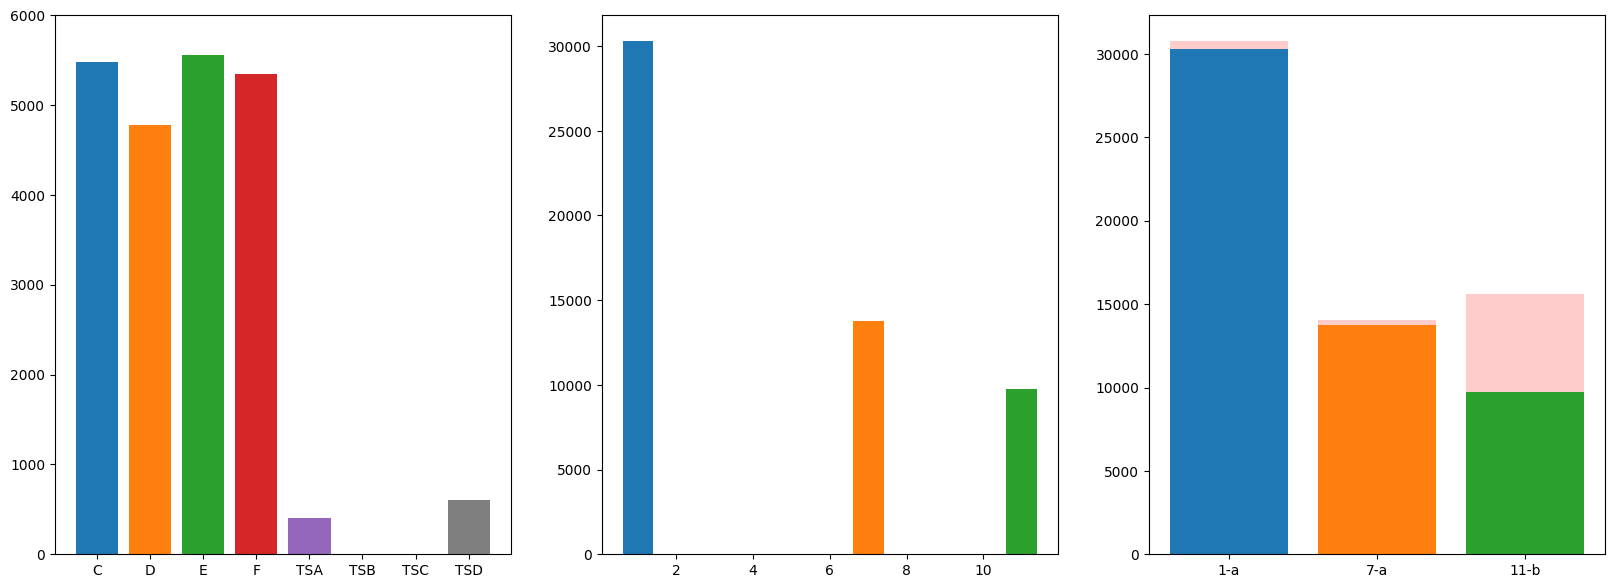

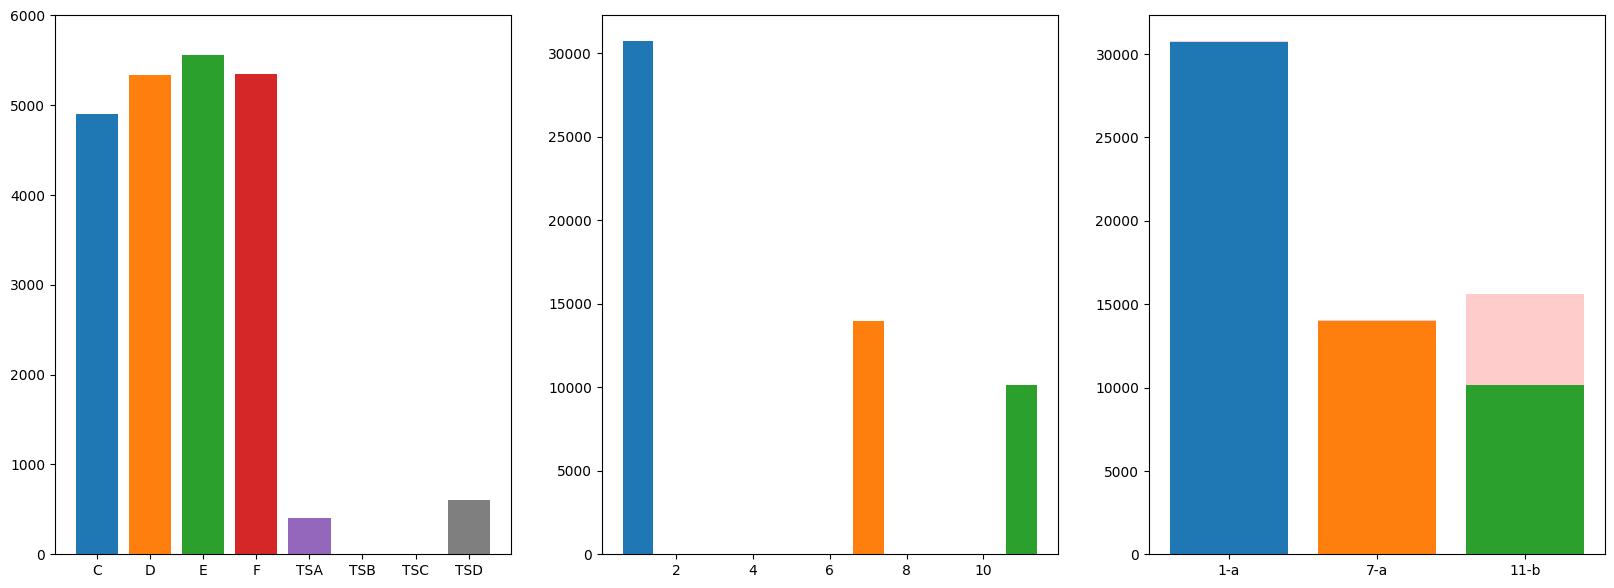

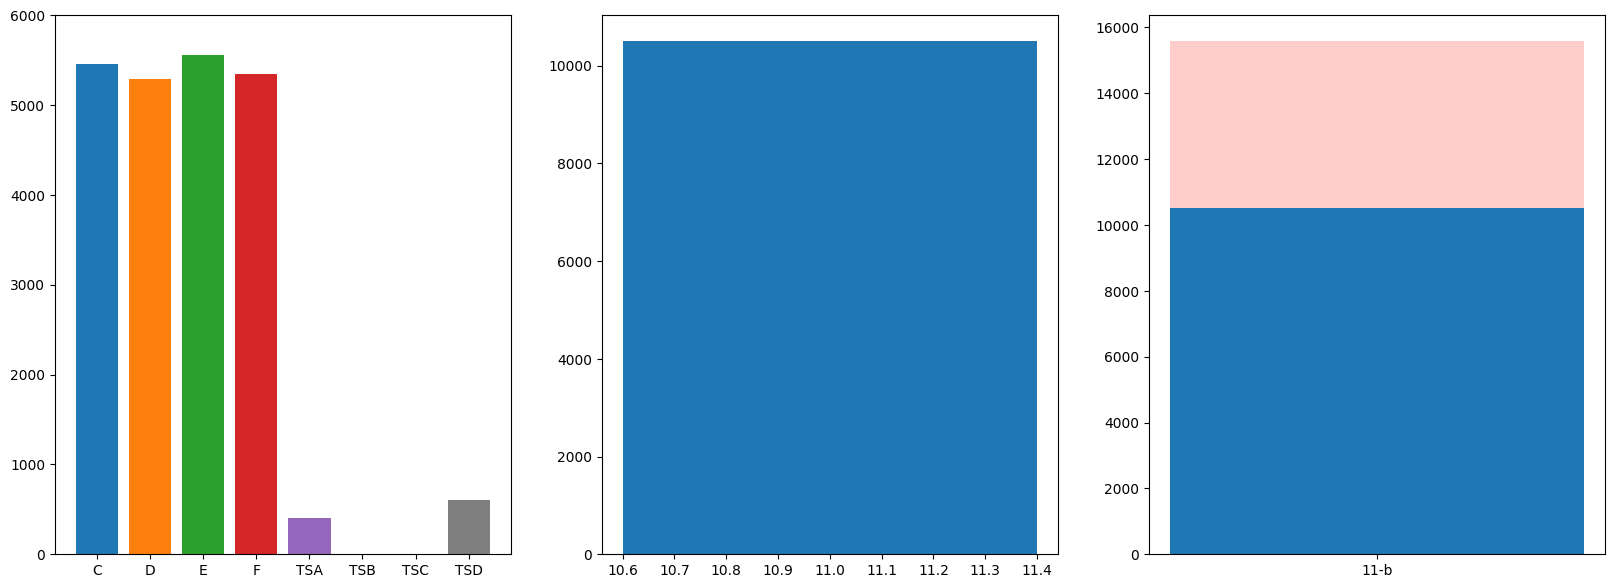

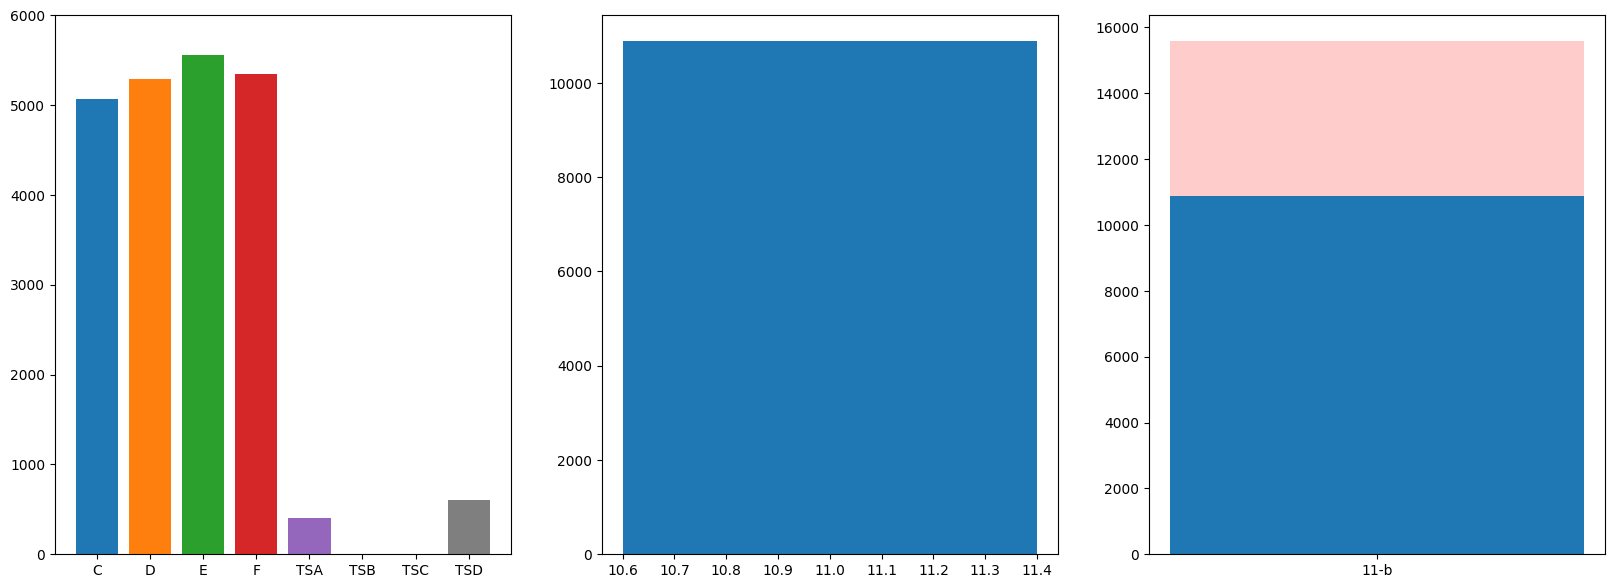

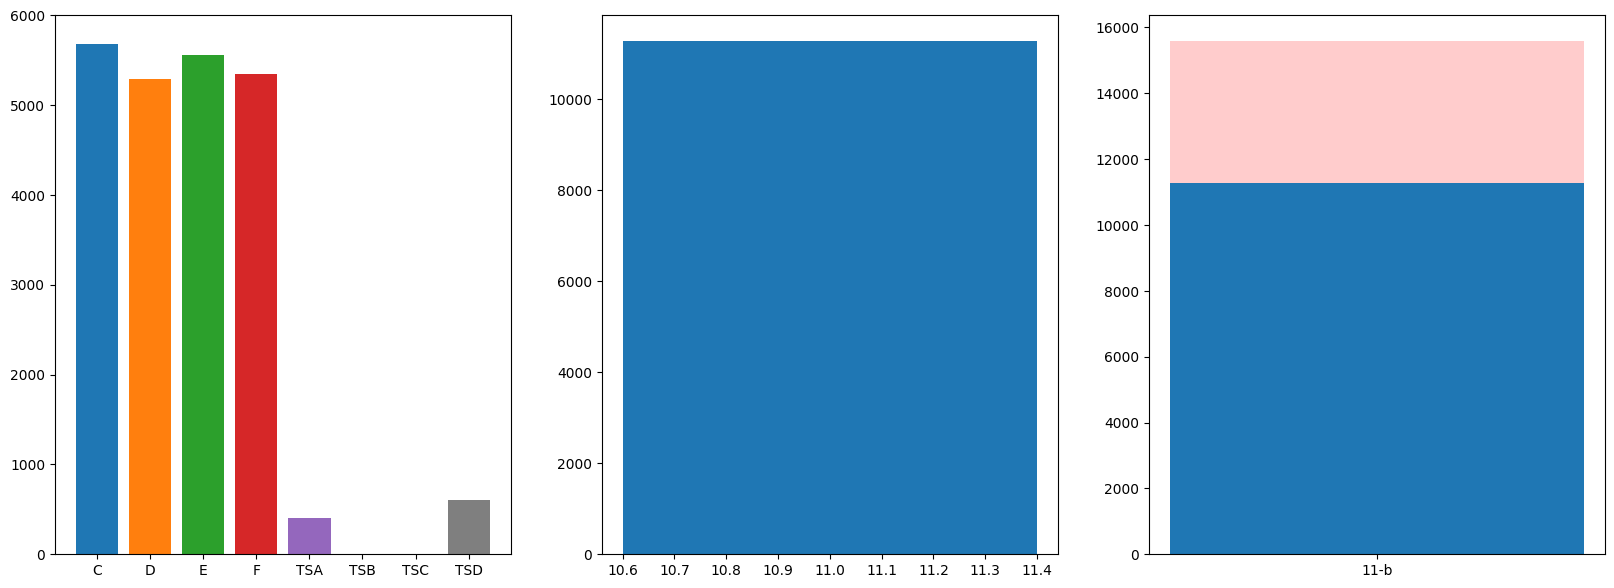

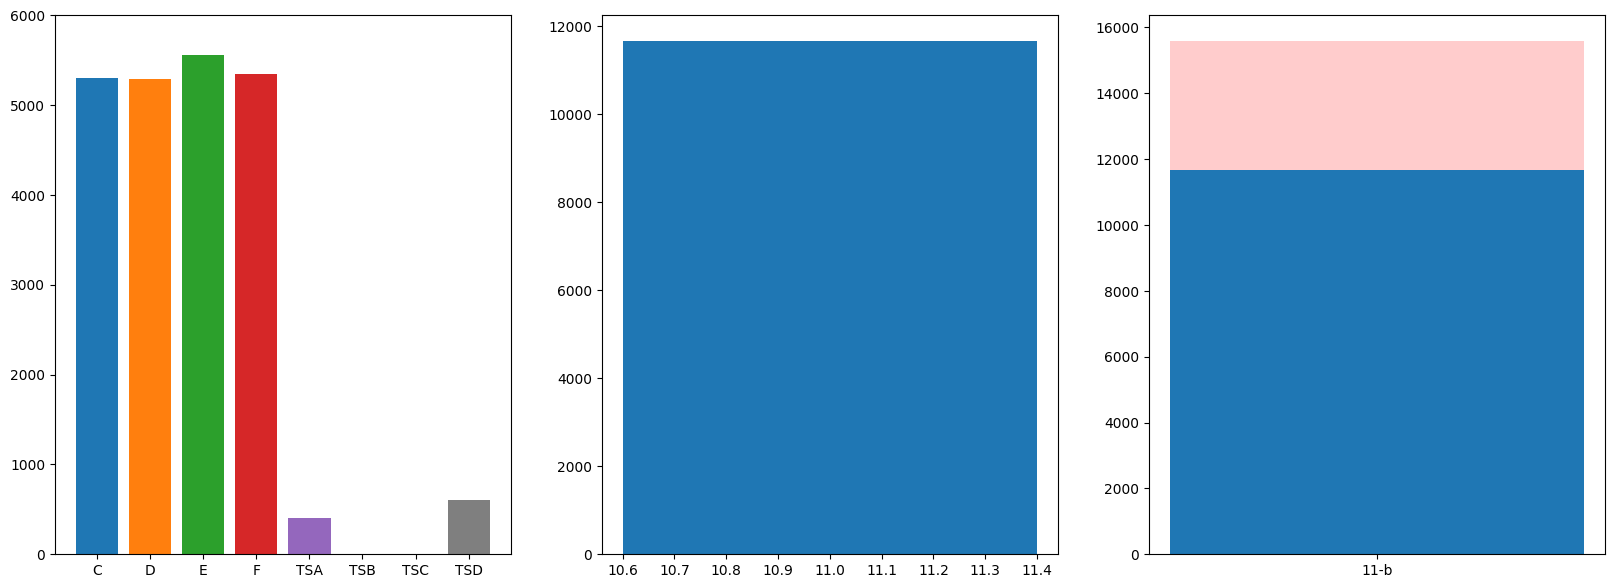

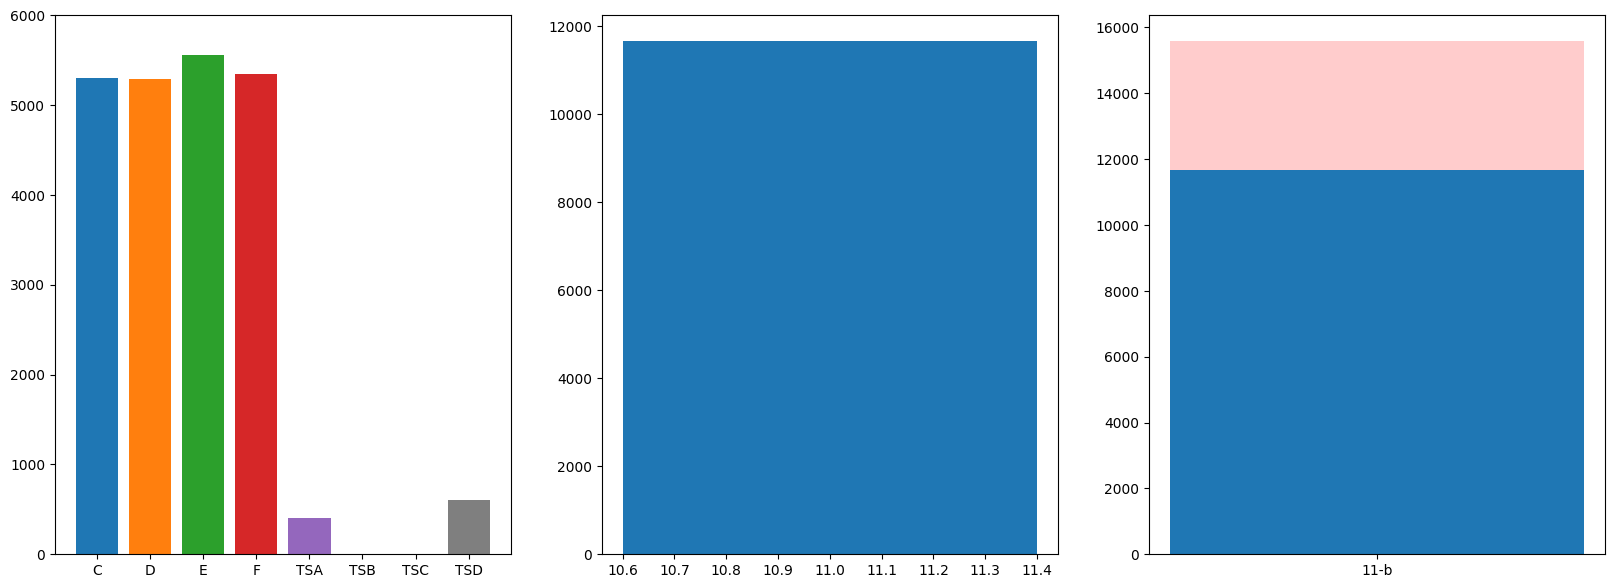

[]
Current timestamp 4500
timestamp 4500
5 steps
Current timestamp 4501
Current timestamp 4502
Current timestamp 4503
Current timestamp 4504
Current timestamp 4505
timestamp 4505
5 steps
Current timestamp 4506
Current timestamp 4507
Current timestamp 4508
Current timestamp 4509
checking silos
timestamp 4509
Current timestamp 4510
timestamp 4510
5 steps
Current timestamp 4511
Current timestamp 4512
Current timestamp 4513
Current timestamp 4514
Current timestamp 4515
timestamp 4515
5 steps
Current timestamp 4516
Current timestamp 4517
Current timestamp 4518
Current timestamp 4519
Current timestamp 4520
timestamp 4520
5 steps
Current timestamp 4521
Current timestamp 4522
Current timestamp 4523
Current timestamp 4524
Current timestamp 4525
timestamp 4525
5 steps
Current timestamp 4526
Current timestamp 4527
Current timestamp 4528
Current timestamp 4529
Current timestamp 4530
timestamp 4530
5 steps
Current timestamp 4531
Current timestamp 4532
Current timestamp 4533
Current timestamp 4534
C

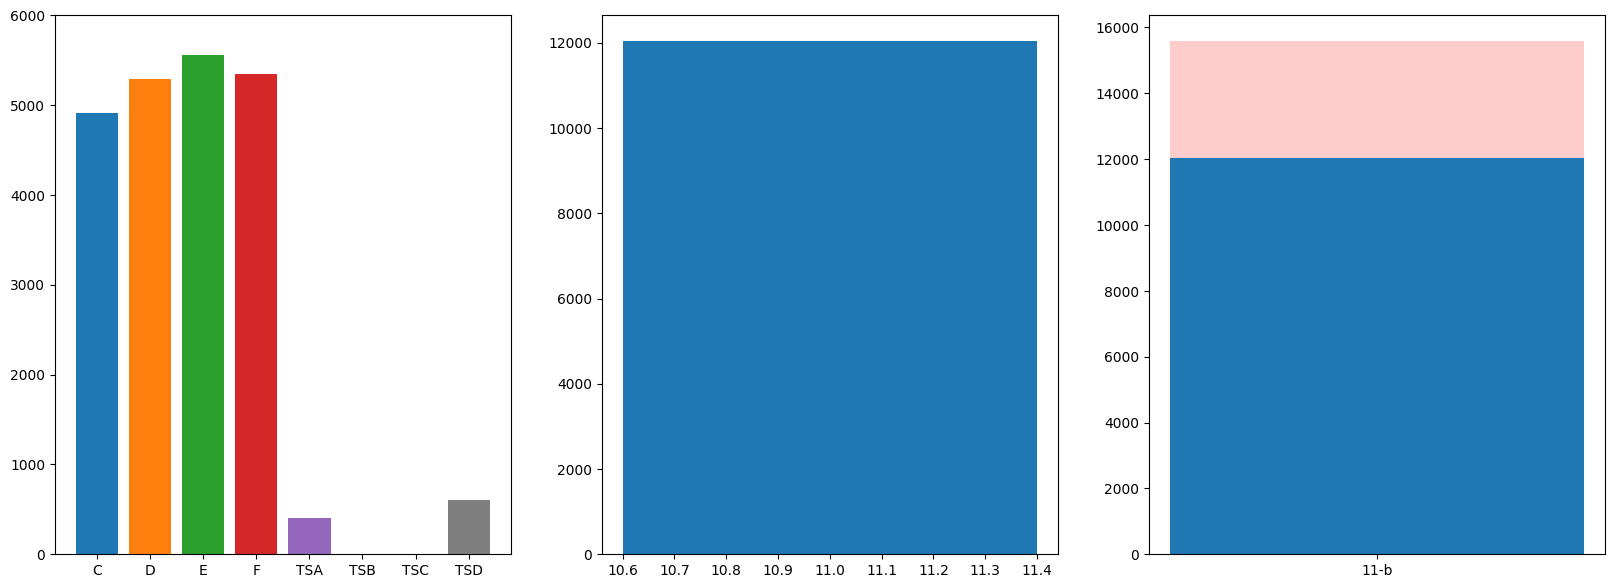

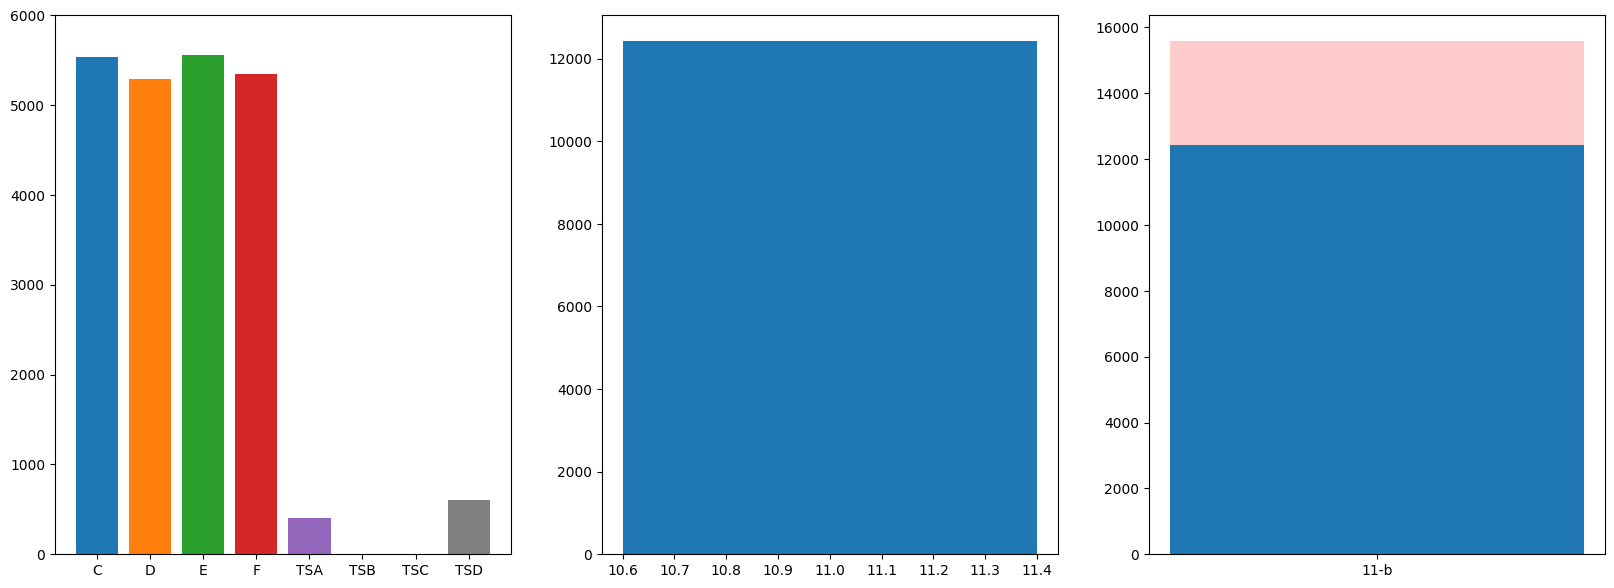

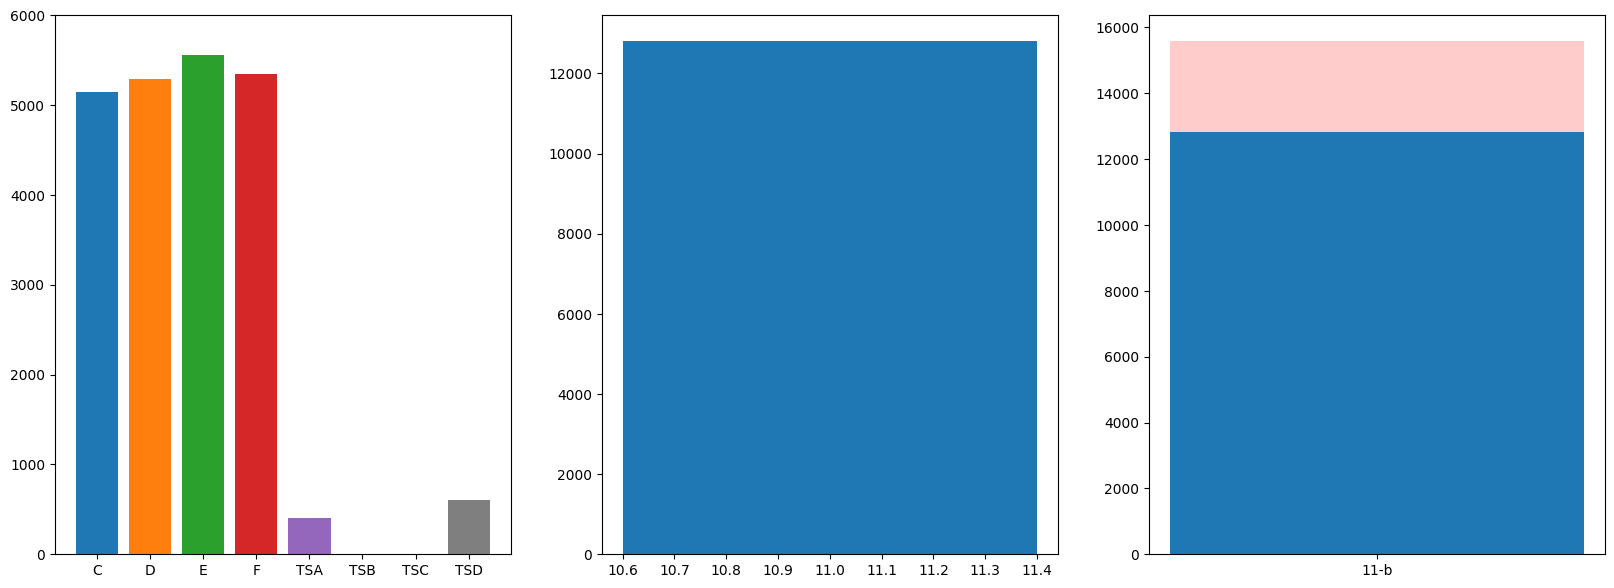

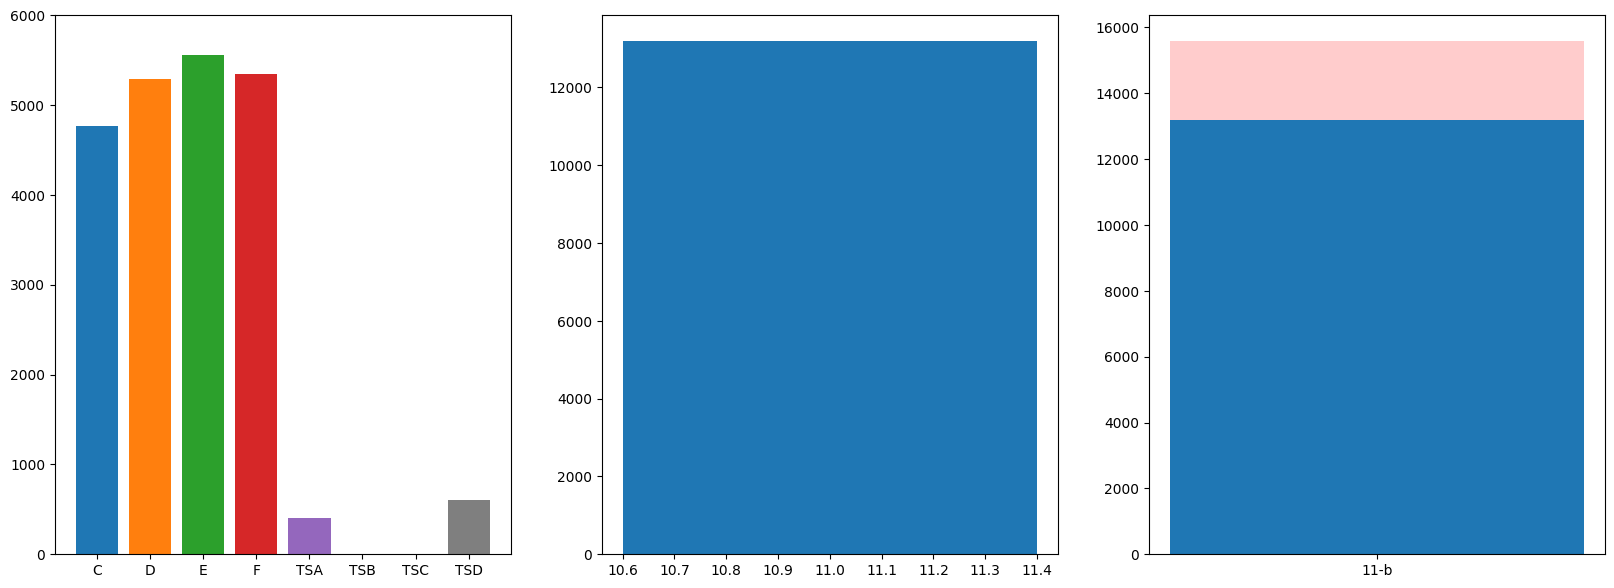

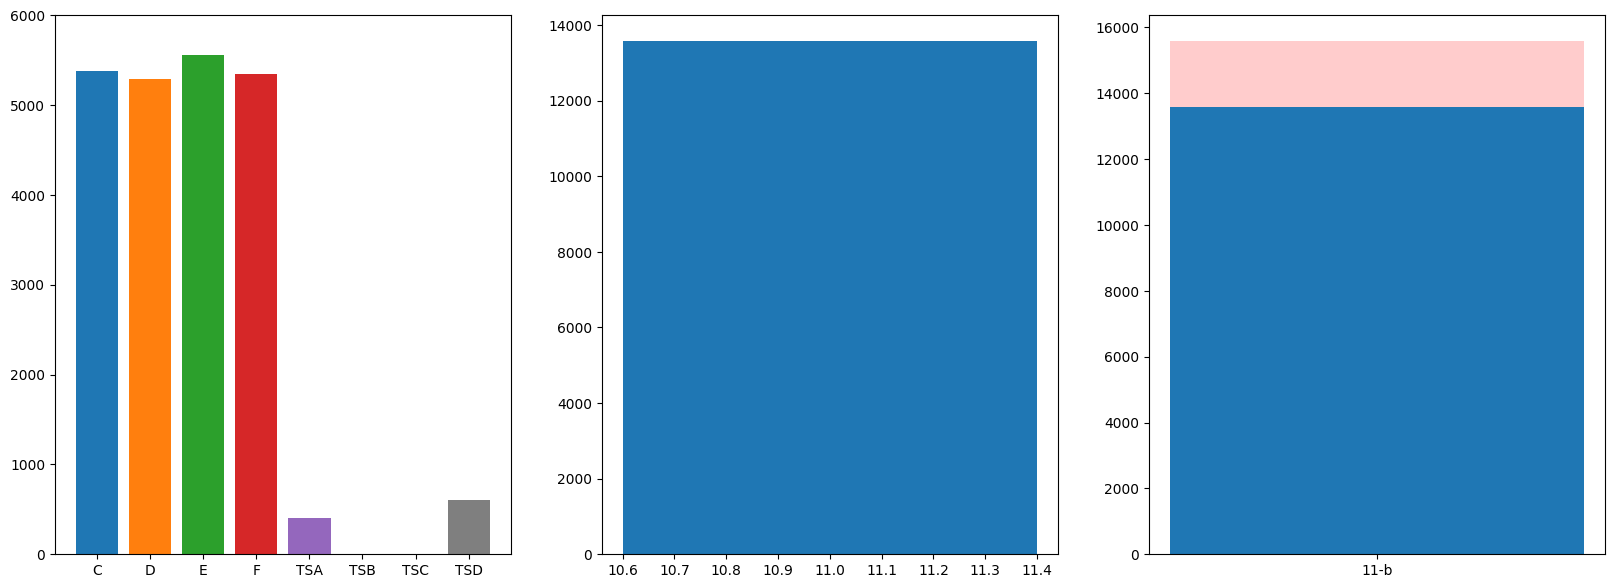

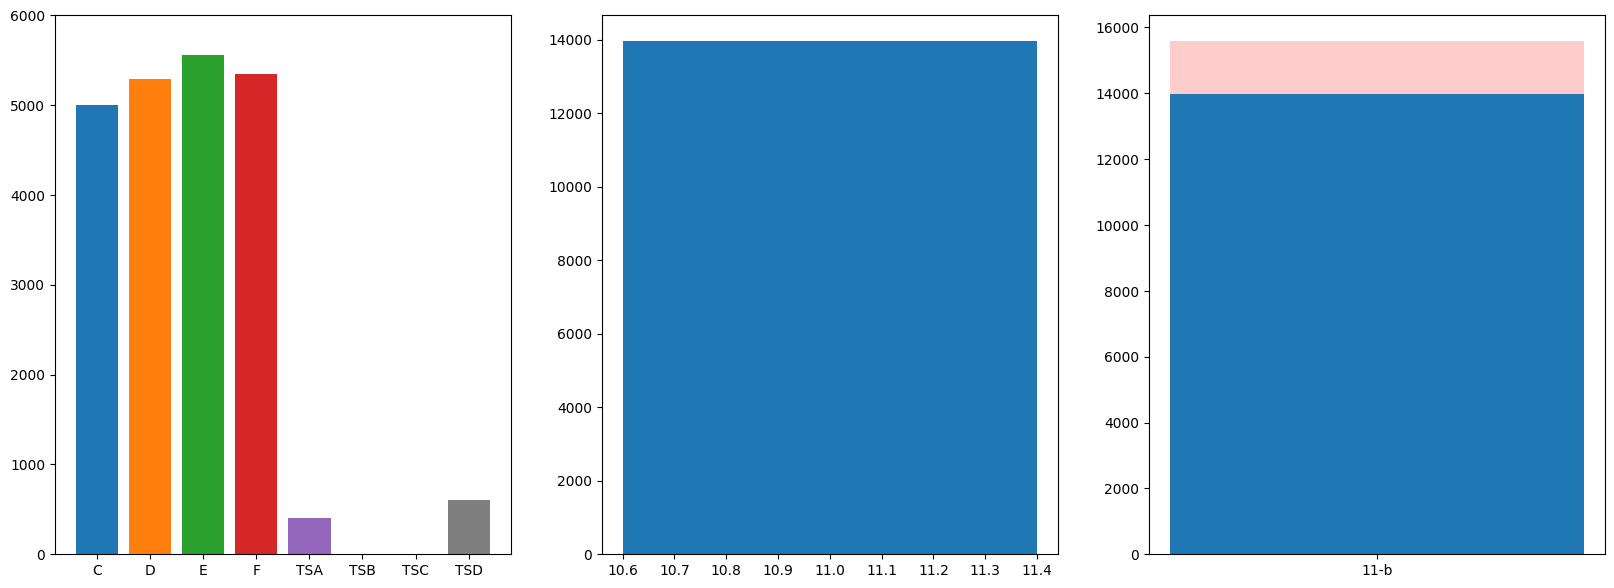

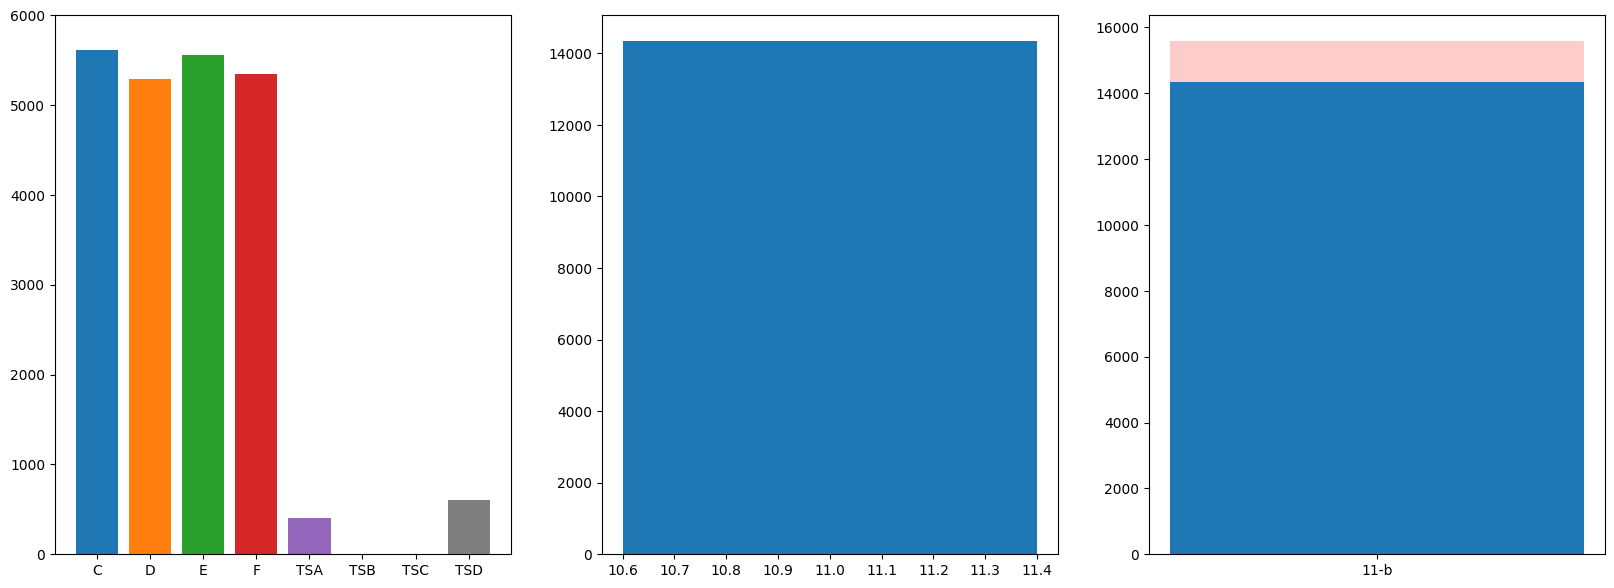

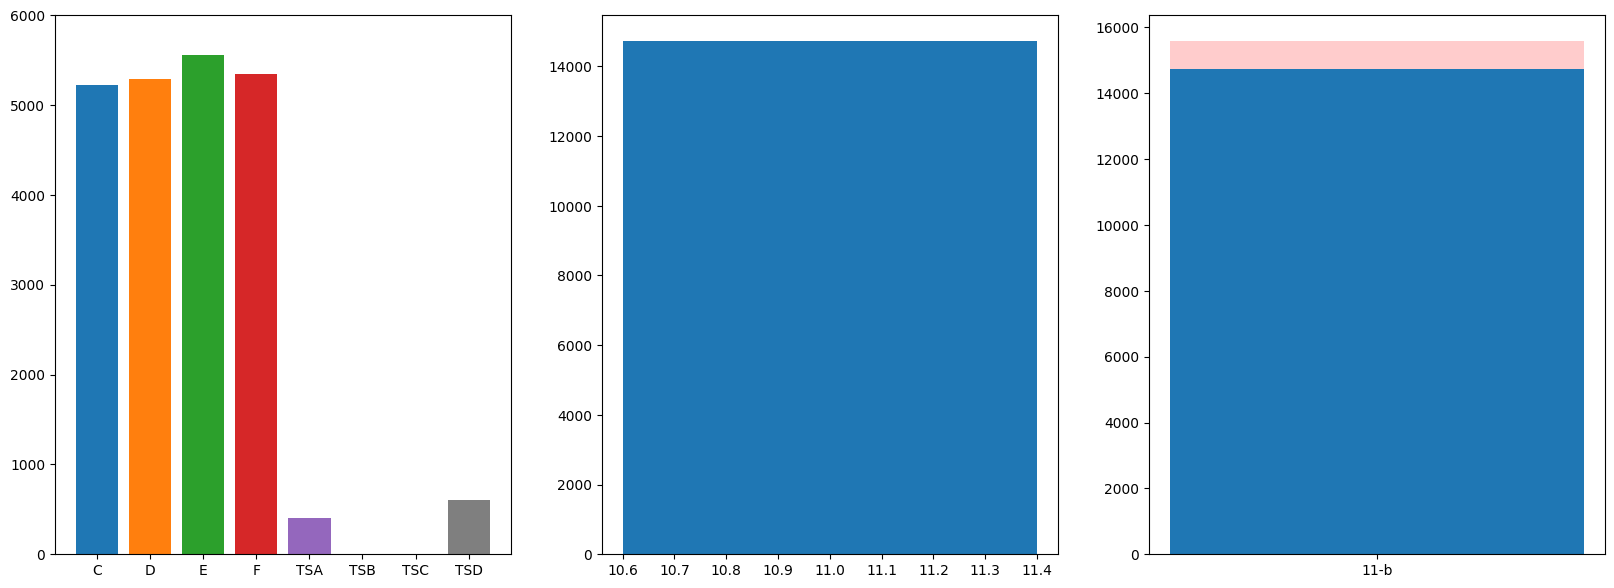

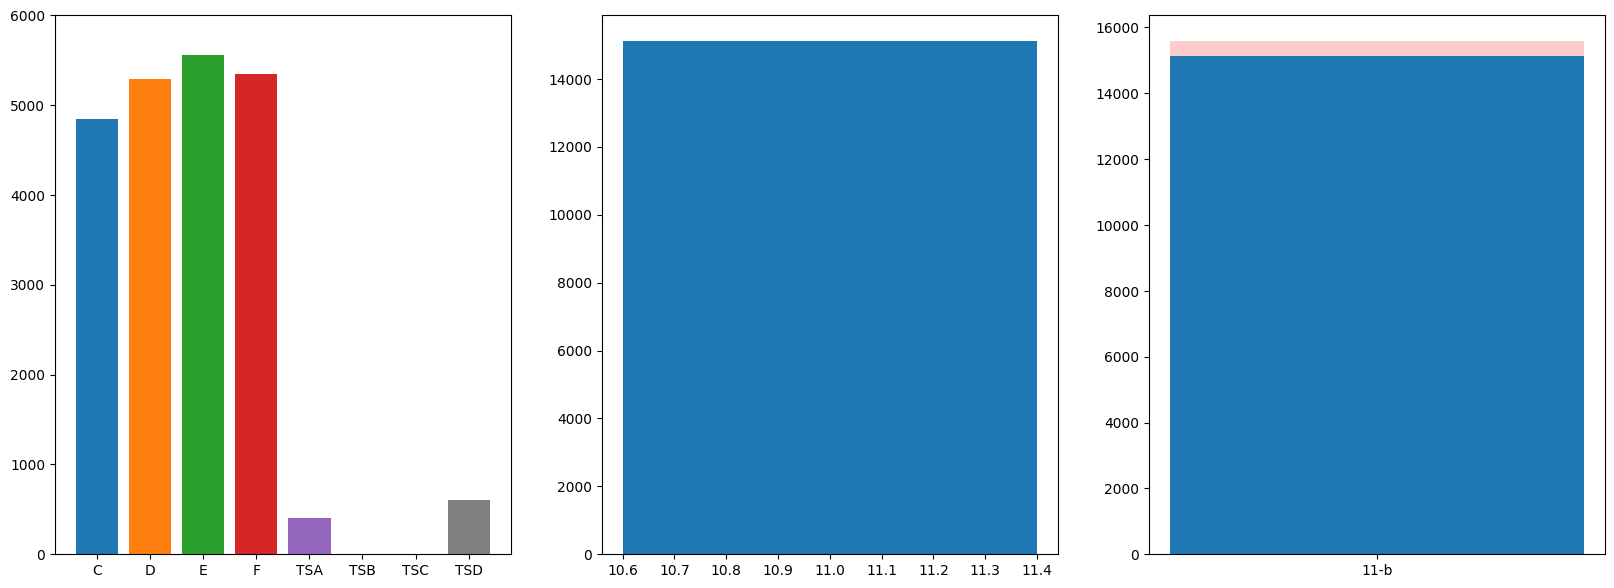

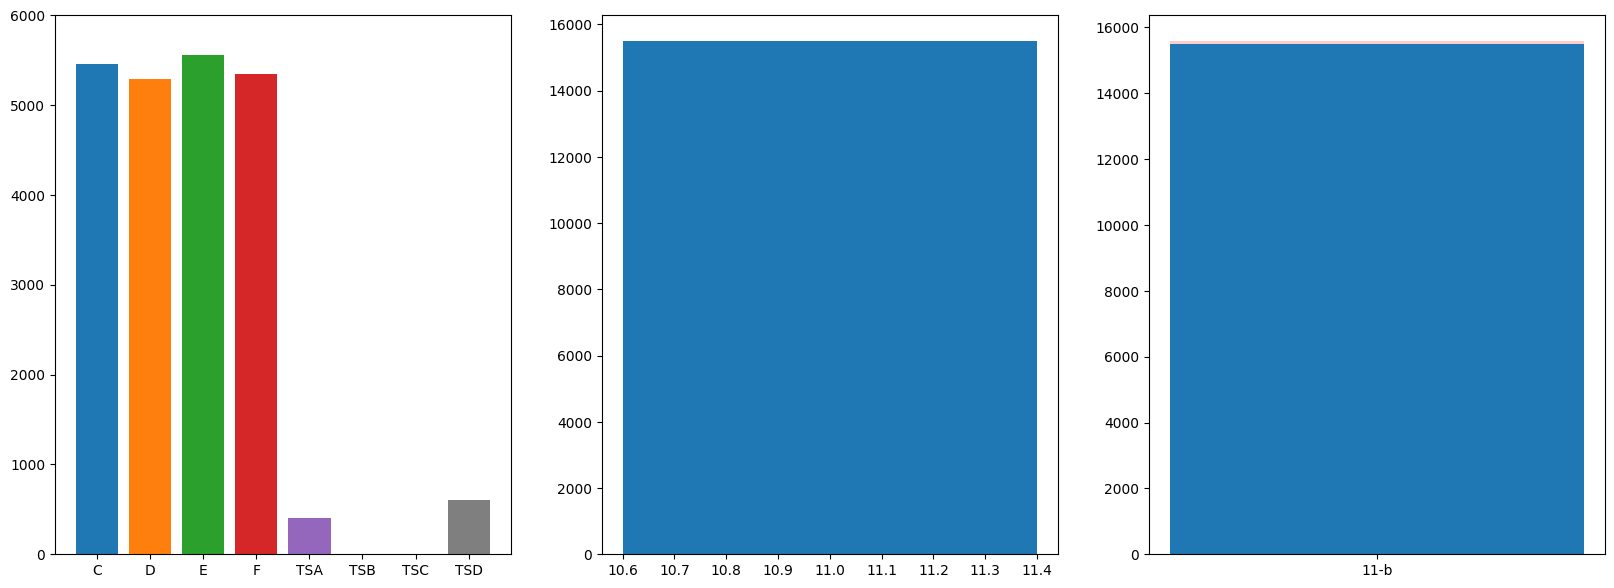

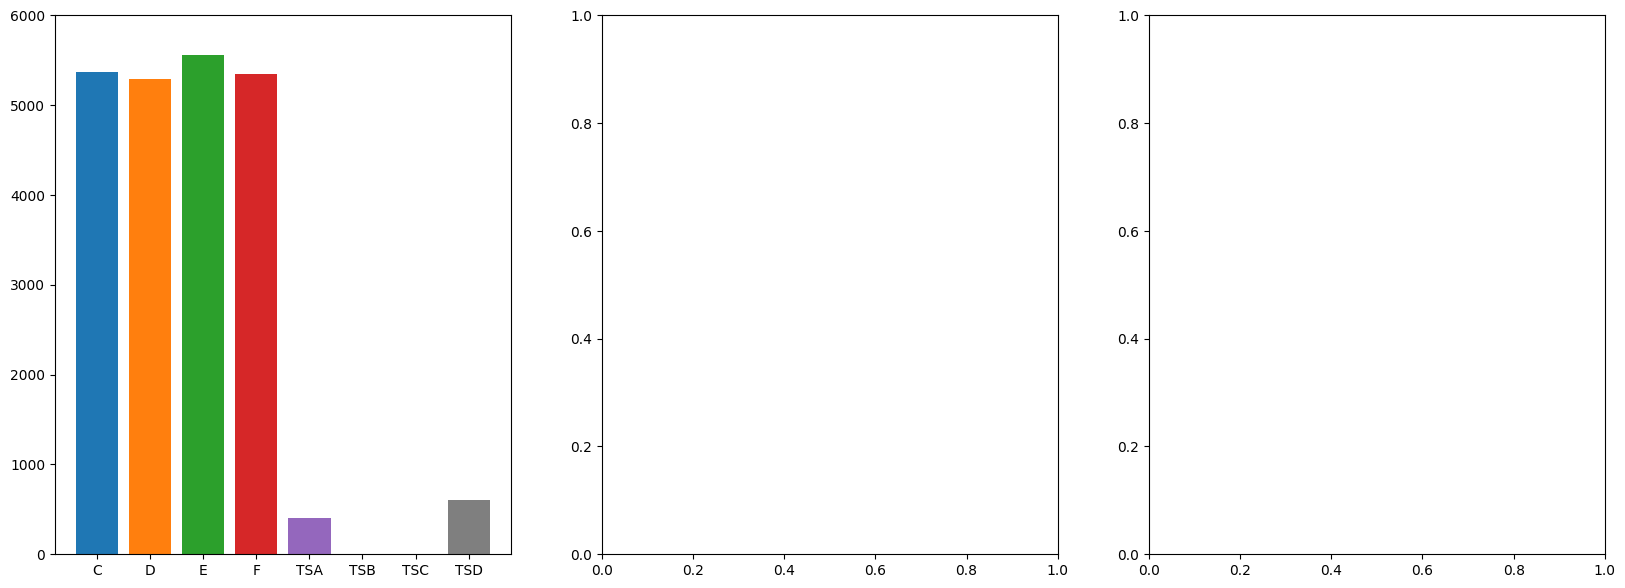

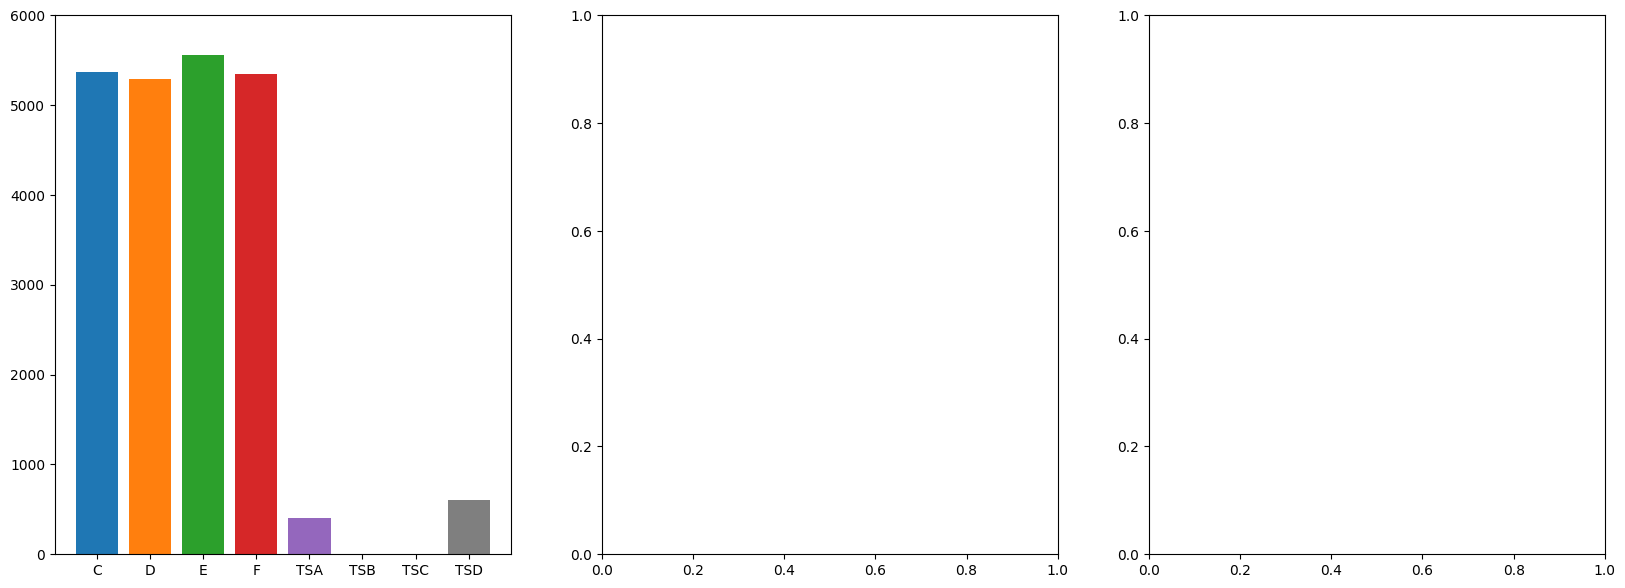

[]


In [160]:
save_images = True

step_size = 60

while schedule != []:

    for x in range(step_size):
        print("Current timestamp", timestamp)
        # every five steps
        if(timestamp % 5 == 0):
            # first check if some transit are zero as they have less "memory"
            first_transit_empty = get_first_transit_empty(timestamp, curr_schedule=schedule, blend_requests=blends_requests, blended_storage=blended_storage)
            print("5 steps")
            if(first_transit_empty):
                    # decide what blend to send there
                    
                #HOW?

                # check different tea blends in the schedule and see which one are missing from the transit

                for scheduleline in schedule:
                    # print(scheduleline.sub_schedules[0])
                    if(len(scheduleline.sub_schedules) > 0):
                        if(not blended_storage.is_blend_code_available_in_house(scheduleline.sub_schedules[0].blend_code)):
                            print("Blend not available", scheduleline.sub_schedules[0].blend_code)

                            stock_warehouse = blended_storage.is_blend_code_available_in_warehouse(scheduleline.sub_schedules[0].blend_code)
                            if(stock_warehouse):
                                print("Blend available in warehouse", scheduleline.sub_schedules[0].blend_code)
                                # add to the list
                                next_thing = {"blend_code": stock_warehouse.blend_code, "quantity":stock_warehouse.current_quantity, "from":"main_warehouse", "to": first_transit_empty, "to_name": first_transit_empty.name, "ttgo":5}
                                blended_storage.warehouse.remove(stock_warehouse)                    
                                # blends_requests.append(scheduleline.sub_schedules[0].blend_code)
                                # blends_requests_history.append(scheduleline.sub_schedules[0].blend_code)
                                blends_requests.append(next_thing)
                                blends_requests_history.append(next_thing)
                            else:
                                print("Blend not available in warehouse", scheduleline.sub_schedules[0].blend_code)                
                                # add to the list
                                # blends_requests.append(scheduleline.sub_schedules[0].blend_code)
                                # blends_requests_history.append(scheduleline.sub_schedules[0].blend_code)

                            # add to the list
                            # blends_requests.append(scheduleline.sub_schedules[0].blend_code)
                            # blends_requests_history.append(scheduleline.sub_schedules[0].blend_code)


                # next_thing = {"blend_code": first_transit_empty.blend_code, "quantity":1000, "from":"main_wharehouse", "to": first_transit_empty, "to_name": first_transit_empty.name, "ttgo":35}
                # print(first_transit_empty.blend_code)                                        


        # every 27 + 16 steps
        if(timestamp % (27) == 0):    
            print("checking silos")
            # if not check silos again
            first_empty = get_first_silos_emptiest(timestamp, curr_schedule=schedule, blend_requests=blends_requests, blended_storage=blended_storage)
            # if there is an silo to be filled
            if(first_empty):

                # if not used by any lines let it be empty or go empty            

                next_thing = {"blend_code": first_empty.blend_code, "quantity":1000, "from":"main_wharehouse", "to": blended_storage.get_silos(first_empty.name), "to_silos": first_empty.name, "ttgo":26, "to_line": blended_storage.get_silos(first_empty.name).attached_lines}

                blends_requests.append(next_thing)
                saved_step = copy.deepcopy(next_thing)
                blends_requests_history.append(saved_step)

        # print(blends_requests)

        for scheduleline in schedule:
            # print(scheduleline)
            done = scheduleline.step()
            if(done):
                print("removeing")
                schedule.remove(scheduleline)

        for blend_request in blends_requests:
            if(blend_request["ttgo"] > 0):
                blend_request["ttgo"] = blend_request["ttgo"]-1
            else:
                print("entering")
                print(blend_request["blend_code"], blend_request["quantity"])            
                blend_request["to"].add_blend(blend_code=blend_request["blend_code"], quantity=blend_request["quantity"])
                blends_requests.remove(blend_request)

        timestamp = timestamp + 1

    for silo in blended_storage.silos:
        print(silo.attached_lines)

    # print stock state 
        
    # print warehouse state
        
    # show bar chart of the current sylos state keep the maximum capacity fixed on the graph for all the silos
    if save_images and timestamp % 60 == 0:
        print("Saving image ", timestamp)
        save_stats(timestamp, blended_storage, schedule,)    

    if(timestamp % 500 == 0):
        print_stats(blended_storage, schedule)    
        print(blends_requests)

print_stats(blended_storage, schedule)    
print(blends_requests)

In [136]:
print(len(blends_requests_history))

82


In [137]:

df = pd.DataFrame(blends_requests_history).drop(columns=['from','to','ttgo'])
df

,blend_code,quantity,to_silos,to_line
0,B0002,1000,E,[6]
1,B0001,1000,D,[1]
2,B0002,1000,E,[6]
3,B0001,1000,D,[1]
4,B0003,1000,F,[11]
...,...,...,...,...
77,B0001,1000,C,"[7, 11]"
78,B0001,1000,D,"[1, 6]"
79,B0001,1000,D,"[1, 6]"
80,B0001,1000,C,"[7, 11]"


In [29]:
total_waste

0